In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt

In [2]:
folder = "/kaggle/input/iwslt15-englishvietnamese/IWSLT'15 en-vi"

vocab_en = os.path.join(folder, 'vocab.en.txt')
vocab_vi = os.path.join(folder, 'vocab.vi.txt')

train_en = os.path.join(folder, 'train.en.txt')
train_vi = os.path.join(folder, 'train.vi.txt')

validation_en = os.path.join(folder, 'tst2012.en.txt')
validation_vi = os.path.join(folder, 'tst2012.vi.txt')

test_en = os.path.join(folder, 'tst2013.en.txt')
test_vi = os.path.join(folder, 'tst2013.vi.txt')

In [3]:
def preprocess_sentence(w):
    w = w.lower().strip()
        
    # loại bỏ &apos; và &quot; trong dữ liệu
    w = re.sub(" &apos;", "", w)
    w = re.sub(" &quot;", "", w)
    
    # loại bỏ các kí tự đặc biệt & các dấu câu, chỉ giữ lại chữ, số từ 0-9 và khoảng trắng
    w = re.sub(r"[^\w0-9 ]+", " ", w)
    
    # rút gọn nhiều khoảng trắng dài thành 1 khoảng trắng
    w = re.sub(r"[\s]+", " ", w)
    
    # xóa khoảng trắng phía đầu và đuôi của câu
    w = w.strip()
    
    # thêm <start> và <end> ở đầu và cuối câu để model biết nơi bắt đầu và kết thúc dự đoán
    w = '<start> ' + w + ' <end>'
    
    return w

In [4]:
def create_dataset(input_path, target_path):
  input_lines = open(input_path, encoding='UTF-8').read().strip().split('\n')
  target_lines = open(target_path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = []
  for i in range(len(input_lines)):
    pi = preprocess_sentence(input_lines[i])
    pt = preprocess_sentence(target_lines[i])
    word_pairs.append([pi, pt])
  
  return word_pairs

In [5]:
train_pairs = create_dataset(train_en, train_vi)

In [6]:
def print_samples(pairs, number):
  """
  Hàm in ra một số câu Anh - Việt
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    number: số lượng các cặp câu cần in
    
  Returns:
    None
  """
  
  for i in range(number):
    print(pairs[i][0])
    print(pairs[i][1])

In [7]:
print_samples(train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> in 4 minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule <end>
<start> trong 4 phút chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu cùng với đoàn nghiên cứu của mình hàng ngàn người đã cống hiến cho dự án này một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên

In [8]:
def short_sentences(pairs):
  result = []
  
  for i in range(len(pairs)):
    if len(pairs[i][0].split()) <= 60 and len(pairs[i][1].split()) <= 60:
      result.append([pairs[i][0], pairs[i][1]])
  
  return result

In [9]:
short_train_pairs = short_sentences(train_pairs)

In [10]:
print_samples(short_train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo <end>
<start> headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog <end>
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu và như thế này khi nói về chất lượng không khí hay khói bụi <end>
<start> they are both two branches of the same field of atmospheric science <end>
<start> cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển <end>
<start> recently the headlines looked like this when the intergovernmental panel on climate change or ipcc put out their report on 

In [11]:
val_pairs = create_dataset(validation_en, validation_vi)

In [12]:
print_samples(val_pairs, 10)

<start> how can i speak in 10 minutes about the bonds of women over three generations about how the astonishing strength of those bonds took hold in the life of a four year old girl huddled with her young sister her mother and her grandmother for five days and nights in a small boat in the china sea more than 30 years ago bonds that took hold in the life of that small girl and never let go that small girl now living in san francisco and speaking to you today <end>
<start> làm sao tôi có thể trình bày trong 10 phút về sợi dây liên kết những người phụ nữ qua ba thế hệ về việc làm thế nào những sợi dây mạnh mẽ đáng kinh ngạc ấy đã níu chặt lấy cuộc sống của một cô bé bốn tuổi co quắp với đứa em gái nhỏ của cô bé với mẹ và bà trong suốt năm ngày đêm trên con thuyền nhỏ lênh đênh trên biển đông hơn 30 năm trước những sợi dây liên kết đã níu lấy cuộc đời cô bé ấy và không bao giờ rời đi cô bé ấy giờ sống ở san francisco và đang nói chuyện với các bạn hôm nay <end>
<start> this is not a finis

In [13]:
test_pairs = create_dataset(test_en, test_vi)

In [14]:
print_samples(test_pairs, 10)

<start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
<start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
<start> and i was very proud <end>
<start> tôi đã rất tự hào về đất nước tôi <end>
<start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
<start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
<start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
<start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào 

In [15]:
class LanguageIndex():
  def __init__(self, lang):
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    for phrase in self.lang:
      self.vocab.update(phrase.split())
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

In [16]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [17]:
def load_train_dataset(input_path, target_path):
  # Nhập dữ liệu đầu vào cho tập Train
  pairs = create_dataset(input_path, target_path)
  
  # Cập nhật vocab của từng ngôn ngữ Anh, Việt
  inp_lang = LanguageIndex(en for en, vi in pairs)
  targ_lang = LanguageIndex(vi for en, vi in pairs)
  
  # Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ
  pairs = short_sentences(pairs)

  # Chuyển các từ trong câu Tiếng Anh sang index
  input_tensor = [[inp_lang.word2idx[word] for word in en.split()] for en, vi in pairs]

  # Chuyển các từ trong câu Tiếng Việt sang index
  target_tensor = [[targ_lang.word2idx[word] for word in vi.split()] for en, vi in pairs]

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [18]:
input_tensor_train, target_tensor_train, inp_lang, targ_lang, max_length_inp, max_length_targ = load_train_dataset(train_en, train_vi)

In [19]:
print(len(inp_lang.word2idx))
print(len(targ_lang.word2idx))

42916
19823


In [20]:
max_length_inp, max_length_targ

(60, 60)

In [21]:
input_tensor_train[0]

array([  804, 30734, 28670, 38331, 33653,  4190,   806,  7530, 17534,
         803,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [22]:
target_tensor_train[0]

array([  966,  8810,  7882, 19586, 14950, 11495, 16976, 19606, 18357,
        8896,  7856,   965,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [23]:
def load_val_dataset(input_path, target_path, inp_lang, targ_lang):
  # Nhập dữ liệu đầu vào cho tập Validation
  pairs = create_dataset(input_path, target_path)
  
  # Chuyển các từ trong câu Tiếng Anh và Tiếng Việt sang index dựa trên vocab của tập Train
  # Từ nào không có trong vocab của tập Train thì cho index = 0
  
  input_tensor = []
  target_tensor = []
  
  for en, vi in pairs:
    inputs = []
    for word in en.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)
    input_tensor.append(inputs)
    
    targets = []
    for word in vi.split():
      try:
        index = targ_lang.word2idx[word]
      except:
        index = 0
      targets.append(index)
    target_tensor.append(targets)

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
  input_tensor = tf.convert_to_tensor(input_tensor)

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
  target_tensor = tf.convert_to_tensor(target_tensor)

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [24]:
input_tensor_val, target_tensor_val, inp_lang_val, targ_lang_val, max_length_inp_val, max_length_targ_val = load_val_dataset(validation_en, validation_vi, inp_lang, targ_lang)

In [25]:
max_length_inp_val, max_length_targ_val

(92, 119)

In [26]:
input_tensor_val[0]

<tf.Tensor: id=5, shape=(92,), dtype=int32, numpy=
array([  804, 18358,  6189, 18660, 35762, 19091,    31, 24476,   905,
       38331,  5082, 26613, 42297, 27196, 38514, 15939,   905, 18358,
       38331,  3071, 36696, 26613, 38488,  5082, 38880, 18080, 19091,
       38331, 22206, 26613,   806, 15230, 42618, 26690, 16198, 18402,
       42227, 17762, 42717, 34929, 17762, 25034,  2173, 17762, 16615,
       15047, 14686, 10010,  2173, 26035, 19091,   806, 35229,  4976,
       19091, 38331,  7149, 33805, 24949, 38312,   487, 42627,  1578,
        5082, 38322, 38880, 18080, 19091, 38331, 22206, 26613, 38322,
       35229, 16198,  2173, 25905, 22068, 16361, 38322, 35229, 16198,
       26319, 22432, 19091, 33298, 15300,  2173, 35765, 38776, 42713,
       38791,   803], dtype=int32)>

In [27]:
target_tensor_val[0]

<tf.Tensor: id=10, shape=(119,), dtype=int32, numpy=
array([  966,  9937, 14910, 17635,  4380, 16837, 17285,  2833, 17219,
          32, 13409, 18357, 16181,  5159,  9691,  9309, 12266, 11922,
       13470, 12659, 13864,  1833, 16830,  7877, 18357, 18161,  9937,
       16830, 12497, 12266, 16181,  5159, 11412, 11450, 19440,  9039,
       11931, 19728, 19455, 12532,  3793, 10074,  4320, 16162,  4536,
       11495,  4387,  2859,  3029, 17527,  3971, 13981, 18389, 19674,
        5482,  6874, 12232,  4536,  4387,  2859, 18389, 11447, 18215,
        2827, 17219, 15979, 12553, 11872, 19467, 17280,  4067, 16672,
       12232,  9978, 19469, 17280,  2343, 19496,  7809,   553, 12553,
       17326, 12266, 16181,  5159,  9691,  9309, 19455, 12532, 10074,
        4320, 19660,  4387,  2859, 19728, 18215,  8910,  1955,  6550,
       14762, 19366,  4387,  2859, 19728,  6550, 16162, 19796, 14874,
        6025, 18215, 19352, 12537,  3630, 18389,  4345,  2936,  7788,
       11644,   965], dtype=int32)>

In [28]:
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(128111, 128111, 1553, 1553)

## Train

In [29]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [31]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [32]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [33]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [34]:
class LuongAttention(tf.keras.Model):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)
  
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = tf.matmul(values, self.W(hidden_with_time_axis), transpose_b=True)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
      super(Decoder, self).__init__()
      self.batch_sz = batch_sz
      self.dec_units = dec_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = gru(self.dec_units)
      self.fc = tf.keras.layers.Dense(vocab_size)

      # used for attention
      self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the GRU
      output, state = self.gru(x)

      # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

      # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [36]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [37]:
LEARNING_RATE = 0.001

In [38]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [39]:
def loss_function(real, pred):

  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  
  return tf.reduce_mean(loss_)

In [40]:
global_step = tf.train.get_or_create_global_step()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [41]:
from fastprogress import master_bar, progress_bar

In [42]:
def epoch_training(encoder, decoder, dataset, global_step, mb, num_step):
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        with tf.GradientTape() as tape:
            # Feedforward
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
                
            batch_loss = (loss / int(targ.shape[1]))
            
            train_losses.append(batch_loss)
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables), global_step=global_step) 
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    return sum(train_losses)/ len(train_losses)

In [43]:
def epoch_evaluation(encoder, decoder, dataset, mb, num_step):
    val_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        # Feed forward
        enc_output, enc_hidden = encoder(inp, hidden)
            
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
        batch_loss = (loss / int(targ.shape[1]))
        
        val_losses.append(batch_loss)
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    
    return sum(val_losses)/ len(val_losses)

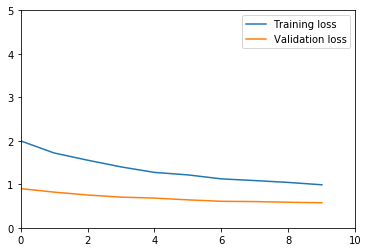

Finish train epoch 0 with loss 1.9990
Finish validate epoch 0 with loss 0.9015
Finish train epoch 1 with loss 1.7210
Finish validate epoch 1 with loss 0.8206
Finish train epoch 2 with loss 1.5548
Finish validate epoch 2 with loss 0.7545
Finish train epoch 3 with loss 1.4006
Finish validate epoch 3 with loss 0.7051
Finish train epoch 4 with loss 1.2737
Finish validate epoch 4 with loss 0.6830
Finish train epoch 5 with loss 1.2164
Finish validate epoch 5 with loss 0.6422
Finish train epoch 6 with loss 1.1249
Finish validate epoch 6 with loss 0.6096
Finish train epoch 7 with loss 1.0857
Finish validate epoch 7 with loss 0.6031
Finish train epoch 8 with loss 1.0432
Finish validate epoch 8 with loss 0.5872
Finish train epoch 9 with loss 0.9888
Finish validate epoch 9 with loss 0.5756


In [45]:
EPOCHS = 10

mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss']
training_losses = []
validation_losses = []
x = []

train_step = math.floor(len(input_tensor_train)*1.0/BATCH_SIZE)
val_step = math.floor(len(input_tensor_val)*1.0/BATCH_SIZE)

for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = encoder.initialize_hidden_state()
    x.append(epoch)
    
    ### START CODE HERE
    # Training
    training_loss = epoch_training(encoder, decoder, train_dataset, global_step, mb, train_step)
    
    # Cập nhật thông tin sau khi huấn luyện
    training_losses.append(training_loss)
    
    # Validating
    valid_loss = epoch_evaluation(encoder, decoder, validation_dataset, mb, val_step)
    
    # Cập nhật thông tin sau khi validate
    validation_losses.append(valid_loss)
    
    # Cập nhật đồ thị
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses]], [0,EPOCHS], [0,5])
    
    print('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    print('Finish validate epoch {} with loss {:.4f}'.format(epoch,valid_loss))
    
    # Update score và lưu model có score tốt nhất
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    ### END CODE HERE
    

In [ ]:
# khôi phục checkpoint cuối cùng trong folder checkdir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Đánh giá output

In [46]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    # Làm sạch câu Tiếng Anh
    sentence = preprocess_sentence(sentence)
    
    # Chuyển câu Tiếng Anh sang index
    inputs = []
    for word in sentence.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    # Dịch
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id]

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        else:
          result += ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [47]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [48]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):

    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> i love you <end>
Predicted translation: tôi yêu quý vị <end>


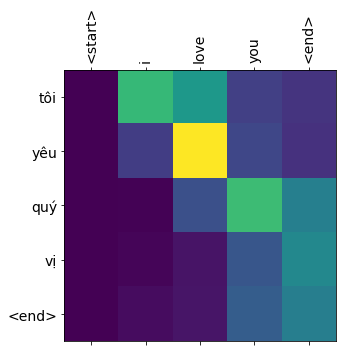

In [49]:
translate(u'i love you', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

In [53]:
pairs_2 = create_dataset(test_en, test_vi)

In [55]:
!pip install sacrebleu

    100% |████████████████████████████████| 112kB 23.1MB/s ta 0:00:01
    100% |████████████████████████████████| 14.8MB 2.6MB/s eta 0:00:01   45% |██████████████▌                 | 6.7MB 61.5MB/s eta 0:00:01
mxnet-cu100 1.4.0.post0 has requirement numpy<1.15.0,>=1.8.2, but you'll have numpy 1.19.5 which is incompatible.
lime 0.1.1.33 has requirement matplotlib==2.1.0, but you'll have matplotlib 3.0.3 which is incompatible.
kmeans-smote 0.1.2 has requirement imbalanced-learn<0.5,>=0.4.0, but you'll have imbalanced-learn 0.5.0.dev0 which is incompatible.
kmeans-smote 0.1.2 has requirement numpy<1.16,>=1.13, but you'll have numpy 1.19.5 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3
  Found existing installation: tabulate 0.8.3
    Uninstalling tabulate-0.8.3:
      Successfully uninstalled tabulate-0.8.3
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 11, in <module>
    s


Input:  <start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
Groundtruth:  <start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
Translation:  <start> khi tôi rất phấn khích tôi là nước của tôi là điều tốt nhất của tôi và tôi lớn lên hát một câu chuyện không phải là gì <end>
Bleu Score:  16.91181632687732

Input:  <start> and i was very proud <end>
Groundtruth:  <start> tôi đã rất tự hào về đất nước tôi <end>
Translation:  <start> tôi rất tự hào <end>
Bleu Score:  29.44656445786982


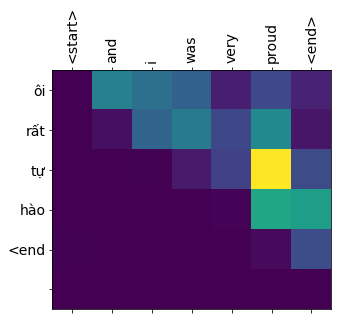


Input:  <start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
Groundtruth:  <start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
Translation:  <start> ở trường chúng tôi đã dành nhiều thời gian nghiên cứu lịch sử dụng kim jong il nhưng chúng tôi chưa bao giờ học được nhiều về thế giới bên ngoài nước mỹ <end>
Bleu Score:  25.324142269978346

Input:  <start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
Groundtruth:  <start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào nhưng tôi vẫn nghĩ rằng mình sẽ sống cả cuộc đời ở bắctriều tiên cho tới khi tất cả mọi thứ đột nhiên tha

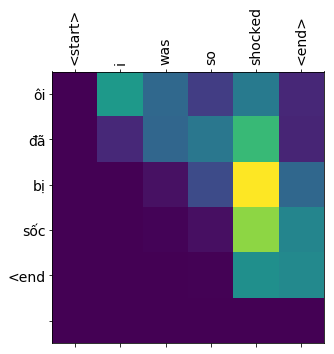


Input:  <start> this was the first time i heard that people in my country were suffering <end>
Groundtruth:  <start> vì đó là lần đầu tiên tôi biết rằng đồng bào của tôi đang phải chịu đựng như vậy <end>
Translation:  <start> điều đầu tiên tôi đã nghe thấy những người trong đất nước tôi bị thương hại <end>
Bleu Score:  13.129018476513854

Input:  <start> soon after when i was walking past a train station i saw something terrible that i cant erase from my memory <end>
Groundtruth:  <start> không lâu sau đó khi tôi đi qua một nhà ga tôi nhìn thấy một cảnh tượng kinh hoàng mà tôi không bao giờ có thể quên <end>
Translation:  <start> ngay sau khi tôi đi qua một chuyến tàu tôi thấy một điều tồi tệ tôi không thể xoá bỏ qua trí nhớ của tôi <end>
Bleu Score:  20.715212036102436

Input:  <start> a lifeless woman was lying on the ground while an emaciated child in her arms just stared helplessly at his mothers face <end>
Groundtruth:  <start> trên nền nhà ga là xác chết của một người đàn bà hai

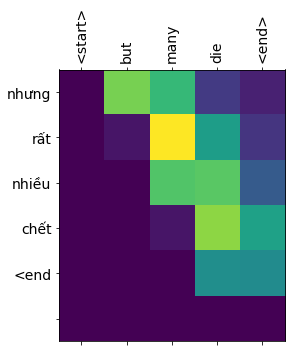


Input:  <start> sometimes i saw dead bodies floating down the river <end>
Groundtruth:  <start> và tôi đã nhìn thấy xác họ nổi trên sông <end>
Translation:  <start> đôi khi tôi thấy những con cá mập mờ đi xuống sông <end>
Bleu Score:  20.706193828327603

Input:  <start> i cant reveal many details 91 about 93 how i left north korea but i only can say that during the ugly years of the famine i was sent to china to live with distant relatives <end>
Groundtruth:  <start> tôi không thể nói cụ thể về việc mình đã trốn khỏi bắc triều tiên như thế nào chỉ có thể nói rằng trong những năm tháng khốn khó vì nạn đói ấy tôi được gửi sang trung quốc để sống với một người họ hàng xa <end>
Translation:  <start> tôi không thể thấy nhiều chi tiết trên thế giới tôi ở trung quốc nhưng tôi chỉ có thể nói rằng trong thời kỳ khủng hoảng tài trợ tôi đã gửi đến trung tâm đến với những người chúng <end>
Bleu Score:  21.93226307253086

Input:  <start> but i only thought that i would be separated from my family 

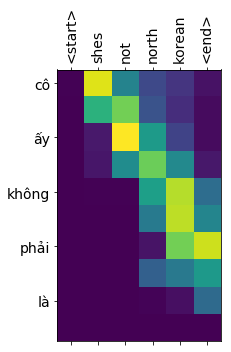


Input:  <start> and they let me go it was a miracle <end>
Groundtruth:  <start> và họ thả tôi ra đó quả là một phép màu <end>
Translation:  <start> và chúng tôi sẽ làm tôi là một cảm giác <end>
Bleu Score:  23.801485533558356

Input:  <start> some north koreans in china seek asylum in foreign embassies but many can be caught by the chinese police and repatriated <end>
Groundtruth:  <start> một số người bắc triều tiên ở trung quốc đã đến những đại sứ quán của nước ngoài để xin tị nạn nhưng rất nhiều trong số đó đã bị bắt bởi cảnh sát trung quốc và bị trả về nước <end>
Translation:  <start> một số người dân bắc mỹ trong trung tâm đến châu âu ở châu âu nhưng nhiều người có thể bị bắt đầu bởi các quốc gia và cả <end>
Bleu Score:  15.019187880468415

Input:  <start> these girls were so lucky <end>
Groundtruth:  <start> những cô gái này đã rất may mắn <end>
Translation:  <start> những người phụ nữ này rất may mắn <end>
Bleu Score:  54.45178846139407


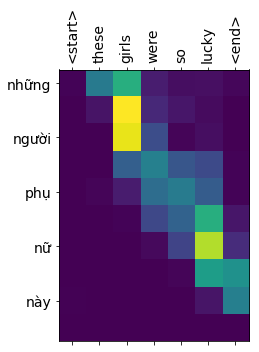


Input:  <start> even though they were caught they were eventually released after heavy international pressure <end>
Groundtruth:  <start> vì mặc dù đã bị bắt nhưng cuối cùng học cũng được thả ra nhờ vào sức ép từ cộng đồng quốc tế <end>
Translation:  <start> thậm chí họ đã bị bắt đầu sau khi được phát ra sau khi các nước sạch <end>
Bleu Score:  11.317868252940366

Input:  <start> these north koreans were not so lucky <end>
Groundtruth:  <start> nhưng những người bắc triều tiên này thì không được may mắn như vậy <end>
Translation:  <start> những khu vực này người dân không phải không may mắn <end>
Bleu Score:  15.090393345219246

Input:  <start> every year countless north koreans are caught in china and repatriated to north korea where they can be tortured imprisoned or publicly executed <end>
Groundtruth:  <start> hàng năm có vô số người bắc triều tiên bị bắt ở trung quốc và bị trả về nước nơi mà họ bị tra tấn bị giam cầm hoặc bị xử tử công khai <end>
Translation:  <start> mỗi năm 187

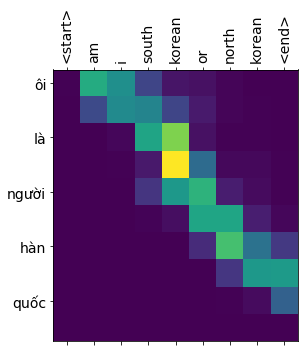


Input:  <start> where am i from who am i <end>
Groundtruth:  <start> tôi đến từ đâu và tôi là ai <end>
Translation:  <start> tôi là từ tôi là tôi <end>
Bleu Score:  29.69830085238936


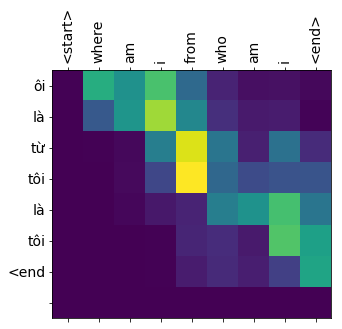


Input:  <start> suddenly there was no country i could proudly call my own <end>
Groundtruth:  <start> bỗng nhiên tôi chẳng có một đất nước nào để có thể tự hào gọi là tổ quốc <end>
Translation:  <start> đột nhiên không có nước không có thể tự gọi là chính là gì <end>
Bleu Score:  15.438111794479704

Input:  <start> even though adjusting to life in south korea was not easy i made a plan <end>
Groundtruth:  <start> mặc dù để thích ứng với cuộc sống ở hàn quốc thì không dễ chút nào nhưng tôi đã lập một kế hoạch <end>
Translation:  <start> mặc dù chúng ta có thể sống ở úc hàn quốc không có tôi đã làm một kế hoạch <end>
Bleu Score:  33.85071839931177

Input:  <start> i started studying for the university entrance exam <end>
Groundtruth:  <start> và bắt đầu học để chuẩn bị cho kì thi đại học <end>
Translation:  <start> tôi bắt đầu nghiên cứu về các trường đại học <end>
Bleu Score:  29.695424577627758

Input:  <start> just as i was starting to get used to my new life i received a shocking ph

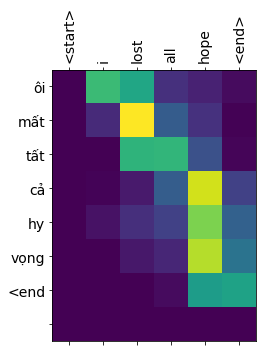


Input:  <start> at that moment i heard one mans voice ask me whats wrong <end>
Groundtruth:  <start> đúng vào lúc đó có một người đàn ông đã hỏi tôi có chuyện gì vậy <end>
Translation:  <start> trong khoảnh khắc tôi nghe một người hâm mộ của tôi hỏi tôi sai <end>
Bleu Score:  13.637416630347337

Input:  <start> i was so surprised that a total stranger cared enough to ask <end>
Groundtruth:  <start> tôi vô cùng ngạc nhiên khi một người hoàn toàn xa lạ lại quan tâm tới mức hỏi tôi như vậy <end>
Translation:  <start> tôi đã ngạc nhiên một điều về sự bình thường <end>
Bleu Score:  12.740017147566524

Input:  <start> in my broken english and with a dictionary i explained the situation and without hesitating the man went to the atm and he paid the rest of the money for my family and two other north koreans to get out of jail <end>
Groundtruth:  <start> bằng vốn tiếng anh ít ỏi của mình và một quyển từ điển tôi đã kể cho cho ông ta nghe hoàn cảnh của gia đình tôi không một chút do dự người đ

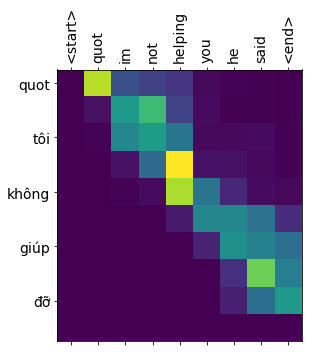


Input:  <start> quot im helping the north korean people <end>
Groundtruth:  <start> quot tôi đang giúp người bắc triều tiên <end>
Translation:  <start> quot tôi đã giúp đỡ người dân bắc <end>
Bleu Score:  38.50322886878713


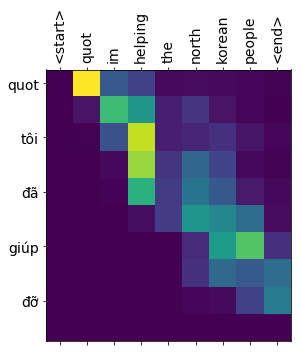


Input:  <start> i realized that this was a symbolic moment in my life <end>
Groundtruth:  <start> tôi nhận ra rằng đó là một khoảng khắc có ý nghĩa vô cùng to lớn trong cuộc đời tôi <end>
Translation:  <start> tôi nhận ra rằng đây là một khoảnh khắc về cuộc đời tôi <end>
Bleu Score:  41.544014564484456

Input:  <start> the kind stranger symbolized new hope for me and the north korean people when we needed it most and he showed me the kindness of strangers and the support of the international community are truly the rays of hope we north korean people need <end>
Groundtruth:  <start> lòng tốt từ người đàn ông xa lạ trở thành biểu tượng hy vọng mới cho tôi và cả những người dân bắc triều tiên khi mà chúng tôi đang rất cần nó và ông ta đã cho tôi thấy lòng tốt từ những người xa lạ và sự hỗ trợ của cộng đồng quốc tế chính là những tia hy vọng mà người bắc triều tiên chúng tôi đang tìm kiếm <end>
Translation:  <start> người lạ thường hiện đại học mới cho tôi và bắc triều tiên mà khi chúng 

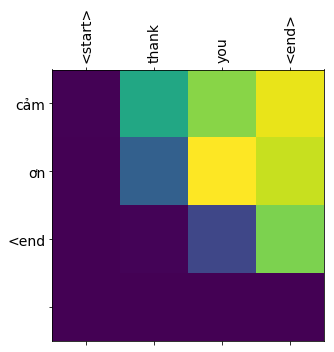


Input:  <start> today i have just one request <end>
Groundtruth:  <start> hôm nay tôi chỉ có một yêu cầu mà thôi <end>
Translation:  <start> hôm nay tôi chỉ là một lời yêu cầu <end>
Bleu Score:  50.618624217671794

Input:  <start> please dont tell me im normal <end>
Groundtruth:  <start> xin đừng nói với tôi rằng tôi bình thường <end>
Translation:  <start> đừng nói với tôi là tôi là bình thường <end>
Bleu Score:  50.3533788755586

Input:  <start> now id like to introduce you to my brothers <end>
Groundtruth:  <start> bây giờ tôi muốn giới thiệu các bạn với những người em trai của tôi <end>
Translation:  <start> bây giờ tôi muốn giới thiệu với các bạn <end>
Bleu Score:  47.00321119614957

Input:  <start> remi is 22 tall and very handsome <end>
Groundtruth:  <start> remi 22 tuổi cao ráo và rất đẹp trai <end>
Translation:  <start> những người 22 là rất đẹp <end>
Bleu Score:  19.320813030085752


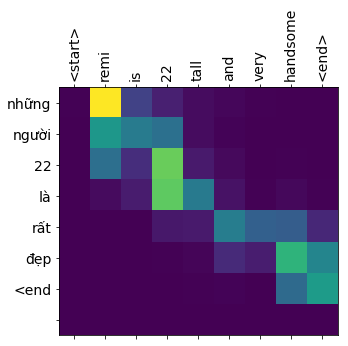


Input:  <start> hes speechless but he communicates joy in a way that some of the best orators cannot <end>
Groundtruth:  <start> em không nói được nhưng em truyền đạt niềm vui theo cách mà ngay cả một số nhà hùng biện giỏi nhất cũng không thể làm được <end>
Translation:  <start> anh ấy nói không nhưng ông ta sẽ phản hồi <end>
Bleu Score:  5.8555417352095676

Input:  <start> remi knows what love is <end>
Groundtruth:  <start> remi biết tình yêu là gì <end>
Translation:  <start> những người yêu thích gì <end>
Bleu Score:  32.03558799120807


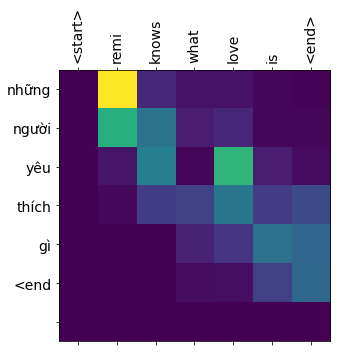


Input:  <start> he shares it unconditionally and he shares it regardless <end>
Groundtruth:  <start> em chia sẻ nó một cách vô điều kiện dù bất kể ra sao chăng nữa <end>
Translation:  <start> ông ấy chia sẻ nó một thứ và ông ấy chia sẻ nó bất cứ ai <end>
Bleu Score:  20.46592065585361

Input:  <start> hes not greedy he doesnt see skin color <end>
Groundtruth:  <start> em ấy không tham lam em không phân biệt màu da <end>
Translation:  <start> anh ấy không phải là người anh ta thấy da màu <end>
Bleu Score:  17.200673466668952

Input:  <start> he doesnt care about religious differences and get this he has never told a lie <end>
Groundtruth:  <start> em không quan tâm về sự khác biệt tôn giáo và hãy hiểu rằng em ấy chưa từng nói dối <end>
Translation:  <start> ông không quan tâm đến những sự khác biệt giới hạn và cả điều này anh ta không bao giờ nói dối <end>
Bleu Score:  24.601372576927545

Input:  <start> when he sings songs from our childhood attempting words that not even i could reme

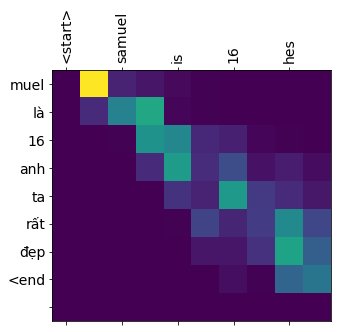


Input:  <start> he has the most impeccable memory <end>
Groundtruth:  <start> em có một trí nhớ cực hoàn hảo <end>
Translation:  <start> ông ta có những ký ức nhất <end>
Bleu Score:  18.61028050495244


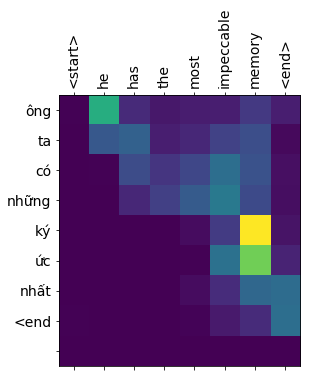


Input:  <start> he has a selective one though <end>
Groundtruth:  <start> nhưng cũng là có chọn lọc <end>
Translation:  <start> ông ấy có một động viên một cái gì đó <end>
Bleu Score:  15.911783110981522

Input:  <start> he doesnt remember if he stole my chocolate bar but he remembers the year of release for every song on my ipod conversations we had when he was four weeing on my arm on the first ever episode of teletubbies and lady gagas birthday <end>
Groundtruth:  <start> em không nhớ liệu em có xoáy thanh kẹo sô cô la của tôi không nhưng em lại nhớ năm phát hành của từng bài hát trên ipod của tôi các cuộc nói chuyện giữa chúng tôi từ em mới bốn tuổi tè lên tay của tôi vào ngày teletubbies lên sóng tập đầu tiên và sinh nhật của lady gaga <end>
Translation:  <start> ông ấy không nhớ nếu anh ta ăn cắp những thanh kẹo nhưng ông ấy nhớ nhưng năm qua đôi lúc đó một buổi diễn viên của tôi đã từng là khi anh ấy đã làm khi anh ấy đã làm khi anh ấy đã làm khi anh ấy đã làm khi anh ấy đã làm

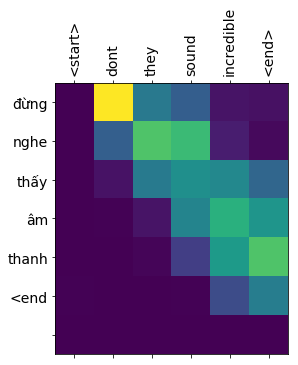


Input:  <start> but most people dont agree <end>
Groundtruth:  <start> nhưng hầu hết mọi người không đồng ý <end>
Translation:  <start> nhưng hầu hết mọi người không đồng ý <end>
Bleu Score:  100.00000000000004


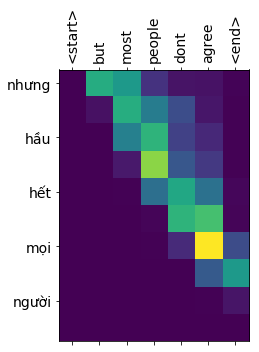


Input:  <start> and in fact because their minds dont fit into societys version of normal theyre often bypassed and misunderstood <end>
Groundtruth:  <start> và thực tế là vì tâm trí của các em tôi không phù hợp với phiên bản xã hội bình thường các em thường bị cho qua và hiểu lầm <end>
Translation:  <start> và thực tế bởi vì những người phụ thuộc của họ không thích hợp với những phiên bản của một cách chúng thường xuyên qua và nghe <end>
Bleu Score:  21.193036289162304

Input:  <start> but what lifted my heart and strengthened my soul was that even though this was the case although they were not seen as ordinary this could only mean one thing that they were extraordinary autistic and extraordinary <end>
Groundtruth:  <start> nhưng điều khiến trái tim tôi nhẹ nhõm hơn và tâm hồn tôi mạnh mẽ hơn là rằng mặc dù điều này là đúng dù các em không được coi là bình thường điều này chỉ có thể có nghĩa rằng các em thật phi thường người tự kỉ và người phi thường <end>
Translation:  <start> nhưng

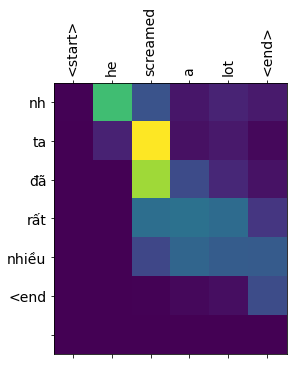


Input:  <start> he didnt want to play like the other babies did and in fact he didnt seem very interested in me whatsoever <end>
Groundtruth:  <start> em không muốn chơi đùa như các em bé khác và trong thực tế em có vẻ chẳng thích thú gì đến tôi hay điều gì khác hết <end>
Translation:  <start> anh ấy không muốn chơi như thế nữa những đứa trẻ khác và thực ra anh ta không hề quan tâm đến tôi <end>
Bleu Score:  11.21931862409635

Input:  <start> remi lived and reigned in his own world with his own rules and he found pleasure in the smallest things like lining up cars around the room and staring at the washing machine and eating anything that came in between <end>
Groundtruth:  <start> remi sống và ngự trị trong thế giới của riêng mình với quy tắc riêng của mình và em thấy niềm vui trong những điều nhỏ nhặt nhất như là xếp ô tô quanh phòng và nhìn chằm chằm vào cái máy giặt và ăn bất cứ thứ gì trong tầm tay <end>
Translation:  <start> những người sống và sống và trên mạng thế giới của anh

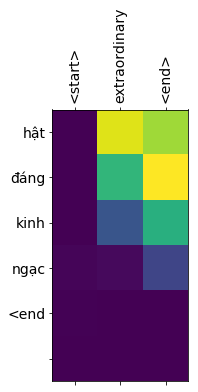


Input:  <start> now i cannot deny that there have been some challenging moments in my family moments where ive wished that they were just like me <end>
Groundtruth:  <start> chà tôi không thể phủ nhận rằng đã có một vài khoảnh khắc khó khăn trong gia đình tôi những khoảnh khắc tôi ước ao các em cũng giống như mình <end>
Translation:  <start> tôi không thể chối bỏ nó có một vài điều kiện thú vị trong những khoảnh khắc tôi trong thời gian tôi muốn tôi muốn nói <end>
Bleu Score:  16.475472029462896

Input:  <start> but i cast my mind back to the things that theyve taught me about individuality and communication and love and i realize that these are things that i wouldnt want to change with normality <end>
Groundtruth:  <start> nhưng tôi đưa kí ức mình quay trở lại những điều các em đã dạy tôi về tính cách lối giao tiếp và tình yêu và tôi nhận ra rằng đây là những điều mà tôi sẽ chẳng đánh đổi để lấy sự bình thường <end>
Translation:  <start> nhưng tôi mở rộng của tôi những điều mà họ đã 

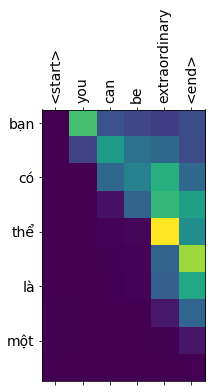


Input:  <start> because autistic or not the differences that we have weve got a gift everyones got a gift inside of us and in all honesty the pursuit of normality is the ultimate sacrifice of potential <end>
Groundtruth:  <start> vì có mắc chứng tự kỷ hay không sự khác biệt giữa chúng ta chúng ta có một món quà ai cũng mang trong mình một món quà và thật lòng mà nói theo đuổi cái bình thường chính là hi sinh tiềm năng lớn nhất <end>
Translation:  <start> bởi vì tự kỉ hoặc không phải là sự khác biệt mà chúng ta có một món quà tất cả những người đã có một món quà cho những người trong chúng ta và trong tất cả chúng ta đều là sự thay đổi <end>
Bleu Score:  19.51534588401618

Input:  <start> the chance for greatness for progress and for change dies the moment we try to be like someone else <end>
Groundtruth:  <start> cơ hội cho sự vĩ đại tiến bộ và cho sự thay đổi bị dập tắt khi ta cố gắng trở nên giống như một người khác <end>
Translation:  <start> cơ hội để tạo ra sự tiến bộ và thay đổi

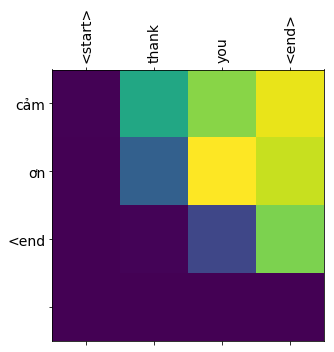


Input:  <start> you probably all agree with me that this is a very nice road <end>
Groundtruth:  <start> có lẽ các bạn đều đồng ý với tôi đây là một con đường rất đẹp <end>
Translation:  <start> bạn có thể đồng ý với tôi rằng đây là một con đường rất đẹp <end>
Bleu Score:  60.58171150004149

Input:  <start> its made of asphalt and asphalt is a very nice material to drive on but not always especially not on these days as today when its raining a lot <end>
Groundtruth:  <start> nó được xây dựng từ nhựa đường và nhựa đường là loại vật liệu xe mà chạy trên nó thì rất êm nhưng không phải lúc nào cũng được vậy đặc biệt không phải vào những ngày này như hôm nay khi trời đang mưa nhiều <end>
Translation:  <start> nó được tạo ra hàng trăm và nhựa và đường cong rất tốt để thực hiện nhưng không phải là không có trong ngày này ngày càng ngày nay nếu như mưa <end>
Bleu Score:  12.987138545874837

Input:  <start> then you can have a lot of splash water in the asphalt <end>
Groundtruth:  <start> rồi

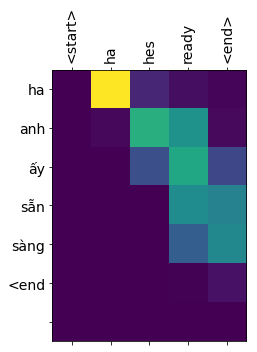


Input:  <start> potholes of course that can become a problem but we have a solution <end>
Groundtruth:  <start> ổ gà đương nhiên có thể trở thành một vấn đề nhưng chúng tôi có giải pháp <end>
Translation:  <start> một trong một trong một số đó có thể trở thành một vấn đề nhưng chúng ta có một giải pháp <end>
Bleu Score:  47.901455811287484

Input:  <start> here you see actually how the damage appears in this material <end>
Groundtruth:  <start> thật sự như bạn thấy ở đây vật liệu này có dấu hiệu bị hư hại ra sao <end>
Translation:  <start> đây bạn biết đấy điều này là sự nguy hiểm này có thể hiện tại đây <end>
Bleu Score:  12.14794907876506

Input:  <start> its a porous asphalt like i said so you have only a small amount of binder between the stones <end>
Groundtruth:  <start> nó là nhựa xốp như tôi đã nói bạn chỉ có một lượng nhỏ keo dính bám giữa các viên đá <end>
Translation:  <start> nó là một đường hầm giống như tôi nói vậy nên bạn có một lượng nhỏ của một cái kim loại màu xanh <

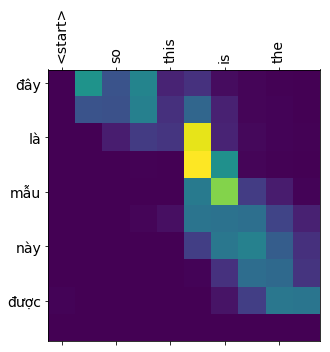


Input:  <start> so i said we have such an industrial machine in the lab to heat up the specimens <end>
Groundtruth:  <start> tôi đã nói chúng tôi phát minh ra một cái máy công nghiệp như trên tại phòng thí nghiệm để đun nóng các vật mẫu <end>
Translation:  <start> tôi nói chúng tôi có một công nghiệp công nghệ trong phòng thí nghiệm để làm ra các mẫu <end>
Bleu Score:  28.235892296674766

Input:  <start> we tested a lot of specimens there and then the government they actually saw our results and they thought well thats very interesting we have to try that <end>
Groundtruth:  <start> tại phòng thí nghiệm chúng tôi đã thử qua nhiều mẫu và rồi chính phủ họ đã thực sự nhìn thấy kết quả và họ cho rằng à cách đó hay lắm chúng ta phải thử xem sao <end>
Translation:  <start> chúng tôi đã thử nghiệm nhiều mẫu và sau đó chính phủ chúng tôi đã thấy rằng kết quả của chúng và chúng tôi nghĩ rằng đó thật thú vị chúng tôi phải cố gắng thử thách <end>
Bleu Score:  14.48250673669076

Input:  <start> s

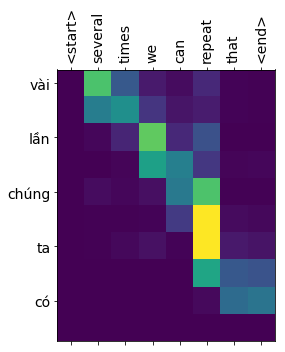


Input:  <start> so actually the conclusion from this research is that if we go on the road every four years with our healing machine this is the big version we have made to go on the real road if we go on the road every four years we can double the surface life of this road which of course saves a lot of money <end>
Groundtruth:  <start> và thật sự kết luận đưa ra từ nghiên cứu này là nếu chúng tôi bảo dưỡng con đường 4 năm một lần bằng máy hàn gắn đây là phiên bản kích thước lớn chúng tôi đã chế tạo nó để bảo dưỡng đường thật nếu cứ 4 năm chúng tôi bảo dưỡng con đường một lần thì chúng tôi có thể làm tăng gấp đôi tuổi thọ lớp mặt của con đường dĩ nhiên sẽ tiết kiệm được nhiều tiền <end>
Translation:  <start> trong bốn năm tới với việc phục vụ máy móc này là chúng tôi đã làm được thực hiện thực hiện tại nơi mà chúng ta có thể gấp đôi mắt <end>
Bleu Score:  2.9576290924115454

Input:  <start> well to conclude i can say that we made a material using steel fibers the addition of steel fi

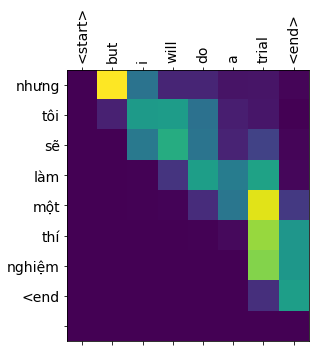


Input:  <start> lets see yeah it worked <end>
Groundtruth:  <start> xem nè vâng nó dính <end>
Translation:  <start> hãy xem ồ nó đã làm việc <end>
Bleu Score:  20.78060434846712


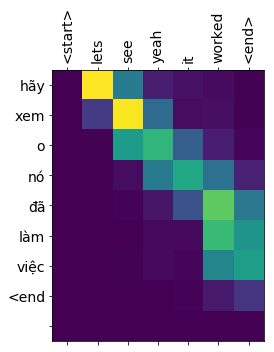


Input:  <start> thank you <end>
Groundtruth:  <start> xin cám ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  44.12484512922978


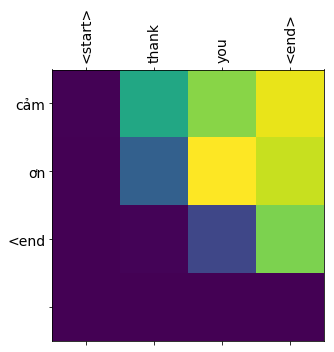


Input:  <start> im here today to talk about a disturbing question which has an equally disturbing answer <end>
Groundtruth:  <start> hôm nay tôi đến đây để nói về một câu hỏi bối rối mà câu trả lời cũng gấy bối rối không kém <end>
Translation:  <start> tôi ở đây hôm nay để nói về một câu hỏi một câu trả lời nói một câu trả lời hứa hẹn <end>
Bleu Score:  30.315813745925173

Input:  <start> my topic is the secrets of domestic violence and the question im going to tackle is the one question everyone always asks why does she stay <end>
Groundtruth:  <start> chủ đề là bí mật của bạo lực gia đình và câu hỏi tôi đặt ra là câu hỏi mà mọi người luôn thắc mắc tại sao cô ấy ở lại <end>
Translation:  <start> chủ đề của tôi là bí mật của bạo lực và những câu hỏi tôi sẽ phải giải quyết là một câu hỏi mọi người đều hỏi tại sao cô ấy nói vậy tại sao cô ấy nói vậy tại sao cô ấy nói vậy tại sao cô ấy nói vậy tại sao cô ấy nói vậy tại sao cô
Bleu Score:  20.036289016118406

Input:  <start> why would any

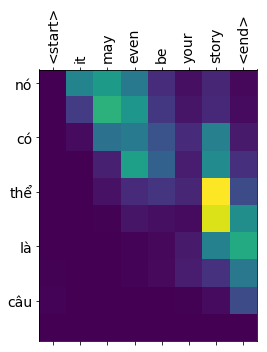


Input:  <start> i dont look like a typical domestic violence survivor <end>
Groundtruth:  <start> tôi không giống môt nhà tư vấn bạo lực gia đình <end>
Translation:  <start> tôi không nhìn như một cuộc chiến dịch dân số sống sót <end>
Bleu Score:  26.89054715066592

Input:  <start> i have a b a in english from harvard college an mba in marketing from wharton business school <end>
Groundtruth:  <start> tôi có bằng cử nhân tiếng anh từ trường cao đẳng harvard và quản trị kinh doanh marketing từ trường kinh doanh wharton <end>
Translation:  <start> tôi có một tiếng anh ở trường đại học harvard business school of ultrasound in từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ trường đại học từ
Bleu Score:  7.705561713247027

Input:  <start> ive spent most of my career working for fortune 500 companies including johnson amp amp johnson leo burnett and the was

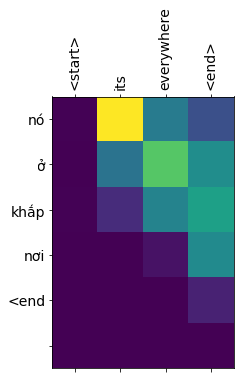


Input:  <start> and my second message is that everyone thinks domestic violence happens to women that its a womens issue <end>
Groundtruth:  <start> và điều thứ hai tôi muốn nói là mọi người nghĩ rằng bạo lực gia đình xảy ra với phụ nữ đó là vấn đề của phụ nữ <end>
Translation:  <start> và thứ hai của tôi là những người nghĩ rằng những người dân số người dân số mọi người phụ nữ là điều trị của phụ nữ <end>
Bleu Score:  29.153040810656083

Input:  <start> not exactly <end>
Groundtruth:  <start> không đúng <end>
Translation:  <start> không phải là gì <end>
Bleu Score:  37.99178428257963


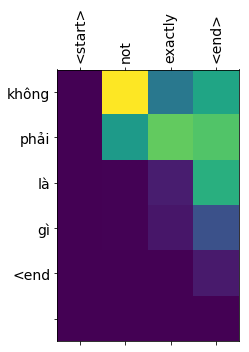


Input:  <start> over 85 percent of abusers are men and domestic abuse happens only in intimate interdependent long term relationships in other words in families the last place we would want or expect to find violence which is one reason domestic abuse is so confusing <end>
Groundtruth:  <start> hơn 85 phần trăm kẻ bạo hành là đàn ông và bạo lực gia đình xảy ra chỉ trong những mối quan hệ thân thiết ràng buộc lâu dài nói cách khác là trong gia đình nơi cuối cùng chúng ta mong muốn hoặc trông chờ tìn thấy bạo lực đó là một lí do khiến bạo hành gia đình là vấn đề gây bối rối <end>
Translation:  <start> hơn 75 người đàn ông và những người bị bắt đầu với sự phụ thuộc lẫn nhau trong những người trong những gia đình trong thời điểm của những gia đình chúng ta muốn hoặc là điều trị <end>
Bleu Score:  7.100814935021791

Input:  <start> i would have told you myself that i was the last person on earth who would stay with a man who beats me but in fact i was a very typical victim because of my ag

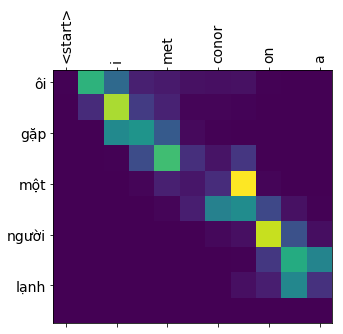


Input:  <start> he sat next to me on the new york city subway and he started chatting me up <end>
Groundtruth:  <start> anh ta ngồi cạnh tôi trong đường hầm thành phố new york và anh bắt chuyện với tôi <end>
Translation:  <start> ông ngồi cạnh tôi vào new york và anh ta bắt đầu tôi <end>
Bleu Score:  29.83573247745783

Input:  <start> he told me two things <end>
Groundtruth:  <start> anh ta kể với tôi về hai thứ <end>
Translation:  <start> ông ấy nói với hai điều <end>
Bleu Score:  19.284170861795207


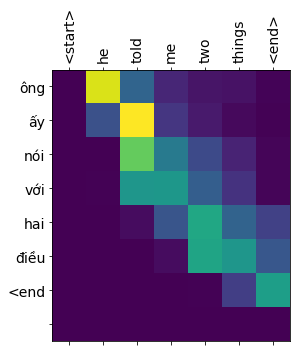


Input:  <start> one was that he too had just graduated from an ivy league school and that he worked at a very impressive wall street bank <end>
Groundtruth:  <start> một là anh ta cũng như tôi vừa tốt nghiệp trường ivy league và rằng anh ta làm việc tại một ngân hàng rất ấn tượng ở phố wall <end>
Translation:  <start> một là một anh ta vẫn còn tốt nghiệp từ một chiến binh chiến tranh và anh ấy đã làm việc ở ấn tượng ở đại dương <end>
Bleu Score:  20.476139319585826

Input:  <start> but what made the biggest impression on me that first meeting was that he was smart and funny and he looked like a farm boy <end>
Groundtruth:  <start> nhưng điều gây ấn tương nhất với tôi ở cuộc gặp gỡ đầu tiên là anh ta thông minh là vui tính và trông anh ta có vẻ một cậu nhóc nông dân <end>
Translation:  <start> nhưng điều đáng kinh ngạc nhất trong tôi đã từng đầu tiên là anh ta là thông minh và cười và anh ta trông giống như một nhà tù <end>
Bleu Score:  24.979308023244

Input:  <start> he had these big

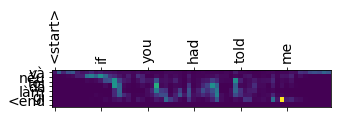


Input:  <start> i didnt know that the first stage in any domestic violence relationship is to seduce and charm the victim <end>
Groundtruth:  <start> tôi đã không biết rằng giai đoạn đầu tiên trong bất kì mối quan hệ bạo lực gia đình là cám dỗ và quyến rũ nạn nhân <end>
Translation:  <start> tôi không biết điều đầu tiên trong cuộc đối với bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ bất kỳ
Bleu Score:  5.956824364054717

Input:  <start> i also didnt know that the second step is to isolate the victim <end>
Groundtruth:  <start> tôi cũng không biết rằng giai đoạn thứ hai là cô lập nạn nhân <end>
Translation:  <start> tôi cũng không biết đến thứ hai là để có khả năng của nạn nhân <end>
Bleu Score:  51.0032342952127

Input:  <start> now conor did not come home one day and announce you know hey all this romeo and juliet stuff has been great but i need to move into the 

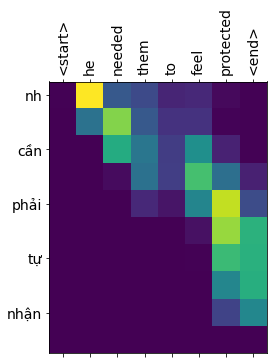


Input:  <start> but those guns were really a message for me and even though he hadnt raised a hand to me my life was already in grave danger every minute of every day <end>
Groundtruth:  <start> nhưng những cây súng này thật ra là một lời nhắn cho tôi và mặc dù anh ta chưa đưa cánh tay về phía tôi nhưng cuộc sống của tôi ở trong tình thế nguy hiểm từng phút mỗi ngày <end>
Translation:  <start> nhưng những con sư tử thực sự là một thông điệp cho tôi và thậm chí không có được một tay để tôi đã bị ám ảnh hưởng đến nỗi đau đớn mỗi ngày <end>
Bleu Score:  19.025157353462415

Input:  <start> conor first physically attacked me five days before our wedding <end>
Groundtruth:  <start> conor đã tấn công vào tôi năm ngày trước đám cưới của chúng tôi <end>
Translation:  <start> thứ nhất định bị thương mại tôi đã mất 5 ngày trước khi đám cưới của mình <end>
Bleu Score:  15.919638844359847

Input:  <start> it was 7 a m i still had on my nightgown <end>
Groundtruth:  <start> đó là lúc 7 giờ sáng khi

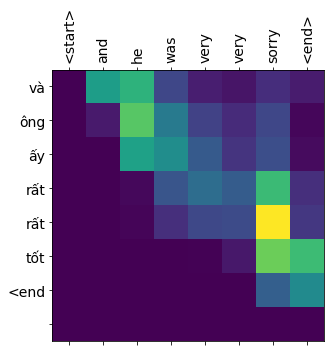


Input:  <start> he had just been really stressed out by the wedding and by becoming a family with me <end>
Groundtruth:  <start> anh ta đã thật sự rất căng thẳng vì đám cưới và việc lập gia đình với tôi <end>
Translation:  <start> ông ấy đã thực sự bị đánh giá bởi vì đám cưới và kết thúc một gia đình tôi <end>
Bleu Score:  25.823077599534503

Input:  <start> it was an isolated incident and he was never going to hurt me again <end>
Groundtruth:  <start> đó là môt sự cố cá biệt và anh ta sẽ không bao giờ làm đau tôi nữa <end>
Translation:  <start> đó là một người cố gắng và không bao giờ làm được gì nữa <end>
Bleu Score:  35.692516622233654

Input:  <start> it happened twice more on the honeymoon <end>
Groundtruth:  <start> nó đã xảy ra thêm hai lần trong tuần trăng mật <end>
Translation:  <start> nó đã xảy ra gấp đôi chân dung <end>
Bleu Score:  42.91418549698786


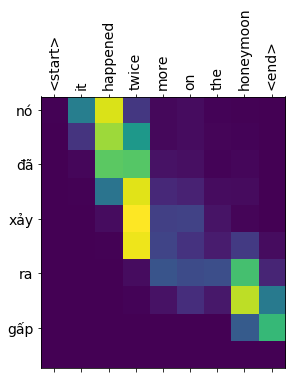


Input:  <start> the first time i was driving to find a secret beach and i got lost and he punched me in the side of my head so hard that the other side of my head repeatedly hit the drivers side window <end>
Groundtruth:  <start> lần đầu tiên tôi đang lái xe để tìm một bãi biển bí mật và tôi bị lạc anh ta đánh vào một bên đầu tôi rất mạnh khiến đầu tôi liên tục đập vào cửa kính của xe <end>
Translation:  <start> lần đầu tiên tôi đang lái xe tải về phía nam và tôi đã mất đi và tôi đã bị bắn tôi trong khi tôi trong tay của tôi và điều đó là một trong tay của tôi đi vào cửa sổ <end>
Bleu Score:  24.92294077468114

Input:  <start> and then a few days later driving home from our honeymoon he got frustrated by traffic and he threw a cold big mac in my face <end>
Groundtruth:  <start> vài ngày sau đó khi đang lái xe về nhà sau tuần trăng mật anh ta mệt mỏi vì xe cộ và anh ta ném cả túi thức ăn big mac vào mặt tôi <end>
Translation:  <start> và sau đó một ngày sau khi đi về nhà của chúng tôi 

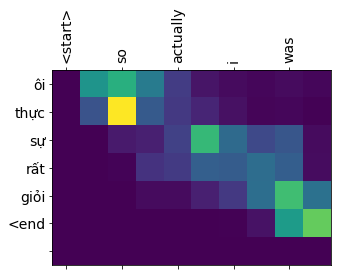


Input:  <start> back to my question why did i stay <end>
Groundtruth:  <start> trở lại câu hỏi của tôi tại sao tôi ở lại <end>
Translation:  <start> quay lại câu hỏi tại sao tôi lại <end>
Bleu Score:  31.88339307881512


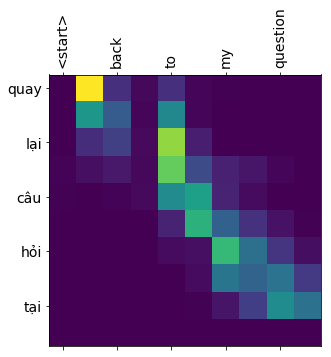


Input:  <start> the answer is easy <end>
Groundtruth:  <start> câu trả lời rất dễ <end>
Translation:  <start> câu trả lời là dễ dàng <end>
Bleu Score:  54.52469119630866


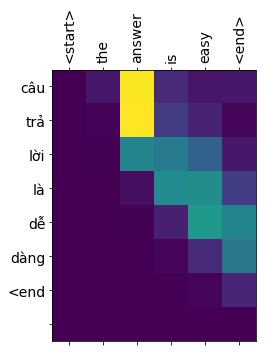


Input:  <start> i didnt know he was abusing me <end>
Groundtruth:  <start> tôi không biết anh ta đang bạo hành tôi <end>
Translation:  <start> tôi không biết anh ta là người phụ nữ tôi <end>
Bleu Score:  60.26080978557135

Input:  <start> even though he held those loaded guns to my head pushed me down stairs threatened to kill our dog pulled the key out of the car ignition as i drove down the highway poured coffee grinds on my head as i dressed for a job interview i never once thought of myself as a battered wife <end>
Groundtruth:  <start> thậm chí anh ta chĩa súng vào đầu tôi đẩy tôi xuống sàn đe doạ giết lũ chó của tôi rút chìa khoá ra khỏi xe khi tôi đang lái xe vào đường cao tốc đổ grinds cafe lên đầu tôi khi tôi đang mặc đồ cho buổi phỏng vấn tôi chưa bao giờ một lần nghĩ bản thân như một người vợ bị hành hạ <end>
Translation:  <start> thậm chí ông ấy đã bị đánh răng súng để lấy tôi xuống đáy tôi sẽ lên xuống cánh tay bị đe doạ giết chết con chó của chúng tôi lấy lại những chiếc

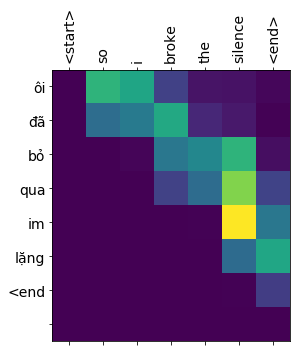


Input:  <start> i told everyone the police my neighbors my friends and family total strangers and im here today because you all helped me <end>
Groundtruth:  <start> tôi kể với mọi người cánh sát những người láng giềng bạn bè và gia đình tôi những người hoàn toàn xa lạ và tôi đứng đây hôm nay bởi vì bạn đều đang giúp tôi <end>
Translation:  <start> tôi đã kể cho mọi người cảnh sát hàng xóm của gia đình bạn bè và gia đình tôi và tôi ở đây vì bạn đều đã giúp tôi <end>
Bleu Score:  30.436253606390526

Input:  <start> we tend to stereotype victims as grisly headlines self destructive women damaged goods <end>
Groundtruth:  <start> chúng ta có quan niệm rập khuôn về nạn nhân như những tiêu đề đáng sợ những phụ nữ tự huỷ hoại mình những điều tốt bị làm tổn thương <end>
Translation:  <start> chúng ta có khuynh hướng hiến nạn nhân chủng tộc nghèo đói kém cỏi gây rối loạn <end>
Bleu Score:  15.952279006399786

Input:  <start> the question why does she stay <end>
Groundtruth:  <start> câu hỏi t

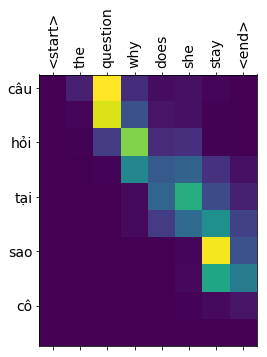


Input:  <start> is code for some people for its her fault for staying as if victims intentionally choose to fall in love with men intent upon destroying us <end>
Groundtruth:  <start> là lí lẽ của một số người đấy là lỗi của cô ấy khi ở lại như thể nạn nhân đã lựa chọn yêu đàn ông với ý định phá huỷ chúng ta <end>
Translation:  <start> mã mã cho một số người cho nó cho phép nó trong khi đang thiếu niên <end>
Bleu Score:  6.948051738571797

Input:  <start> but since publishing crazy love i have heard hundreds of stories from men and women who also got out who learned an invaluable life lesson from what happened and who rebuilt lives joyous happy lives as employees wives and mothers lives completely free of violence like me <end>
Groundtruth:  <start> nhưng từ khi xuất bản crazy love tôi đã nghe hàng trăm câu chuyện từ đàn ông và phụ nữ những người cũng đã bỏ đi những người học được một bài học cuộc sống vô giá từ nhưng điều đã xảy ra và những ai xây dựng lại cuộc sống hạnh phúc vui vẻ 

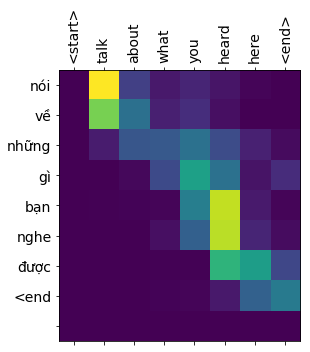


Input:  <start> abuse thrives only in silence <end>
Groundtruth:  <start> sự ngược đãi chỉ đáng sợ trong im lặng <end>
Translation:  <start> lạm dụng năng lượng không chỉ là sự im lặng <end>
Bleu Score:  32.37722713145643

Input:  <start> you have the power to end domestic violence simply by shining a spotlight on it <end>
Groundtruth:  <start> bạn có sức mạnh để kết thúc bạo lực gia đình đơn giản bằng cách rọi vào đó một tia sáng <end>
Translation:  <start> bạn có quyền lực để trở thành những kẻ bạo lực như một cách nhìn thấy một bộ phim về mặt trời <end>
Bleu Score:  19.61887304255142

Input:  <start> we victims need everyone <end>
Groundtruth:  <start> chúng ta những nạn nhân cần đến tất cả mọi người <end>
Translation:  <start> chúng ta nợ nạn nhân cần tất cả mọi người <end>
Bleu Score:  64.52121005104219

Input:  <start> we need every one of you to understand the secrets of domestic violence <end>
Groundtruth:  <start> chúng ta cần các bạn để thấu hiểu bí mật của bạo lực gia đình 

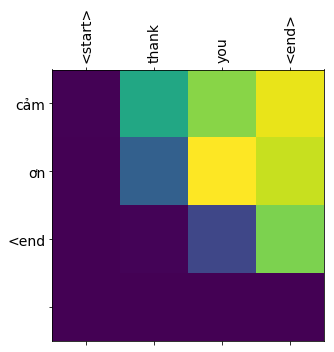


Input:  <start> i would like to talk to you about a very special group of animals <end>
Groundtruth:  <start> tôi muốn nói chuyện với các bạn về một nhóm động vật rất đặc biệt <end>
Translation:  <start> tôi muốn nói với các bạn về một nhóm đặc biệt <end>
Bleu Score:  61.50082203371956

Input:  <start> there are 10 000 species of birds in the world <end>
Groundtruth:  <start> hiện có khoảng 10 000 loài chim trên thế giới <end>
Translation:  <start> có 10 000 loài chim trong thế giới <end>
Bleu Score:  47.169491349409164


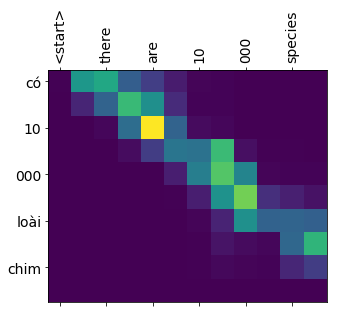


Input:  <start> vultures are amongst the most threatened group of birds <end>
Groundtruth:  <start> kền kền là một trong những nhóm chim bị đe doạ nghiêm trọng nhất <end>
Translation:  <start> những con số là những người bị đe doạ lớn nhất của những con chim <end>
Bleu Score:  16.893810421616948

Input:  <start> when you see a vulture like this the first thing that comes to your mind is these are disgusting ugly greedy creatures that are just after your flesh associated with politicians <end>
Groundtruth:  <start> khi bạn thấy một con kền lền như thế này điều đầu tiên hiện ra trong đầu bạn đó là đây là những sinh vật thật kinh tởm xấu xí tham ăn và chỉ nhắm đến thịt bạn liên tưởng đến những chính trị gia nhỉ <end>
Translation:  <start> khi bạn thấy một cuộc sống như thế này lần đầu tiên mà nó sẽ là điều này thật đáng sợ hãi những người vô cùng mà chúng ta có thể tự động của anh <end>
Bleu Score:  16.938893391748437

Input:  <start> i want to change that perception i want to change tho

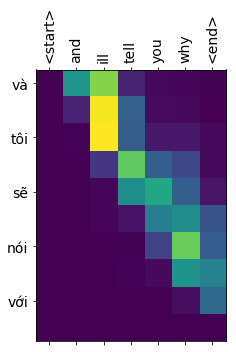


Input:  <start> first of all why do they have such a bad press <end>
Groundtruth:  <start> trước tiên tại sao chúng lại có ấn tượng xấu như vậy <end>
Translation:  <start> đầu tiên tại sao họ lại có một món quà <end>
Bleu Score:  20.011886377147505

Input:  <start> when charles darwin went across the atlantic in 1832 on the beagle he saw the turkey vulture and he said these are disgusting birds with bald scarlet heads that are formed to revel in putridity <end>
Groundtruth:  <start> khi charles darwin vượt qua thái bình dương năm 1832 từ tàu beagle ông thấy những con kền kền thổ nhĩ kỳ ông nói những con chim này thật kinh tởm với cái đầu trọc đỏ chói được tạo ra để hoan hỉ trong hôi thối <end>
Translation:  <start> khi charles darwin đã qua khắp đại tây dương ở vùng vịnh ông ấy đã thấy những con chim cánh cụt và ông nói rằng đây là những con chim nhại lại với những con chim cánh cụt bị bắt đầu bị đánh giá được <end>
Bleu Score:  17.28909026257064

Input:  <start> you could not get a w

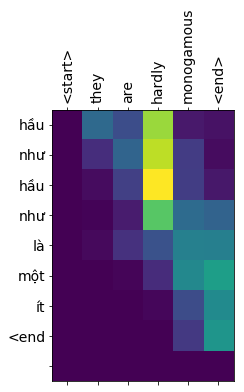


Input:  <start> they are far from being extinct <end>
Groundtruth:  <start> họ còn lâu mới bị tuyệt chủng <end>
Translation:  <start> chúng ở đây là rất tuyệt chủng <end>
Bleu Score:  38.67706276352344


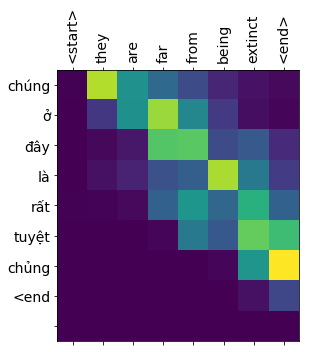


Input:  <start> and my favorite is vultures are better looking <end>
Groundtruth:  <start> và điều mà tôi thích nhất là những con kền kền trông được hơn nhiều <end>
Translation:  <start> và tôi yêu thích của tôi là tốt hơn <end>
Bleu Score:  17.857358603526453

Input:  <start> so theres two types of vultures in this planet <end>
Groundtruth:  <start> có hai loại kền kền trên hành tinh này <end>
Translation:  <start> có hai loại protein này trên hành tinh này <end>
Bleu Score:  72.41577342575832

Input:  <start> there are the new world vultures that are mainly found in the americas like the condors and the caracaras and then the old world vultures where we have 16 species from these 16 11 of them are facing a high risk of extinction <end>
Groundtruth:  <start> những loại kền kền tân thế giới được tìm thấy chủ yếu tại mỹ giống như loài condor và caracaras tiếp đó kền kền cựu thế giới nơi mà có khoảng 16 loài trong số 16 loài này thì có 11 loài đối mặt với nguy cơ tuyệt chủng cao <end>
T

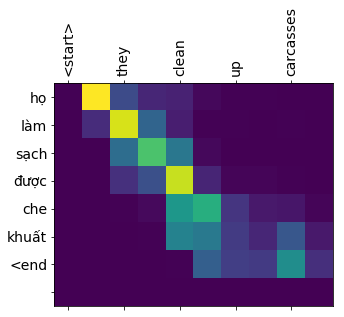


Input:  <start> they help to kill all the bacteria they help absorb anthrax that would otherwise spread and cause huge livestock losses and diseases in other animals <end>
Groundtruth:  <start> chúng giúp tiêu diệt vi khuẩn chúng giúp hấp thụ bệnh than mà đã có thể lan rộng và gây ra những mất mát to lớn cho ngành chăn nuôi gia súc và gây bệnh cho những loài vật khác <end>
Translation:  <start> họ giúp đỡ giết chúng ta phân tích các bệnh viện bảo vệ những bệnh viện sẽ không thể lan toả và gây ra những con gấu cực kỳ và những con cá mập và những con cá mập và những con cá mập và những con cá mập và những con cá mập và những con cá mập và
Bleu Score:  6.592309822529722

Input:  <start> recent studies have shown that in areas where there are no vultures carcasses take up to three to four times to decompose and this has huge ramifications for the spread of diseases <end>
Groundtruth:  <start> những nghiên cứu gần nhất đã cho thấy tại những khu vực mà không có kền kền xác chết cần khoảng t

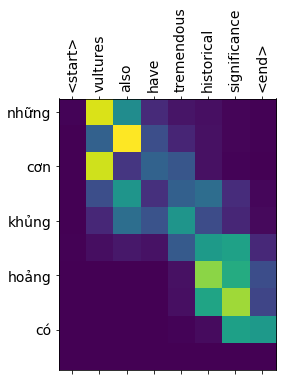


Input:  <start> they have been associated in ancient egyptian culture <end>
Groundtruth:  <start> chúng đã được kết liên với nền văn hoá ai cập cổ đại <end>
Translation:  <start> họ đã có liên quan đến những người dân chủ <end>
Bleu Score:  13.639128522792753

Input:  <start> nekhbet was the symbol of the protector and the motherhood and together with the cobra symbolized the unity between upper and lower egypt <end>
Groundtruth:  <start> nekhbet là biểu tượng của người bảo vệ và tình mẹ và cùng với rắn hổ mang chúng biểu tượng hoá cho sự hợp nhất giữa miền ngược amp amp miền xuôi của ai cập <end>
Translation:  <start> có phải là biểu tượng của người bảo vệ và với nhau và với nhau với nhau <end>
Bleu Score:  19.505656637595198

Input:  <start> in hindu mythology jatayu was the vulture god and he risked his life in order to save the goddess sita from the 10 headed demon ravana <end>
Groundtruth:  <start> trong thần thoại hindu jatayu là thần kền kền ông đã mạo hiểm mạng sống để cứu nữ 

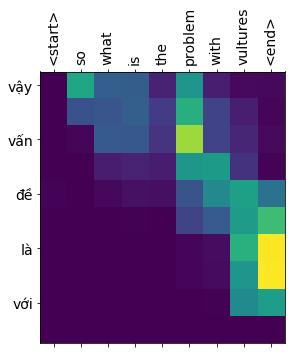


Input:  <start> we have eight species of vultures that occur in kenya of which six are highly threatened with extinction <end>
Groundtruth:  <start> chúng ta có 8 loài kền kền xuất hiện tại kenya trong đó có 6 loài bị đe doạ với nguy cơ tuyệt chủng cao <end>
Translation:  <start> chúng ta có 8 loài cá mập khổng lồ ở kenya có 6 triệu chứng <end>
Bleu Score:  26.694591216859216

Input:  <start> the reason is that theyre getting poisoned and the reason that theyre getting poisoned is because theres human wildlife conflicts the pastoral communities are using this poison to target predators and in return the vultures are falling victim to this <end>
Groundtruth:  <start> lí do là chúng đang bị đầu độc chúng bị đầu độc vì có những sự tranh giành giữa con người và thế giới hoang dã những cộng đồng mục đồng đang sử dụng chất độc này để nhằm vào các con vật săn mồi nhưng thay vì vậy những con kền kền lại là nạn nhân cho này <end>
Translation:  <start> lý do mà chúng được coi là người và những 

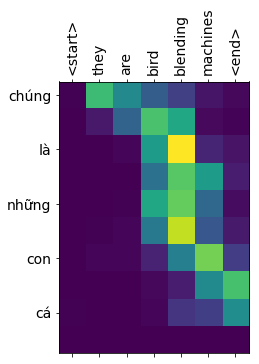


Input:  <start> in west africa theres a horrific trade of dead vultures to serve the witchcraft and the fetish market <end>
Groundtruth:  <start> tại tây phi có một ngành buôn bán kền kền chết thật kinh khủng để phục vụ cho thị trường ma thuật và bùa ngải <end>
Translation:  <start> ở tây châu phi có một chiến dịch bại liệt từ những cơn đau đớn để phục hồi và sự bất kỳ thị trường <end>
Bleu Score:  12.440315122990095

Input:  <start> so whats being done well were conducting research on these birds were putting transmitters on them <end>
Groundtruth:  <start> vậy chúng tôi đã làm được gì chúng tôi đang tiến hành nghiên cứu về những chú chim này chúng tôi đang gắn máy phát tín hiệu vào chúng <end>
Translation:  <start> vậy thì điều đã được làm là nghiên cứu về những con chim này được cung ứng với họ <end>
Bleu Score:  17.591277858863545

Input:  <start> were trying to determine their basic ecology and see where they go <end>
Groundtruth:  <start> chúng tôi đang cố gắng xác định sinh thá

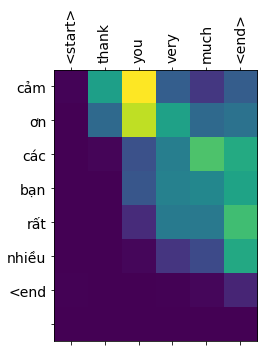


Input:  <start> when i was 11 i remember waking up one morning to the sound of joy in my house <end>
Groundtruth:  <start> khi tôi 11 tuổi tôi nhớ một buổi sáng tôi thức dậy khi nghe tiếng hân hoan trong căn nhà của tôi <end>
Translation:  <start> khi tôi 11 tôi nhớ tỉnh dậy một câu chuyện về âm thanh của tôi <end>
Bleu Score:  31.329693735146805

Input:  <start> my father was listening to bbc news on his small gray radio <end>
Groundtruth:  <start> bố tôi lúc ấy đang nghe tin tức bbc trên chiếc radio màu xám nhỏ của ông ấy <end>
Translation:  <start> bố tôi là nghe nói tiếng nói với một câu chuyện với một cái hố đen của nó <end>
Bleu Score:  20.828838183973037

Input:  <start> there was a big smile on his face which was unusual then because the news mostly depressed him <end>
Groundtruth:  <start> ông ấy nở một nụ cười rất lớn điều này rất bất thường vì tin tức thường làm ông ấy buồn rầu hơn <end>
Translation:  <start> có một nụ cười theo hướng về mặt của bạn biết được rồi vì những t

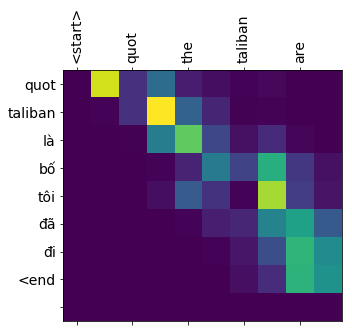


Input:  <start> i didnt know what it meant but i could see that my father was very very happy <end>
Groundtruth:  <start> lúc đó tôi không hiểu rõ nhưng tôi có thể thấy rằng bố tôi rất rất vui mừng <end>
Translation:  <start> tôi không biết điều đó là tôi có thể thấy rằng bố tôi rất rất vui <end>
Bleu Score:  52.10833656670608

Input:  <start> quot you can go to a real school now he said <end>
Groundtruth:  <start> quot bây giờ con có thể thật sự đến trường rồi ông nói <end>
Translation:  <start> quot bạn có thể đi học trường học anh ta nói <end>
Bleu Score:  28.648682864686602

Input:  <start> a morning that i will never forget <end>
Groundtruth:  <start> một buổi sáng mà tôi không thể nào quên được <end>
Translation:  <start> một buổi sáng không bao giờ quên <end>
Bleu Score:  40.438437976330746


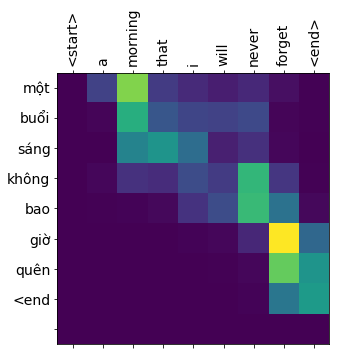


Input:  <start> a real school <end>
Groundtruth:  <start> một ngôi trường thật sự <end>
Translation:  <start> trường học <end>
Bleu Score:  24.694586397773897


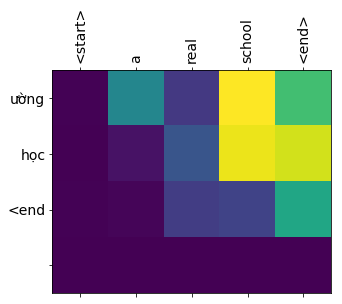


Input:  <start> you see i was six when the taliban took over afghanistan and made it illegal for girls to go to school <end>
Groundtruth:  <start> bạn biết không bọn taliban đến xâm lấn afghanistan từ khi tôi 6 tuổi và ngăn cấm các cô gái đi học <end>
Translation:  <start> bạn thấy tôi là 6 tuổi khi taliban đã chết về nhà nước mỹ và làm nó là những gì cho những người phụ nữ để đi học <end>
Bleu Score:  20.0535836535127

Input:  <start> so for the next five years i dressed as a boy to escort my older sister who was no longer allowed to be outside alone to a secret school <end>
Groundtruth:  <start> trong 5 năm sau đó tôi đã ăn mặc như 1 thằng con trai để đi cùng với chị tôi tới một trường bí mật vì chị tôi bị cấm ra khỏi nhà môt mình <end>
Translation:  <start> vì thế 5 năm tôi mặc dù một cậu bé trai tôi có thể tôi đã không bao giờ được phép ở bên trong một phòng thí nghiệm <end>
Bleu Score:  7.963616557158675

Input:  <start> it was the only way we both could be educated <end>
Groundt

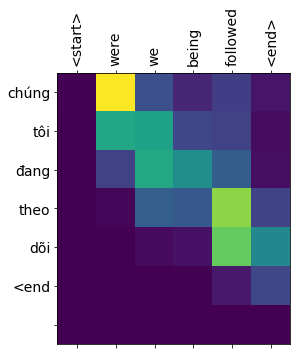


Input:  <start> do they know where we live <end>
Groundtruth:  <start> họ có biết chỗ chúng tôi ở không <end>
Translation:  <start> họ biết rằng chúng ta sống <end>
Bleu Score:  27.637383080309554


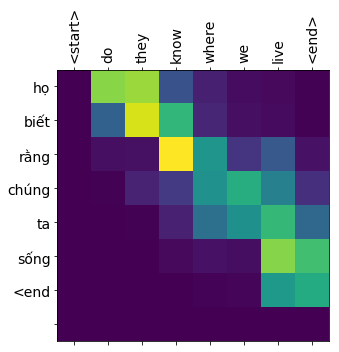


Input:  <start> we were scared but still school was where we wanted to be <end>
Groundtruth:  <start> chúng tôi đã rất sợ nhưng dù vậy chúng tôi vẫn muốn tới trường <end>
Translation:  <start> chúng tôi sợ hãi nhưng vẫn còn là trường mà chúng tôi muốn <end>
Bleu Score:  29.245797237328706

Input:  <start> i was very lucky to grow up in a family where education was prized and daughters were treasured <end>
Groundtruth:  <start> tôi rất may mắn được nuôi dạy trong một gia đình rất trân trọng việc học và con gái được quý trọng <end>
Translation:  <start> tôi đã rất may mắn để phát triển trong gia đình mà giáo dục và giáo viên <end>
Bleu Score:  17.240811667397534

Input:  <start> my grandfather was an extraordinary man for his time <end>
Groundtruth:  <start> ông ngoại của tôi là một người thật đáng khâm phục vào thời ấy <end>
Translation:  <start> ông tôi là một người đàn ông là một người đàn ông là một người đàn ông là một người đàn ông là một người đàn ông là một người đàn ông là một 

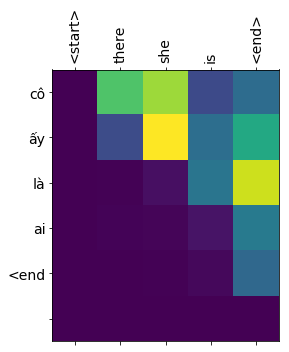


Input:  <start> she retired two years ago only to turn our house into a school for girls and women in our neighborhood <end>
Groundtruth:  <start> bà nghỉ hưu 2 năm về trước để dùng nhà của chúng tôi để mở trường cho bé gái và phụ nữ trong hàng xóm <end>
Translation:  <start> cô ấy đã đến một vài năm trước chỉ có thể quay lại nhà của mình vào một trường cho các bé gái và phụ nữ và người phụ nữ <end>
Bleu Score:  18.621788074015146

Input:  <start> and my father thats him he was the first ever in his family to receive an education <end>
Groundtruth:  <start> và đây là bố của tôi ông là người đầu tiên trong gia đình của ông ấy được giáo dục <end>
Translation:  <start> và bố tôi là anh ta là anh ấy đã từng đầu tiên trong đầu gia đình tôi nhận được giáo dục <end>
Bleu Score:  33.46080538499995

Input:  <start> there was no question that his children would receive an education including his daughters despite the taliban despite the risks <end>
Groundtruth:  <start> không nghi ngờ rằng con 

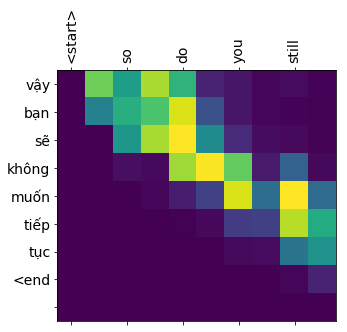


Input:  <start> today i am 22 <end>
Groundtruth:  <start> hôm nay tôi 22 tuổi <end>
Translation:  <start> hôm nay tôi là 22 <end>
Bleu Score:  60.34148992419808


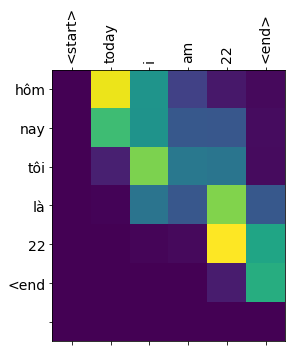


Input:  <start> i was raised in a country that has been destroyed by decades of war <end>
Groundtruth:  <start> tôi đã được lớn lên ở một quốc gia đã bị tiêu huỷ bởi bao thập niên chiến tranh <end>
Translation:  <start> tôi được nuôi sống ở một đất nước đã bị phá huỷ bởi những thập kỷ <end>
Bleu Score:  18.567235990132843

Input:  <start> fewer than six percent of women my age have made it beyond high school and had my family not been so committed to my education i would be one of them <end>
Groundtruth:  <start> ít hơn 6 phụ nữ tuổi tôi được học sau trung học phổ thông và nếu gia đình tôi không cam kết về việc học của tôi tôi cũng trở thành một trong số họ <end>
Translation:  <start> ít hơn 6 phụ nữ trẻ em đã làm việc ở trường trung học và tôi không phải chịu trách nhiệm của tôi <end>
Bleu Score:  22.741514097376026

Input:  <start> instead i stand here a proud graduate of middlebury college <end>
Groundtruth:  <start> nhưng mà tôi hãnh diện đứng đây là một sinh viên tốt nghiệp trườn

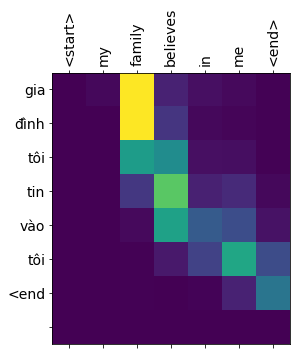


Input:  <start> i dream big but my family dreams even bigger for me <end>
Groundtruth:  <start> tôi mơ ước lớn nhưng gia đình tôi mong ước cho tôi còn lớn hơn <end>
Translation:  <start> tôi mơ ước nhưng tôi còn mơ ước của tôi nhưng lớn hơn với tôi <end>
Bleu Score:  35.01826207809194

Input:  <start> thats why i am a global ambassador for 10x10 a global campaign to educate women <end>
Groundtruth:  <start> vì thế tôi là đại sứ toàn cầu cho 10x10 đây là cuộc vận động toàn cầu để giáo dục phụ nữ <end>
Translation:  <start> đó là lý do tại sao tôi là một nhà kinh doanh cho các nền kinh tế toàn cầu cho giáo dục phụ nữ <end>
Bleu Score:  29.420998830694653

Input:  <start> thats why i cofounded sola the first and perhaps only boarding school for girls in afghanistan a country where its still risky for girls to go to school <end>
Groundtruth:  <start> vì vậy tôi giúp thành lập sola ngôi trường đầu tiên và hẳn là duy nhất cho con gái ở afghanistan một đất nước mà vẫn còn nguy hiểm cho các c

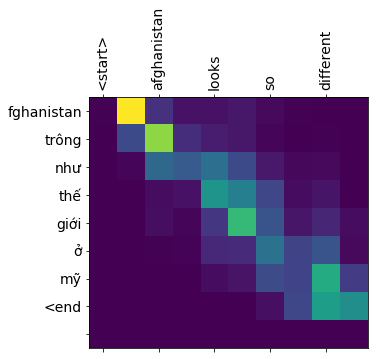


Input:  <start> i find that americans see the fragility in changes <end>
Groundtruth:  <start> tôi thấy rằng người mỹ thấy sự yếu ớt dễ vỡ trong những thay đổi <end>
Translation:  <start> tôi thấy rằng người mỹ thấy rằng sự chú ý của sự cân bằng sự thay đổi <end>
Bleu Score:  51.02002548573252

Input:  <start> i fear that these changes will not last much beyond the u s troops withdrawal <end>
Groundtruth:  <start> tôi sợ rằng tất cả những thay đổi đó sẽ không kéo dài hơn sau khi quân đội mỹ rút đi <end>
Translation:  <start> tôi sợ hãi rằng những thay đổi này không phải vượt xa hơn các nhà tù nhân <end>
Bleu Score:  22.64253661689029

Input:  <start> but when i am back in afghanistan when i see the students in my school and their parents who advocate for them who encourage them i see a promising future and lasting change <end>
Groundtruth:  <start> nhưng khi tôi trở về afghanistan khi tôi thấy học sinh trong trường của tôi và cha mẹ họ ủng hộ họ khuyến khích họ tôi thấy một tương lai 

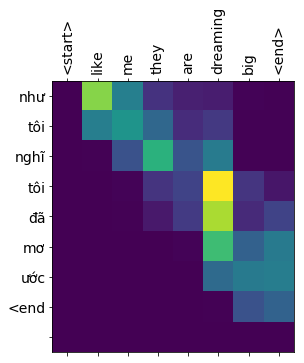


Input:  <start> thank you <end>
Groundtruth:  <start> cám ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  50.000000000000014


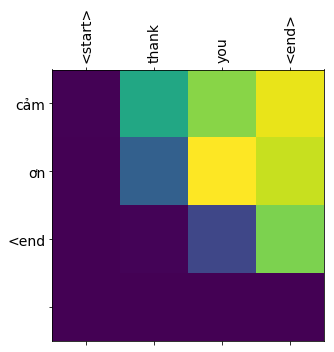


Input:  <start> hi this is my mobile phone <end>
Groundtruth:  <start> xin chào đây là chiếc điện thoại di động của tôi <end>
Translation:  <start> xin chào tôi là điện thoại di động của tôi <end>
Bleu Score:  71.183044767722

Input:  <start> a mobile phone can change your life and a mobile phone gives you individual freedom <end>
Groundtruth:  <start> một chiếc điện thoại di động có thể thay đổi cuộc sống của bạn và một chiếc điện thoại cũng mang lại cho bạn tự do cá nhân <end>
Translation:  <start> điện thoại di động có thể thay đổi cuộc sống và một chiếc điện thoại di động cho bạn tự do tự do <end>
Bleu Score:  51.9112925792104

Input:  <start> with a mobile phone you can shoot a crime against humanity in syria <end>
Groundtruth:  <start> với một chiếc điện thoại di động bạn có thể ghi lại hình ảnh những hành động xâm phạm nhân quyền ở syria <end>
Translation:  <start> với một chiếc điện thoại di động bạn có thể bắn một kẻ chống lại cho người dân <end>
Bleu Score:  46.9695360509274

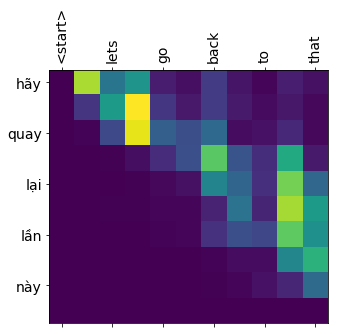


Input:  <start> here you can see how hundreds of thousands of people stood up and protested for change <end>
Groundtruth:  <start> bạn có thể thấy ở đây cách mà hàng ngàn người dân đứng lên và biểu tình cho sự thay đổi <end>
Translation:  <start> ở đây bạn có thể thấy cách đây hàng trăm ngàn người đứng dậy và hoà bình cho sự thay đổi <end>
Bleu Score:  40.596109521030215

Input:  <start> this is autumn 1989 and imagine that all those people standing up and protesting for change had a mobile phone in their pocket <end>
Groundtruth:  <start> đó là vào mùa thu năm 1989 và hãy tưởng tượng những con người đã đứng lên và biểu tình đòi sự thay đổi đó có một chiếc điện thoại di động trong túi <end>
Translation:  <start> mùa hè năm 1989 và tưởng tượng tất cả những người đứng dậy và sự phản đối với sự thay đổi một bộ điện thoại di động trong túi <end>
Bleu Score:  32.02279061035109

Input:  <start> who in the room has a mobile phone with you <end>
Groundtruth:  <start> những ai trong khán phòng

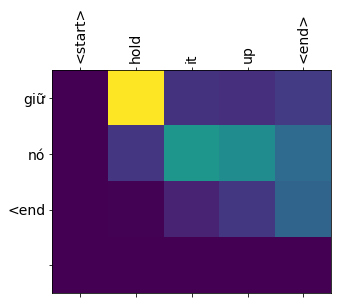


Input:  <start> hold your phones up hold your phones up <end>
Groundtruth:  <start> hãy giơ chiếc điện thoại của bạn lên hãy giơ cao chiếc điện thoại của bạn lên <end>
Translation:  <start> hãy giơ tay điện thoại của bạn <end>
Bleu Score:  26.882649264672644


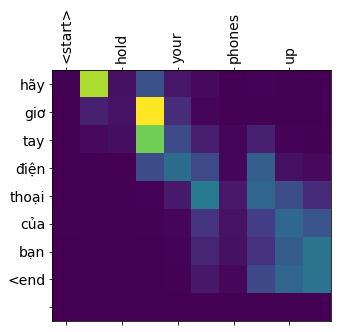


Input:  <start> hold it up an android a blackberry wow <end>
Groundtruth:  <start> hãy giơ cao nó lên một chiếc điện thoại android blackberry wow <end>
Translation:  <start> hãy lấy nó một cái bóng đèn điện tử <end>
Bleu Score:  21.297466564773156

Input:  <start> thats a lot almost everybody today has a mobile phone <end>
Groundtruth:  <start> rất nhiều ngày nay phần lớn chúng ta đều có một chiếc điện thoại di động <end>
Translation:  <start> đó là rất nhiều người đều có một chiếc điện thoại di động <end>
Bleu Score:  55.53499857169823

Input:  <start> but today i will talk about me and my mobile phone and how it changed my life <end>
Groundtruth:  <start> nhưng hôm nay tôi sẽ nói về bản thân và chiếc điện thoại của tôi và về cách mà nó đã thay đổi cuộc đời mình <end>
Translation:  <start> nhưng hôm nay tôi sẽ nói về tôi và điện thoại di động của tôi và nó ra sao cuộc đời tôi <end>
Bleu Score:  40.36473801763577

Input:  <start> and i will talk about this <end>
Groundtruth:  <start> 

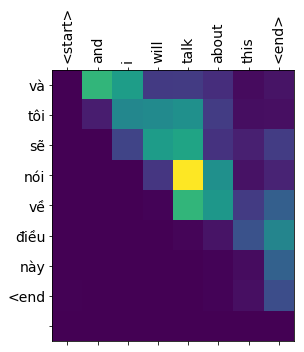


Input:  <start> these are 35 830 lines of information <end>
Groundtruth:  <start> có khoảng 35830 dãy thông tin <end>
Translation:  <start> đây là một cái máy bay thông tin <end>
Bleu Score:  35.55670235668696


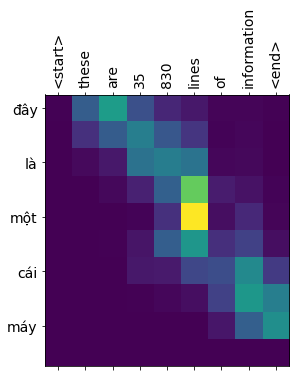


Input:  <start> raw data <end>
Groundtruth:  <start> những thông tin thuần sơ cấp <end>
Translation:  <start> dữ liệu thô <end>
Bleu Score:  21.386638885976566


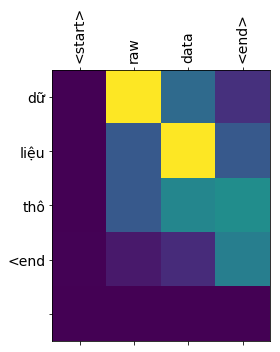


Input:  <start> and why are these informations there <end>
Groundtruth:  <start> nhưng tại sao những thông tin đó lại ở đây <end>
Translation:  <start> và tại sao chúng ta lại là những điều này là điều này <end>
Bleu Score:  15.226277779914144

Input:  <start> because in the summer of 2006 the e u commission tabled a directive <end>
Groundtruth:  <start> nguyên nhân là do mùa hè năm 2006 uỷ ban châu âu đã đề xuất một chỉ thị chính thức <end>
Translation:  <start> bởi vì mùa hè năm 2006 của đại sứ quán mỹ <end>
Bleu Score:  15.58374560762885

Input:  <start> this directive 91 is 93 called data retention directive <end>
Groundtruth:  <start> nó được gọi là chỉ thị bảo lưu dữ liệu <end>
Translation:  <start> ở đây là một số nhớ sự phụ thuộc vào <end>
Bleu Score:  15.911783110981522

Input:  <start> this directive says that each phone company in europe each internet service company all over europe has to store a wide range of information about the users <end>
Groundtruth:  <start> chỉ thị

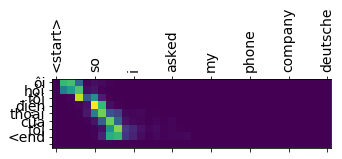


Input:  <start> and i asked them once and i asked them again and i got no real answer it was only blah blah answers <end>
Groundtruth:  <start> tôi đã yêu cầu họ hãy gửi cho tôi chỉ một lần thôi và tôi đã tiếp tục yêu cầu nhưng cái mà tôi nhận được chỉ là một câu trả lời không rõ ràng blah blah blah <end>
Translation:  <start> và tôi hỏi họ một lần và tôi hỏi họ và nói tôi không có câu trả lời đúng không phải là tiếng nói chuyện <end>
Bleu Score:  8.550277320956166

Input:  <start> but then i said i want to have this information because this is my life you are protocoling <end>
Groundtruth:  <start> nhưng sau đó tôi đã nói tôi muốn có được những thông tin này bởi vì họ đang lưu trữ cuộc sống của tôi <end>
Translation:  <start> nhưng sau đó tôi nói tôi muốn có thông tin này bởi vì đây là cuộc sống của tôi là bạn <end>
Bleu Score:  50.597771221032964

Input:  <start> so i decided to start a lawsuit against them because i wanted to have this information <end>
Groundtruth:  <start> và tôi

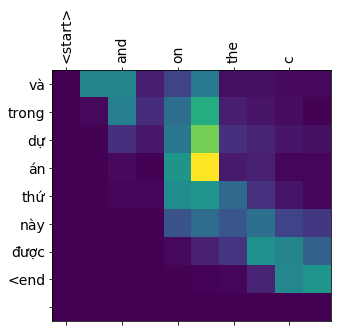


Input:  <start> thirty five thousand eight hundred thirty lines of information <end>
Groundtruth:  <start> 35830 dãy các thông tin <end>
Translation:  <start> 30 năm 8 5 nghìn người thông tin <end>
Bleu Score:  35.55670235668696


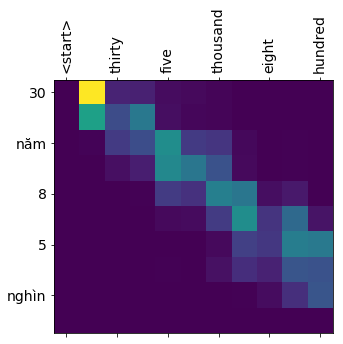


Input:  <start> at first i saw it and i said okay its a huge file okay <end>
Groundtruth:  <start> đầu tiên tôi nhìn nó và nói được rồi nó là một file dữ liệu lớn tốt <end>
Translation:  <start> trước hết tôi thấy nó và tôi nói ok tôi đã có thể là một số các đồ hoạ rất tuyệt vời <end>
Bleu Score:  11.002068284361828

Input:  <start> but then after a while i realized this is my life <end>
Groundtruth:  <start> nhưng sau đó tôi đã nhận ra đây là toàn bộ cuộc sống của mình <end>
Translation:  <start> nhưng sau đó khi tôi nhận ra rằng cuộc đời tôi <end>
Bleu Score:  32.128996628565346

Input:  <start> this is six months of my life into this file <end>
Groundtruth:  <start> đây là cuộc sống trong sáu tháng của tôi đã được ghi lại toàn bộ trong tệp dữ liệu này <end>
Translation:  <start> đây là 6 tháng một cuộc đời tôi trong phòng thí nghiệm này <end>
Bleu Score:  24.07859711552977

Input:  <start> so i was a little bit skeptical what should i do with it <end>
Groundtruth:  <start> sau đó t

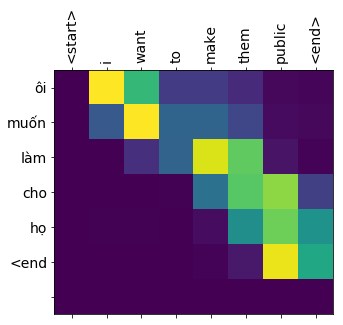


Input:  <start> because i want to show the people what does data retention mean <end>
Groundtruth:  <start> bởi lẽ tôi muốn cho mọi người thấy sự bảo lưu dữ liệu thật sự là như thế nào <end>
Translation:  <start> bởi vì tôi muốn cho các con người làm gì mà những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ những dữ liệu về sự bất cứ
Bleu Score:  6.234621698606699

Input:  <start> so together with zeit online and open data city i did this <end>
Groundtruth:  <start> do vậy đối với zeit online và open data city tôi cũng làm điều tương tự <end>
Translation:  <start> với nhau với nhau với các thành phố và mở cửa hàng hoá học tôi đã làm điều này <end>
Bleu Score:  11.601529016234949

Input:  <start> this is a visualization of six months of my life <end>
Groundtruth:  <start> đây là những hình ảnh trực quan về cuộc sống trong sáu tháng đã được ghi lại của tôi <end>
Translation:  <s

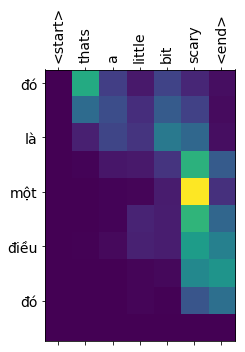


Input:  <start> but it is not only about me <end>
Groundtruth:  <start> nhưng những thông tin đó không chỉ nói về tôi <end>
Translation:  <start> nhưng nó không chỉ là tôi <end>
Bleu Score:  33.387051673049804


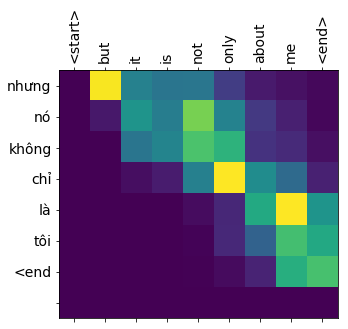


Input:  <start> its about all of us <end>
Groundtruth:  <start> nó là thông tin về tất cả chúng ta <end>
Translation:  <start> đó là về tất cả chúng ta <end>
Bleu Score:  58.73934418709088


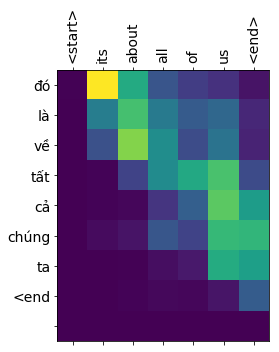


Input:  <start> first its only like i call my wife and she calls me and we talk to each other a couple of times <end>
Groundtruth:  <start> đầu tiên nó chỉ giống như thế này tôi gọi cho vợ tôi và cô ấy cũng gọi cho tôi chúng tôi nói chuyện với nhau vài ba lần <end>
Translation:  <start> đầu tiên nó chỉ là tôi là vợ tôi và tôi gọi tôi và tôi nói với chúng tôi nói chuyện với nhau vài lần <end>
Bleu Score:  44.70639593182075

Input:  <start> and then there are some friends calling me and they call each other <end>
Groundtruth:  <start> và sau đó là một vài người bạn gọi cho tôi họ gọi cho nhau nữa <end>
Translation:  <start> và sau đó có một số bạn tự nhủ tôi gọi là mỗi con <end>
Bleu Score:  30.340562610233768

Input:  <start> and after a while you are calling you and you are calling you and you have this great communication network <end>
Groundtruth:  <start> một lúc sau đó bạn gọi cho bạn và bạn gọi cho bạn và bạn sẽ có được mạng lưới giao tiếp rộng lớn này <end>
Translation:  <start>

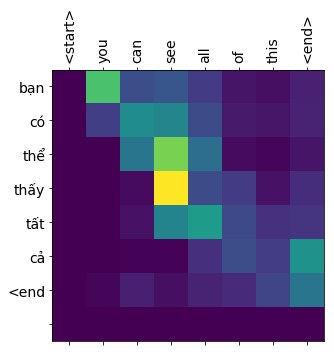


Input:  <start> you can see the hubs like who are the leaders in the group <end>
Groundtruth:  <start> bạn có thể thấy được những phần trọng yếu nhất giống như là những người lãnh đạo trong một nhóm <end>
Translation:  <start> bạn có thể thấy trung tâm như những người lãnh đạo ở nhóm <end>
Bleu Score:  39.97346212916552

Input:  <start> if you have access to this information you can see what your society is doing <end>
Groundtruth:  <start> nếu bạn có được quyền truy cập những thông tin này bạn có thể thấy được hoạt động của cả cộng đồng xã hội <end>
Translation:  <start> nếu bạn có thể tiếp cận thông tin này bạn có thể thấy những xã hội bạn đang làm gì <end>
Bleu Score:  40.92298221400519

Input:  <start> if you have access to this information you can control your society <end>
Groundtruth:  <start> nếu bạn có quyền truy cập những thông tin này bạn có thể kiểm soát toàn bộ xã hội <end>
Translation:  <start> nếu bạn có thể tiếp cận thông tin này bạn có thể kiểm soát xã hội của bạn <en

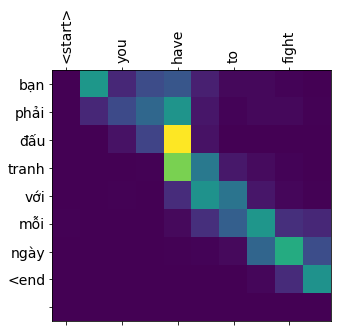


Input:  <start> so when you go home tell your friends that privacy is a value of the 21st century and its not outdated <end>
Groundtruth:  <start> sau đó khi bạn trở về nhà hãy nói với bạn bè của mình rằng quyền riêng tư là một giá trị của thế kỉ 21 và điều đó không hề lỗi thời <end>
Translation:  <start> khi bạn đi về các bạn bè của tôi rằng cá nhân của một phần của thế kỷ 21 và nó không phải là điều đó <end>
Bleu Score:  11.236183829518307

Input:  <start> when you go home tell your representative only because companies and state agencies have the possibility to store certain information they dont have to do it <end>
Groundtruth:  <start> khi bạn trở về nhà hãy nói với chỉ người đại diện của mình rằng bởi các công ty và cơ quan chức năng có thể lưu giữ lại những thông tin cụ thể mặc dù họ không nhất thiết phải làm như thế <end>
Translation:  <start> khi bạn về nhà nói chuyện đại diện của tôi sẽ chỉ ra mô tả chỉ bởi vì các công ty và các nhà tài chính của các cơ quan đến các thông ti

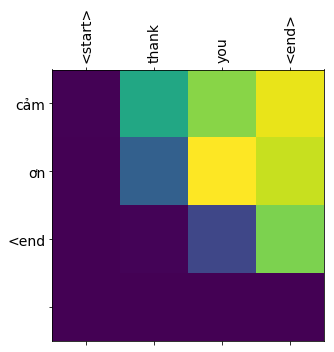


Input:  <start> photography has been my passion ever since i was old enough to pick up a camera but today i want to share with you the 15 most treasured photos of mine and i didnt take any of them <end>
Groundtruth:  <start> nhiếp ảnh là niềm đam mê của tôi kể từ khi tôi đủ lớn để cầm một chiếc máy ảnh nhưng hôm nay tôi muốn chia sẻ với các bạn 15 bức ảnh mà tôi trân trọng nhất và tôi không tự chụp cái nào trong số đó <end>
Translation:  <start> nhiếp ảnh có đam mê của tôi luôn được kể từ tôi là một số liệu tôi sẽ chia sẻ với một chiếc máy nhưng tôi muốn chia sẻ với các bạn 15 tuổi <end>
Bleu Score:  28.572385454146254

Input:  <start> there were no art directors no stylists no chance for reshoots not even any regard for lighting <end>
Groundtruth:  <start> không có đạo diễn nghệ thuật không có nhà tạo mẫu không chụp lại thậm chí không hề quan tâm tới ánh sáng <end>
Translation:  <start> có một nghệ sĩ không có gì không có cơ hội không có gì để không phải không <end>
Bleu Score:  10.7

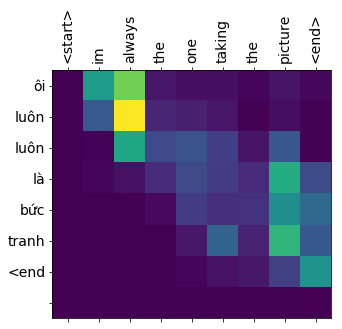


Input:  <start> so i want to encourage everyone today to get in the shot and dont hesitate to go up to someone and ask will you take our picture <end>
Groundtruth:  <start> vì vậy hôm nay tôi muốn động viên tất cả mọi người hãy có mặt trong bức ảnh và đừng ngần ngại bước tới chỗ một ai đó và hỏi bạn chụp ảnh giúp chúng tôi nhé <end>
Translation:  <start> tôi muốn khuyến khích mọi người ngày nay để được chụp được và bị bắt đầu đi đến một người và hỏi sẽ cho các bức ảnh của mình <end>
Bleu Score:  8.232288711065584

Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.00000000000004


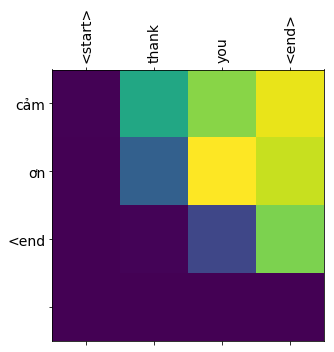


Input:  <start> i have never ever forgotten the words of my grandmother who died in her exile son resist gaddafi fight him <end>
Groundtruth:  <start> tôi chưa bao giờ quên những lời bà tôi dặn dò bà đã qua đời trong cảnh tha hương này cháu hãy chống lại gaddafi hãy chiến đấu chống lại hắn <end>
Translation:  <start> tôi chưa bao giờ quên đi từ tiếng anh em chết trong đám cưới của anh ta cưỡng hiếp và ông ấy sẽ cưỡng hiếp ông ấy <end>
Bleu Score:  22.064519685580947

Input:  <start> but dont you ever turn into a gaddafi like revolutionary <end>
Groundtruth:  <start> nhưng đừng bao giờ biến thành một dạng người cách mạng kiểu gaddafi <end>
Translation:  <start> nhưng đừng hiểu được một ví dụ như là một cách mạng <end>
Bleu Score:  28.627573592435688

Input:  <start> almost two years have passed since the libyan revolution broke out inspired by the waves of mass mobilization in both the tunisian and the egyptian revolutions <end>
Groundtruth:  <start> gần hai năm đã trôi qua từ khi cuộc

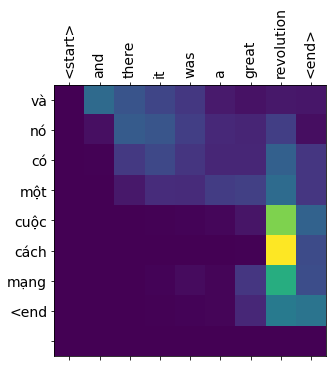


Input:  <start> young libyan women and men were at the forefront calling for the fall of the regime raising slogans of freedom dignity social justice <end>
Groundtruth:  <start> nam nữ thanh niên đứng đầu chiến tuyến đòi lật đổ chính quyền giơ cao những biểu ngữ về tự do phẩm giá công bằng xã hội <end>
Translation:  <start> những người phụ nữ trẻ và những người đàn ông đều đang ở trên đầu tiên gọi là sự bùng nổ của sự tự do của sự tự do tự do chính quyền <end>
Bleu Score:  7.928399830171251

Input:  <start> they have shown an exemplary bravery in confronting the brutal dictatorship of gaddafi <end>
Groundtruth:  <start> họ đã tỏ rõ một tấm gương về lòng quả cảm trong việc đối đầu với chế độ độc tài tàn bạo của gaddafi <end>
Translation:  <start> họ đã được chứng minh về sự can đảm với sự độc tài của kamenji <end>
Bleu Score:  17.381521469099344

Input:  <start> they have shown a great sense of solidarity from the far east to the far west to the south <end>
Groundtruth:  <start> họ đã 

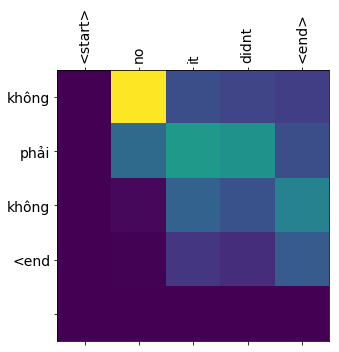


Input:  <start> what is it then <end>
Groundtruth:  <start> vậy cuối cùng nó đã giúp ích gì <end>
Translation:  <start> nó là gì <end>
Bleu Score:  25.607970016522764


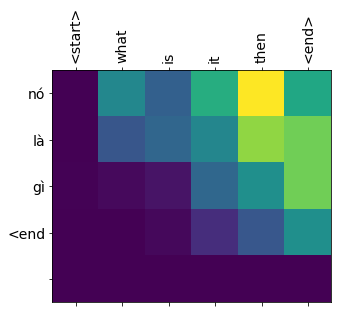


Input:  <start> why does our society continue to be polarized and dominated with selfish politics of dominance and exclusion by both men and women <end>
Groundtruth:  <start> tại sao xã hội chúng tôi tiếp tục là một xã hội phân cực và thống trị bởi những nền chính trị ích kỷ của sự thống trị và loại trừ bởi cả hai giới nam và nữ <end>
Translation:  <start> tại sao xã hội lại có thể phân tán và sự phụ thuộc với sự chính trị chính trị của sự tôn giáo và sự tồn tại của đàn ông và phụ nữ <end>
Bleu Score:  21.983953382194287

Input:  <start> maybe what was missing was not the women only but the feminine values of compassion mercy and inclusion <end>
Groundtruth:  <start> có thể sự thiếu sót không chỉ là về mặt bình quyền của phụ nữ mà còn là những giá trị tính nữ về lòng trắc ẩn sự khoan dung và tính toàn diện <end>
Translation:  <start> có thể là sự thiếu là phụ nữ chỉ là phụ nữ đối với sự chú ý và sự xuất bản <end>
Bleu Score:  14.552057738206518

Input:  <start> our society needs natio

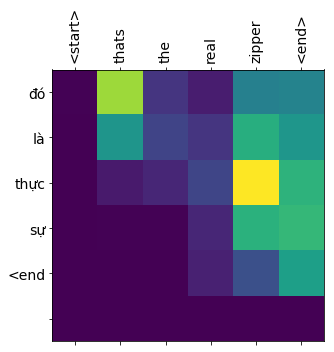


Input:  <start> and we need to establish that existentially before we do so sociopolitically <end>
Groundtruth:  <start> và chúng tôi cần thiết lập yếu tố sống còn đó trước khi thực hiện mặt chính trị xã hội <end>
Translation:  <start> và chúng ta cần thiết lập một cách này trước khi chúng tôi làm như vậy <end>
Bleu Score:  24.915119975651894

Input:  <start> according to a quranic verse salam peace is the word of the all merciful god raheem <end>
Groundtruth:  <start> theo một đoạn thơ trong kinh koran salam hoà bình là từ của chúa trời đầy lòng khoan dung raheem <end>
Translation:  <start> theo một bài diễn thuyết hoà bình là một từ những nhà vũ trụ <end>
Bleu Score:  22.330744775604945

Input:  <start> in turn the word raheem which is known in all abrahamic traditions has the same root in arabic as the word rahem womb symbolizing the maternal feminine encompassing all humanity from which the male and the female from which all tribes all peoples have emanated from <end>
Groundtruth:

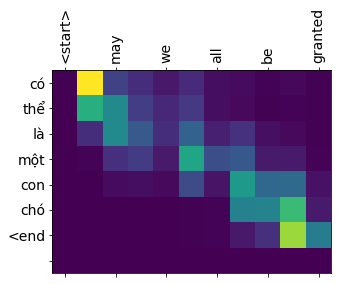


Input:  <start> thank you <end>
Groundtruth:  <start> vỗ tay cám ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  38.940039153570254


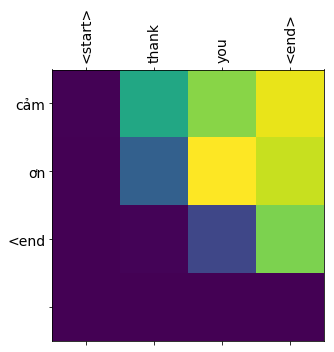


Input:  <start> five years ago i experienced a bit of what it must have been like to be alice in wonderland <end>
Groundtruth:  <start> 5 năm trước tôi đã trải qua 1 chuyện có chút giống như alice ở xứ thần tiên <end>
Translation:  <start> năm năm trước tôi đã trải qua một điều mà nó đã phải là tên là tên lửa <end>
Bleu Score:  29.548048406666158

Input:  <start> penn state asked me a communications teacher to teach a communications class for engineering students <end>
Groundtruth:  <start> trường penn state yêu cầu tôi một giáo viên dạy giao tiếp dạy một khoá giao tiếp cho sinh viên kỹ thuật <end>
Translation:  <start> nhà tù nhân tôi hỏi một giáo dục học dạy cho một cuộc sống một công nghệ thông tin cho các sinh viên <end>
Bleu Score:  11.017841899461907

Input:  <start> and i was scared <end>
Groundtruth:  <start> tôi đã rất sợ <end>
Translation:  <start> và tôi đã sợ hãi <end>
Bleu Score:  27.455024338805618


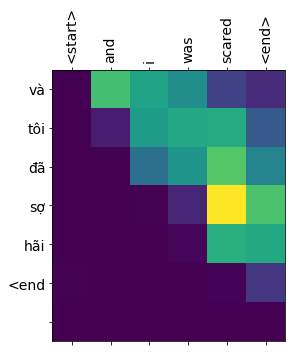


Input:  <start> really scared scared of these students with their big brains and their big books and their big unfamiliar words <end>
Groundtruth:  <start> thực sự sợ sợ những sinh viên to đầu những quyển sách to đùng và cả những ngôn từ lạ lẫm <end>
Translation:  <start> thật sự sợ hãi những câu hỏi này với các bộ não và những cuốn sách và những cuốn sách lớn và những câu chuyện lớn nhất của chúng tôi <end>
Bleu Score:  8.234504830547136

Input:  <start> but as these conversations unfolded i experienced what alice must have when she went down that rabbit hole and saw that door to a whole new world <end>
Groundtruth:  <start> nhưng khi những cuộc trao đổi mở ra tôi đã trải nghiệm điều mà hẳn alice cũng trải qua khi cô bé rơi xuống hang thỏ và phát hiện cánh cửa dẫn đến 1 thế giới mới <end>
Translation:  <start> nhưng những cuộc nói chuyện này tôi đã trải nghiệm điều gì đã biết đến khi cô ấy đi xuống con ngựa và nhìn thấy cánh cửa cho một thế giới <end>
Bleu Score:  20.525653567612885


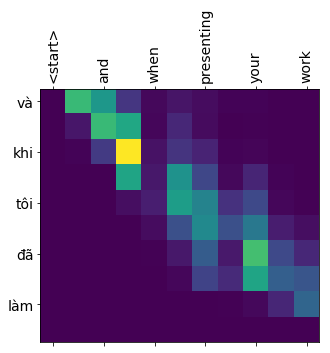


Input:  <start> have you ever wondered why theyre called bullet points <end>
Groundtruth:  <start> đã bao giờ bạn tự hỏi tại sao lại gọi chúng là gạch đầu dòng chưa <end>
Translation:  <start> bạn có thể tự hỏi tại sao họ gọi là một viên gạch <end>
Bleu Score:  21.757047069533858

Input:  <start> what do bullets do bullets kill and they will kill your presentation <end>
Groundtruth:  <start> khi gạch tên đi thì sao gạch đi là xoá sổ giết chết luôn và chúng cũng sẽ giết bài thuyết trình của anh <end>
Translation:  <start> có thể được đào tạo ra đi săn mồi và họ sẽ giết chết giả thuyết trình của mình <end>
Bleu Score:  12.557204940779846

Input:  <start> a slide like this is not only boring but it relies too much on the language area of our brain and causes us to become overwhelmed <end>
Groundtruth:  <start> một slide như thế này không những nhàm chán mà còn phụ thuộc quá nhiều vào khu vực ngôn ngữ của não bộ khiến chúng tôi bị ngốt <end>
Translation:  <start> một slide này không chỉ l

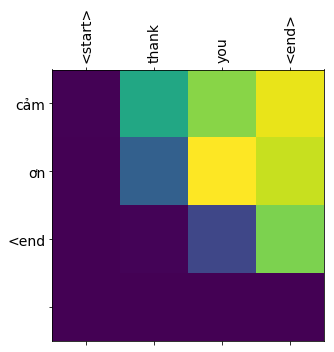


Input:  <start> hi my name is cameron russell and for the last little while ive been a model <end>
Groundtruth:  <start> xin chào tôi là cameron russell và trong khoảng thời gian ngắn ngủi vừa qua tôi là một người mẫu <end>
Translation:  <start> xin chào tên tôi tên là al qaeda và trong thời gian trong khi tôi đã mô hình <end>
Bleu Score:  22.789318501970758

Input:  <start> actually for 10 years <end>
Groundtruth:  <start> thật ra trong 10 năm <end>
Translation:  <start> thực tế 10 năm <end>
Bleu Score:  47.53852732567741


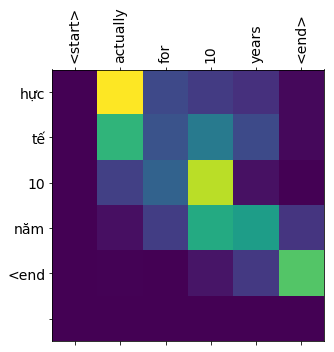


Input:  <start> and i feel like theres an uncomfortable tension in the room right now because i should not have worn this dress <end>
Groundtruth:  <start> và tôi cảm thấy có một áp lực không thoải mái trong phòng vào lúc này bởi vì đáng lẽ ra tôi không nên mặc cái đầm này <end>
Translation:  <start> và tôi cảm thấy như vậy không có sự thoải mái không có gì đó không thoải mái trong phòng bên phải vì tôi nên không có được mặc dù vậy <end>
Bleu Score:  30.439378336682978

Input:  <start> so luckily i brought an outfit change <end>
Groundtruth:  <start> may mắn thay tôi có mang theo một bộ đồ khác <end>
Translation:  <start> may mắn thay tôi đã mang lại thay đổi <end>
Bleu Score:  44.09928765478173

Input:  <start> this is the first outfit change on the ted stage so you guys are pretty lucky to witness it i think <end>
Groundtruth:  <start> đây là lần đầu tiên có người thay đồ trên sân khấu của ted vậy nên tôi nghĩ các bạn rất may mắn khi được chứng kiến cảnh này đấy <end>
Translation:  

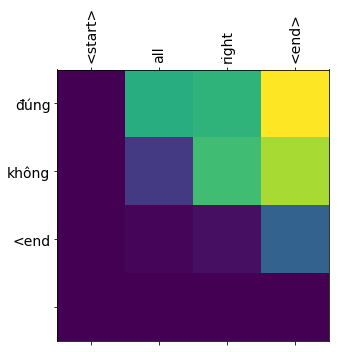


Input:  <start> so why did i do that <end>
Groundtruth:  <start> tại sao tôi lại làm như vậy <end>
Translation:  <start> vì vậy tại sao tôi làm điều đó <end>
Bleu Score:  25.336549464486474


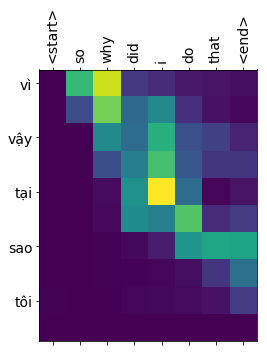


Input:  <start> that was awkward <end>
Groundtruth:  <start> nó thật là kì cục <end>
Translation:  <start> đó là sự thật <end>
Bleu Score:  25.54173603367238


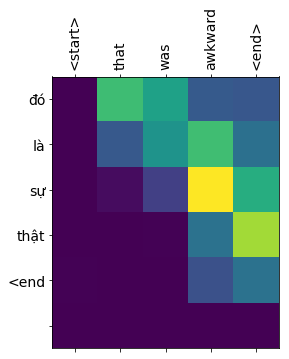


Input:  <start> well hopefully not as awkward as that picture <end>
Groundtruth:  <start> thật ra hy vọng là nó không đến nỗi kì cục như tấm hình này <end>
Translation:  <start> hy vọng là không hề giống như bức tranh <end>
Bleu Score:  15.71647089509212

Input:  <start> image is powerful but also image is superficial <end>
Groundtruth:  <start> hình ảnh có sức mạnh rất lớn nhưng nó cũng rất là giả tạo <end>
Translation:  <start> hình ảnh là sức mạnh nhưng cũng có hình ảnh <end>
Bleu Score:  28.505898719449654

Input:  <start> i just totally transformed what you thought of me in six seconds <end>
Groundtruth:  <start> tôi vừa mới thay đổi hoàn toàn những gì bạn nghĩ về tôi trong vòng 6 giây <end>
Translation:  <start> tôi hoàn toàn thay đổi những gì bạn nghĩ đến tôi trong 2 giây <end>
Bleu Score:  36.805365593400076

Input:  <start> and in this picture i had actually never had a boyfriend in real life <end>
Groundtruth:  <start> và trong bức ảnh này thực ra tôi chưa hề có bạn trai nào

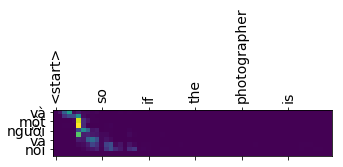


Input:  <start> it will look something like this <end>
Groundtruth:  <start> giống như thế này đây <end>
Translation:  <start> nó sẽ trông như thế này <end>
Bleu Score:  28.73539322585947


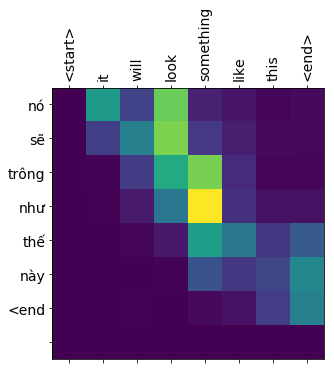


Input:  <start> hopefully less awkward than that one in the middle <end>
Groundtruth:  <start> hi vọng là nó ít kì cục hơn tấm hình ở giữa <end>
Translation:  <start> hy vọng ít hơn một chút trong một người ở giữa <end>
Bleu Score:  29.23578077851693

Input:  <start> that was i dont know what happened there <end>
Groundtruth:  <start> tôi không biết điều gì xảy ra trong lúc đó nữa <end>
Translation:  <start> đó là tôi không biết điều gì xảy ra <end>
Bleu Score:  51.47301559697202

Input:  <start> unfortunately after youve gone to school and you have a résumé and youve done a few jobs you cant say anything anymore so if you say you want to be the president of the united states but your résumé reads underwear model 10 years people give you a funny look <end>
Groundtruth:  <start> thật đáng tiếc sau khi bạn học xong bạn viết résumé và từng làm một vài việc bạn không thể nói thêm điều gì nữa vì nếu bạn nói muốn trở thành tổng thống hoa kỳ nhưng résumé của bạn lại ghi người mẫu đồ lót 10 n

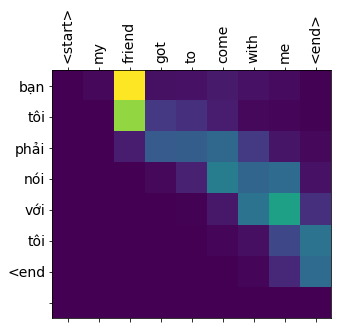


Input:  <start> heres me at a slumber party a few days before i shot french vogue <end>
Groundtruth:  <start> đây là tôi ở tiệc ngủ vài ngày trước khi chụp ảnh cho vogue pháp <end>
Translation:  <start> đây là tôi ở đây một bữa tiệc một vài ngày trước khi tôi chụp những người pháp <end>
Bleu Score:  45.58906849298836

Input:  <start> heres me on the soccer team and in v magazine <end>
Groundtruth:  <start> đây là tôi với đội bóng đá trong tạp chí v <end>
Translation:  <start> đây là tôi ở trên một đội bóng đá và đặt tạp chí tạp chí wired <end>
Bleu Score:  34.613358631405696

Input:  <start> and heres me today <end>
Groundtruth:  <start> và đây là tôi bây giờ <end>
Translation:  <start> và đây là tôi hôm nay <end>
Bleu Score:  63.40466277046863


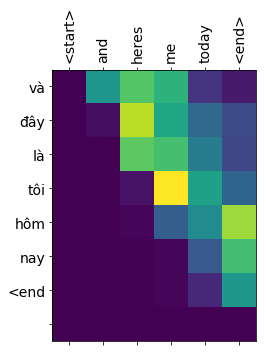


Input:  <start> and i hope what youre seeing is that these pictures are not pictures of me <end>
Groundtruth:  <start> tôi mong rằng bạn nhìn ra được những bức ảnh trên không phải là hình ảnh của tôi <end>
Translation:  <start> và tôi hy vọng rằng các bạn thấy là những bức ảnh này không chỉ là bức ảnh này không chỉ là bức ảnh của tôi <end>
Bleu Score:  23.767486329551545

Input:  <start> they are constructions and they are constructions by a group of professionals by hairstylists and makeup artists and photographers and stylists and all of their assistants and pre production and post production and they build this thats not me <end>
Groundtruth:  <start> đó là những hình ảnh được dựng lên và nó được dựng nên bởi một nhóm các chuyên gia những nhà tạo mẫu tóc những chuyên gia trang điểm nhiếp ảnh gia và những nhà tạo phong cách và tất cả những người trợ lý của họ khâu tiền sản xuất và hậu sản xuất và họ tạo nên cái này đây đó không phải là tôi <end>
Translation:  <start> họ đang tạo ra 

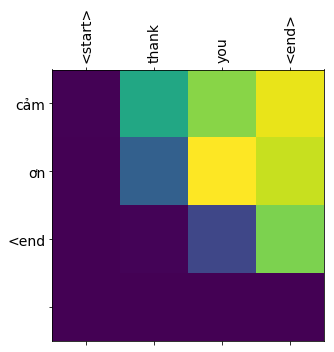


Input:  <start> there are a lot of ways the people around us can help improve our lives <end>
Groundtruth:  <start> có rất nhiều cách mà những người ở xung quanh chúng ta có thể giúp cải thiện cuộc sống của chúng ta <end>
Translation:  <start> có rất nhiều cách mọi người xung quanh chúng ta có thể giúp cải thiện cuộc sống của chúng ta <end>
Bleu Score:  79.8079069546937

Input:  <start> we dont bump into every neighbor so a lot of wisdom never gets passed on though we do share the same public spaces <end>
Groundtruth:  <start> chúng ta không đụng vào mỗi người xung quanh vì vậy có rất nhiều sự thông thái không bao giờ được biết tới dù chúng ta cùng chia sẻ những không gian công cộng <end>
Translation:  <start> chúng ta không có một kẻ bị đánh dấu những người dân cư dân rất nhiều sự khôn ngoan không bao giờ được vượt qua được chúng ta chia sẻ những nơi không gian <end>
Bleu Score:  28.4651281446665

Input:  <start> so over the past few years ive tried ways to share more with my neighbo

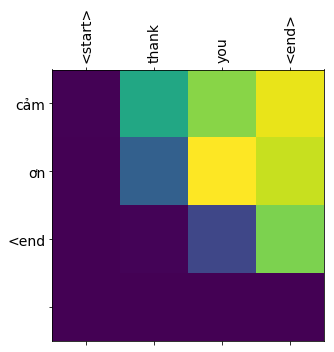


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.00000000000004


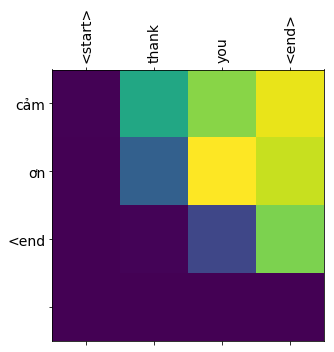


Input:  <start> so well i do applied math and this is a peculiar problem for anyone who does applied math is that we are like management consultants <end>
Groundtruth:  <start> vâng tôi làm toán học ứng dụng và đây là một vấn đề khác thường cho bất cứ ai làm toán học ứng dụng chính là chúng tôi giống như các nhà tư vấn quản lý <end>
Translation:  <start> vì vậy tôi có thể áp dụng toán học và đây là một vấn đề nghiêm trọng cho bất cứ ai đó áp dụng toán toán được phép toán được công ty <end>
Bleu Score:  24.130972670519746

Input:  <start> no one knows what the hell we do <end>
Groundtruth:  <start> không ai biết chúng tôi làm cái quái gì <end>
Translation:  <start> không biết rằng chúng ta làm gì <end>
Bleu Score:  35.9099354184376


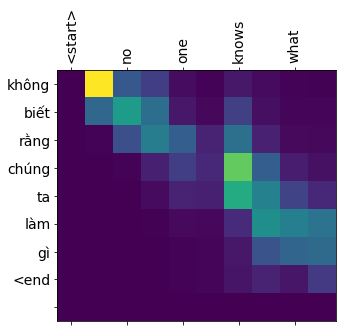


Input:  <start> so i am going to give you some attempt today to try and explain to you what i do <end>
Groundtruth:  <start> vì vậy hôm nay tôi sẽ thử cố gắng giải thích cho bạn việc tôi làm <end>
Translation:  <start> tôi sẽ cho bạn một vài lần nữa hãy thử và giải thích cho các bạn làm gì <end>
Bleu Score:  16.020720994064927

Input:  <start> so dancing is one of the most human of activities <end>
Groundtruth:  <start> vâng nhảy múa là một trong những hoạt động mà con người thường làm <end>
Translation:  <start> vì vậy nhảy rất là một trong những người hoạt động <end>
Bleu Score:  24.944927791567963

Input:  <start> we delight at ballet virtuosos and tap dancers you will see later on <end>
Groundtruth:  <start> chúng ta yêu thích những vũ công bậc thầy về ba lê và nhảy gõ chân bạn sẽ thấy sau đây <end>
Translation:  <start> chúng tôi thích thú với ba lê và các vũ trang bạn sẽ thấy sau đó <end>
Bleu Score:  25.764138361698798

Input:  <start> now ballet requires an extraordinary level

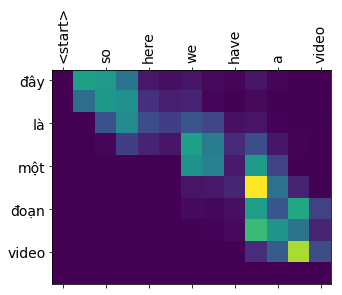


Input:  <start> now this is healthy and this is somebody making speech sounds and we can think of ourselves as vocal ballet dancers because we have to coordinate all of these vocal organs when we make sounds and we all actually have the genes for it foxp2 for example <end>
Groundtruth:  <start> giây thanh quản này khoẻ mạnh và ai đó đang nói và chúng ta có thể xem mình như những vũ công ba lê thanh nhạc bởi vì chúng ta phải phối hợp tất cả các cơ quan phát âm khi tạo ra âm thanh và tất cả chúng ta thực sự có các gen để phụ trách điều đó ví dụ như foxp2 <end>
Translation:  <start> đây là một cách tốt và đây là một người làm trò chơi đùa và chúng ta có thể nghĩ bản thân của chúng ta là một nhạc sĩ nhạc bởi vì chúng ta phải làm việc với nhau <end>
Bleu Score:  13.978873990535758

Input:  <start> and like ballet it takes an extraordinary level of training <end>
Groundtruth:  <start> giống như ba lê nó cần được đào tạo đặc biệt <end>
Translation:  <start> và như như ba ba lê ba lê <end>
Bl

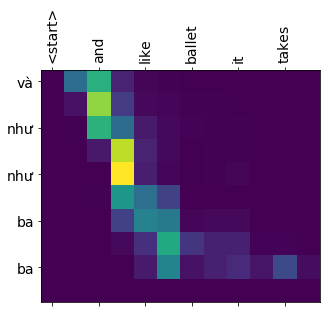


Input:  <start> i mean just think how long it takes a child to learn to speak <end>
Groundtruth:  <start> ý tôi là thử nghĩ mất bao lâu để một đứa trẻ tập nói <end>
Translation:  <start> ý tôi là nghĩ rằng có thể đi một đứa trẻ để học để nói chuyện <end>
Bleu Score:  34.30008334736235

Input:  <start> from the sound we can actually track the vocal fold position as it vibrates and just as the limbs are affected in parkinsons so too are the vocal organs <end>
Groundtruth:  <start> từ âm thanh chúng ta thực sự có thể theo dấu vị trí dây thanh quản khi rung khi các chi bị ảnh hưởng bởi parkinson các cơ quan âm thanh cũng bị thế <end>
Translation:  <start> từ âm thanh chúng ta có thể thực sự có thể hiện diện tích cực như là vết bầm và đang được nhìn thấy bệnh tim và quá nhiều cơ quan <end>
Bleu Score:  27.162556689377997

Input:  <start> so on the bottom trace you can see an example of irregular vocal fold tremor <end>
Groundtruth:  <start> vậy nên ở đồ thị bên dưới bạn có thể thấy một ví 

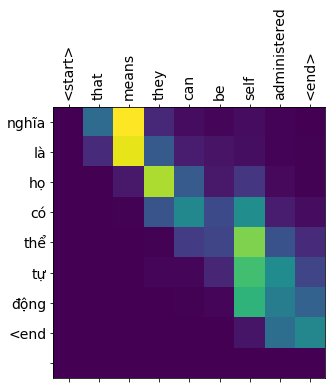


Input:  <start> theyre high speed take about 30 seconds at most <end>
Groundtruth:  <start> tốc độ nhanh chỉ mất khoảng 30 giây tối đa <end>
Translation:  <start> chúng có tốc độ cao tốc độ cao hơn 30 giây <end>
Bleu Score:  18.002829271425153

Input:  <start> theyre ultra low cost and we all know what happens <end>
Groundtruth:  <start> chi phí cực thấp và chúng ta đều biết điều gì sẽ xảy ra <end>
Translation:  <start> chúng là những giá rẻ tiền và chúng ta biết điều gì <end>
Bleu Score:  20.234254014710835

Input:  <start> when something becomes ultra low cost it becomes massively scalable <end>
Groundtruth:  <start> khi một cái gì đó trở nên cực rẻ nó sẽ được phổ biến trên diện rộng <end>
Translation:  <start> khi nó trở thành một giá rẻ có thể chất lượng lớn hơn là khả năng có thể dễ dàng hơn <end>
Bleu Score:  14.06853564987433

Input:  <start> so here are some amazing goals that i think we can deal with now <end>
Groundtruth:  <start> vì vậy đây là một số mục tiêu tuyệt vời mà t

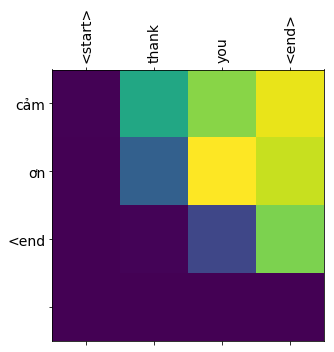


Input:  <start> so max by taking all these samples of lets say 10 000 people youll be able to tell whos healthy and whos not <end>
Groundtruth:  <start> tom rielly vậy max bằng cách lấy tất cả các mẫu cho là của 10 000 người đi bạn có thể cho biết ai khoẻ mạnh và ai không <end>
Translation:  <start> max weber bởi vì mẫu mẫu này hãy nói 10 000 người bạn sẽ có thể nói với người ai khoẻ mạnh và ai không <end>
Bleu Score:  32.455928267033315

Input:  <start> what are you going to get out of those samples <end>
Groundtruth:  <start> bạn sẽ kết luận được gì từ những mẫu này <end>
Translation:  <start> bạn sẽ được từ những mẫu mẫu này <end>
Bleu Score:  54.084391427678554


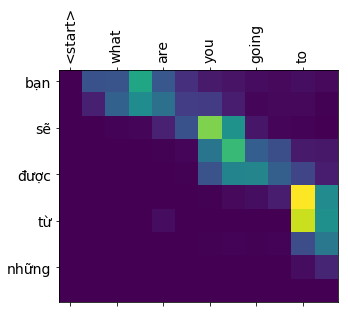


Input:  <start> yeah yeah so what will happen is that during the call you have to indicate whether or not you have the disease or not you see right <end>
Groundtruth:  <start> max little vâng vâng điều sẽ xảy ra là khi gọi bạn phải chỉ rõ bạn có bệnh hay không phải <end>
Translation:  <start> vâng vâng điều gì sẽ xảy ra là trong khi gọi là bạn có quyền không phải bạn có thể nói đúng <end>
Bleu Score:  22.229849552064017

Input:  <start> you see some people may not do it they may not get through it <end>
Groundtruth:  <start> bạn thấy đó một số người có thể không làm điều đó có thể họ không gọi tới được <end>
Translation:  <start> bạn thấy một số người không làm được họ không thể vượt qua nó <end>
Bleu Score:  27.080853894251344

Input:  <start> but well get a very large sample of data that is collected from all different circumstances and its getting it in different circumstances that matter because then we are looking at ironing out the confounding factors and looking for the actual 

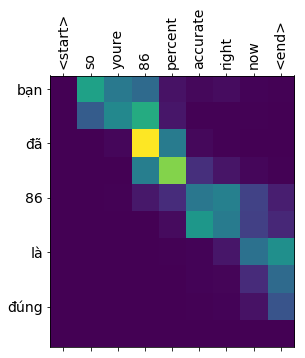


Input:  <start> its much better than that <end>
Groundtruth:  <start> hơn mức đó nhiều chứ <end>
Translation:  <start> nó tốt hơn thế <end>
Bleu Score:  24.70315512339778


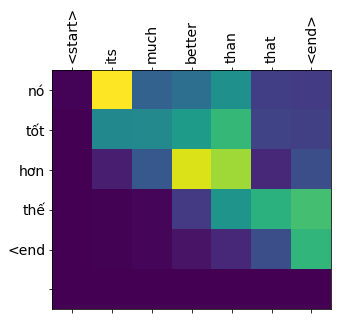


Input:  <start> actually my student thanasis i have to plug him because hes done some fantastic work and now he has proved that it works over the mobile telephone network as well which enables this project and were getting 99 percent accuracy <end>
Groundtruth:  <start> thực ra sinh viên của tôi thanasis tôi phải khen ngợi anh ta bởi vì anh ấy đã làm một số công việc tuyệt vời anh ta đã chứng minh được rằng điều này còn có thể thực hiện được qua mạng điện thoại di động nữa điều đó cho phép dự án này được thực hiện và độ chính xác đang đạt đến 99 phần trăm <end>
Translation:  <start> thực tế của tôi là tôi phải cắm trại anh ta đã làm một điều tuyệt vời và bây giờ anh ấy đã chứng minh rằng nó hoạt động nó hoạt động trong bộ phim điện thoại di động của bộ não <end>
Bleu Score:  12.860694957836927

Input:  <start> ninety nine well thats an improvement <end>
Groundtruth:  <start> chín mươi chín vâng một tiến bộ tớn <end>
Translation:  <start> 83 đây là một sự tiến hoá <end>
Bleu Score:  19

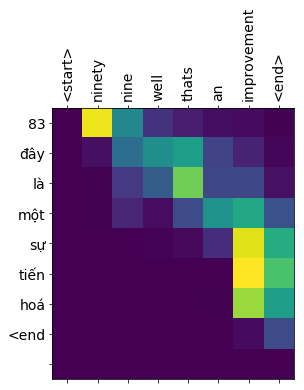


Input:  <start> so what that means is that people will be able to people will be able to call in from their mobile phones and do this test and people with parkinsons could call in record their voice and then their doctor can check up on their progress see where theyre doing in this course of the disease <end>
Groundtruth:  <start> vậy điều đó có nghĩa là mọi người sẽ có thể mọi người có thể gọi từ điện thoại di động của họ và làm bài kiểm tra này và những người có bệnh parkinson có thể gọi ghi âm giọng nói của họ và sau đó bác sĩ có thể kiểm tra sự tiến triển của họ xem tình trạng sức khoẻ của họ khi mang bệnh <end>
Translation:  <start> vậy điều đó có nghĩa là người dân có thể có thể cho người sẽ được gọi là từ bên ngoài điện thoại di động vật và làm điều khiển và kiểm soát và họ có thể kiểm tra và người và với những bệnh nhân viên có thể gọi là vào trong tiếng nói của họ và họ bác
Bleu Score:  25.660149531082567

Input:  <start> absolutely <end>
Groundtruth:  <start> chính xác <end>

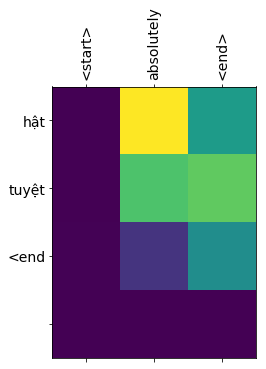


Input:  <start> thanks so much max little everybody <end>
Groundtruth:  <start> cảm ơn rất nhiều hoan nghênh max little nào mọi người <end>
Translation:  <start> cảm ơn rất nhiều người rất nhiều người <end>
Bleu Score:  49.73949558013161


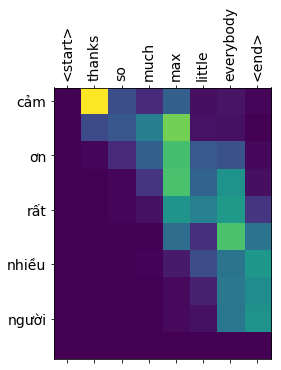


Input:  <start> thanks tom <end>
Groundtruth:  <start> cảm ơn nhiều tom <end>
Translation:  <start> xin cám ơn <end>
Bleu Score:  27.75806054476853


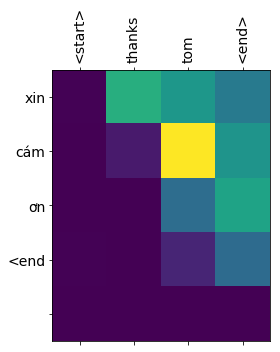


Input:  <start> i live in south central <end>
Groundtruth:  <start> tôi sống ở vùng trung nam <end>
Translation:  <start> tôi sống ở nam cực <end>
Bleu Score:  55.097857671324185


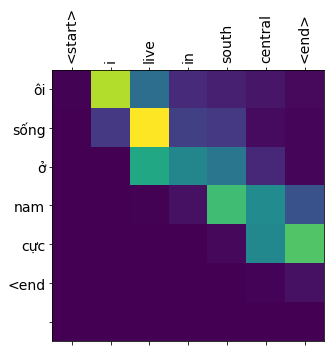


Input:  <start> this is south central liquor stores fast food vacant lots <end>
Groundtruth:  <start> đây là vùng trung nam cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> đây là nam châm điện cực kỳ lân cận rất nhiều <end>
Bleu Score:  26.21684452470331

Input:  <start> so the city planners they get together and they figure theyre going to change the name south central to make it represent something else so they change it to south los angeles like this is going to fix whats really going wrong in the city <end>
Groundtruth:  <start> vì vậy các nhà hoạch định thành phố họp lại với nhau và họ định thay cái tên nam trung để nó mang ý nghĩa khác vậy nên họ đổi thành vùng nam los langeles như thể việc đó sẽ giải quyết được những rắc rối đang thực sự diễn ra trong thành phố <end>
Translation:  <start> vậy thành phố các tổ chức họ họ lại cùng nhau và họ tìm ra sao chép lại tên là trung tâm đến một cái gì đó khác nhau như vậy nên thay đổi nó thành công <end>
Bleu Score:  6.950

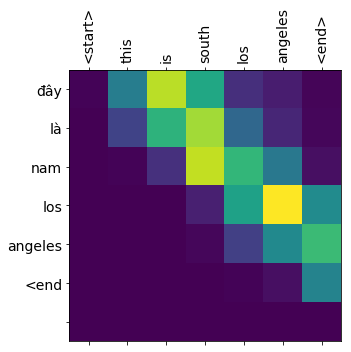


Input:  <start> liquor stores fast food vacant lots <end>
Groundtruth:  <start> cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> mark pagel một loại thức ăn nhanh <end>
Bleu Score:  20.345970436499208


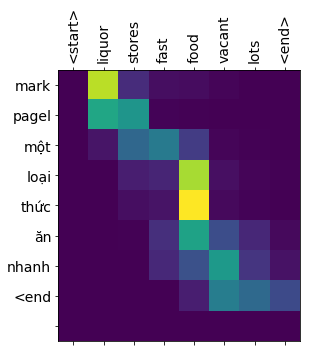


Input:  <start> just like 26 5 million other americans i live in a food desert south central los angeles home of the drive thru and the drive by <end>
Groundtruth:  <start> cũng giống như 26 5 triệu người mĩ khác tôi sống trong một sa mạc thức ăn vùng nam trung los angeles ngôi nhà của quầy phục vụ đồ ăn nhanh bên đường và gậy tai nạn rồi bỏ chạy <end>
Translation:  <start> chỉ như 26 5 triệu người mỹ tôi sống trong một khu vực sa mạc ở los angeles ở los angeles <end>
Bleu Score:  16.481333064758168

Input:  <start> funny thing is the drive thrus are killing more people than the drive bys <end>
Groundtruth:  <start> điều thú vị là đồ ăn nhanh bên đường đang giết chết nhiều người hơn gây tai nạn rồi bỏ chạy <end>
Translation:  <start> điều thú vị là một con đường đi săn bắn nhiều người lái xe <end>
Bleu Score:  27.779213872684863

Input:  <start> people are dying from curable diseases in south central los angeles <end>
Groundtruth:  <start> ở nam trung los angeles mọi người đang chết v

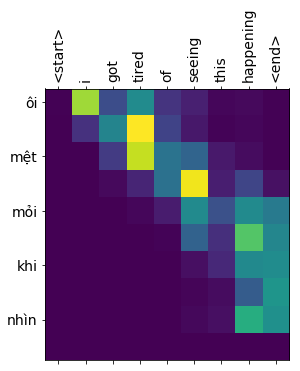


Input:  <start> and i was wondering how would you feel if you had no access to healthy food if every time you walk out your door you see the ill effects that the present food system has on your neighborhood <end>
Groundtruth:  <start> và tôi tự hỏi bạn cảm thấy thế nào khi không có thực phẩm có lợi cho sức khoẻ khi mỗi lần ra khỏi cửa bạn phải nhìn thấy những tác động xấu mà hệ thống thực phẩm hiện nay gây ra cho nơi mình sinh sống <end>
Translation:  <start> và tôi đang thắc mắc làm thế nào nếu bạn cảm thấy được gì để dịch vụ an toàn tốt hơn nếu mỗi lần bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ bạn đi bộ
Bleu Score:  8.734287848316617

Input:  <start> i see wheelchairs bought and sold like used cars <end>
Groundtruth:  <start> tôi nhìn thấy xe lăn được mua bán giống như xe cũ vậy <end>
Translation:  <start> tôi thấy con ngựa mua và bán và bán được như xe hơi <end>
Bleu Score:  22.39521374625909

Input:  <start> i see

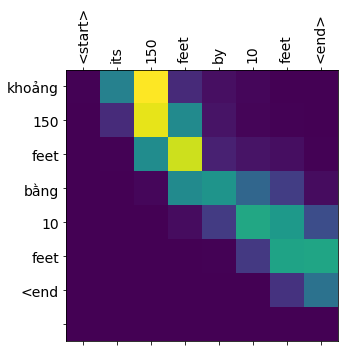


Input:  <start> thing is its owned by the city <end>
Groundtruth:  <start> vấn đề là mảnh đất đó thuộc về thành phố <end>
Translation:  <start> đó là công ty bởi thành phố <end>
Bleu Score:  32.46827270101123


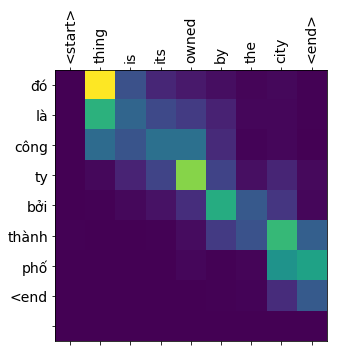


Input:  <start> but you have to maintain it <end>
Groundtruth:  <start> nhưng bạn phải trông giữ nó <end>
Translation:  <start> nhưng bạn phải giữ nó <end>
Bleu Score:  74.26141117870938


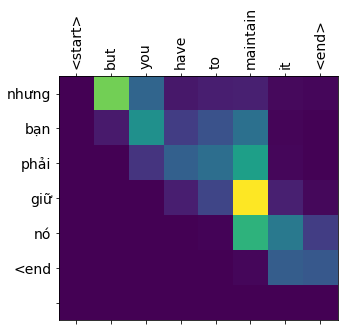


Input:  <start> so im like cool i can do whatever the hell i want since its my responsibility and i gotta maintain it <end>
Groundtruth:  <start> nên tôi nghĩ tuyệt tôi có thể làm việc gì tôi muốn bởi vì đó là trách nhiệm của tôi và tôi phải trông giữ nó <end>
Translation:  <start> tôi thích tôi có thể làm bất cứ thứ gì tôi muốn kể từ đó là vì trách nhiệm và tôi phải giữ nó <end>
Bleu Score:  31.67125026960909

Input:  <start> and this is how i decided to maintain it <end>
Groundtruth:  <start> và đây là cách mà tôi trông giữ mảnh đất đó <end>
Translation:  <start> và đây là cách tôi quyết định duy trì nó <end>
Bleu Score:  44.05136963304349

Input:  <start> so me and my group l a green grounds we got together and we started planting my food forest fruit trees you know the whole nine vegetables <end>
Groundtruth:  <start> tôi cùng với nhóm của tôi những mảnh đất xanh l a chúng tôi tụ họp lại và bắt đầu trồng khu rừng thực phẩm cây ăn quả bạn biết đấy cả chín loại rau quả <end>
Transla

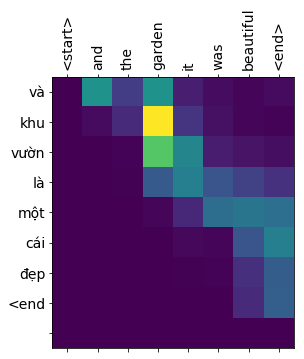


Input:  <start> and then somebody complained <end>
Groundtruth:  <start> rồi sau đó có người than phiền <end>
Translation:  <start> và một người phàn nàn <end>
Bleu Score:  20.33038389239877


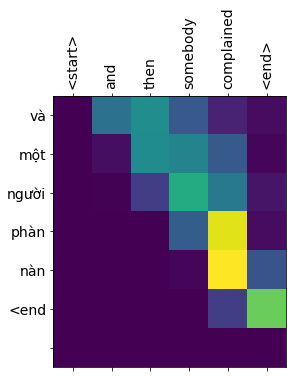


Input:  <start> the city came down on me and basically gave me a citation saying that i had to remove my garden which this citation was turning into a warrant <end>
Groundtruth:  <start> thành phố tới gặp tôi và đại khái là đưa cho tôi một công văn yêu cầu tôi phải phá bỏ mảnh vườn công văn đó sau này trở thành trát của toà <end>
Translation:  <start> thành phố đã đi xuống tôi và tôi cho tôi một lời nói rằng tôi đã bỏ đi bộ đồ gốm này <end>
Bleu Score:  15.707828309205809

Input:  <start> and im like come on really <end>
Groundtruth:  <start> và tôi như thể thôi nào thật à <end>
Translation:  <start> và tôi muốn nói về thực sự <end>
Bleu Score:  35.81345475522872


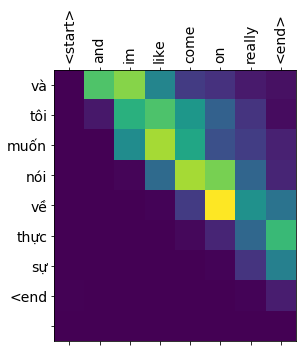


Input:  <start> a warrant for planting food on a piece of land that you could care less about <end>
Groundtruth:  <start> một trát hầu toà vì trồng cây trên mảnh đất mà các người không thèm quan tâm sao <end>
Translation:  <start> một nhà báo cáo cho những trại trồng trồng một loại đất nước bạn có thể quan tâm đến mức độ nào <end>
Bleu Score:  14.167966116048497

Input:  <start> and i was like cool bring it <end>
Groundtruth:  <start> và tôi nói rằng được mang tới đây <end>
Translation:  <start> và tôi rất thích thú vị nó <end>
Bleu Score:  35.81345475522872


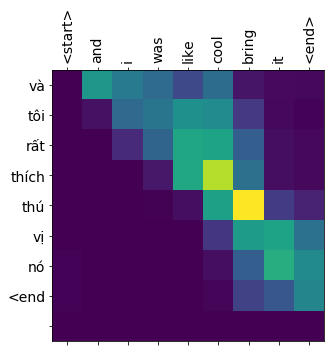


Input:  <start> because this time it wasnt coming up <end>
Groundtruth:  <start> vì lần này thì chuyện này không tới đâu <end>
Translation:  <start> bởi vì lần này không phải đi <end>
Bleu Score:  23.980236847348294


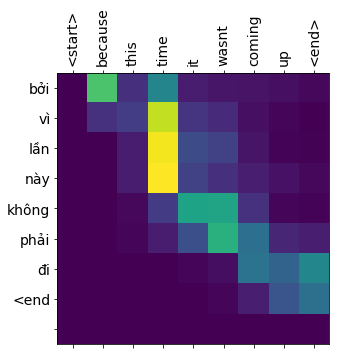


Input:  <start> so l a times got ahold of it steve lopez did a story on it and talked to the councilman and one of the green grounds members they put up a petition on change org and with 900 signatures we were a success <end>
Groundtruth:  <start> rồi tờ l a times nhận được tin steve lopez viết một bài báo về nó và bàn với uỷ viên hội đồng rồi một trong các thành viên của những mảnh đất xanh gửi một tờ đơn kiến nghị trên change org và với 900 chữ ký chúng tôi đã thành công <end>
Translation:  <start> vì vậy l a đã có một cái bánh qui may mắn steve jobs đã viết một câu chuyện và nói chuyện với một cái hộp màu xanh của họ đã đặt một sự kiện của sự thay đổi từ một sự kiện <end>
Bleu Score:  5.535427413432768

Input:  <start> we had a victory on our hands <end>
Groundtruth:  <start> chúng tôi đã có được một chiến thắng trong tay <end>
Translation:  <start> chúng tôi có một cuộc chiến thắng trong tay <end>
Bleu Score:  62.958356079187205

Input:  <start> my councilman even called in and sa

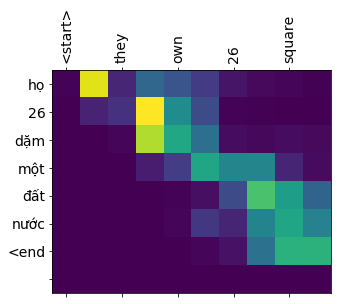


Input:  <start> thats 20 central parks <end>
Groundtruth:  <start> tương đương với 20 lần công viên trung tâm <end>
Translation:  <start> đó là trung quốc gia đình <end>
Bleu Score:  17.15978243390769


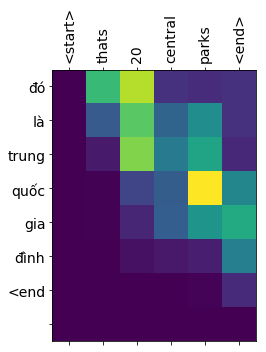


Input:  <start> thats enough space to plant 725 million tomato plants <end>
Groundtruth:  <start> đủ để trồng 725 triệu cây cà chua <end>
Translation:  <start> đó là đủ không gian để trồng cây trồng rau quả <end>
Bleu Score:  17.200673466668952

Input:  <start> why in the hell would they not okay this <end>
Groundtruth:  <start> làm sao họ có thể không đồng tình chứ <end>
Translation:  <start> tại sao ở đây sẽ không bao giờ đây <end>
Bleu Score:  17.678748653651848

Input:  <start> growing one plant will give you 1 000 10 000 seeds <end>
Groundtruth:  <start> trồng một cây sẽ cho bạn 1 000 10 000 hạt giống <end>
Translation:  <start> phát triển một con số sẽ cho bạn một nghìn nghìn hạt giống như thế nào <end>
Bleu Score:  16.367646742534795

Input:  <start> when one dollars worth of green beans will give you 75 dollars worth of produce <end>
Groundtruth:  <start> khi lượng đậu xanh có giá 1 đô la sẽ cho bạn lượng sản phẩm tương đương với 75 đô la <end>
Translation:  <start> khi một đô

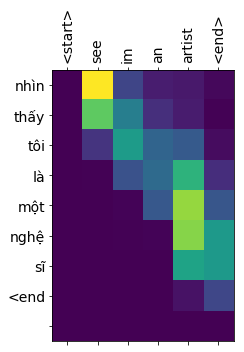


Input:  <start> gardening is my graffiti i grow my art <end>
Groundtruth:  <start> làm vườn là nghệ thuật của tôi tôi trồng ra tác phẩm của mình <end>
Translation:  <start> toà nhà máy tính của tôi là tôi là người nghệ thuật của tôi <end>
Bleu Score:  23.65370031518355

Input:  <start> just like a graffiti artist where they beautify walls me i beautiful lawns parkways <end>
Groundtruth:  <start> cũng giống như một hoạ sĩ người tô điểm cho các bức tường tôi tôi tô điểm cho những bãi cỏ lối đi dạo <end>
Translation:  <start> giống như một nghệ sĩ người mà chúng tôi đã làm phim với tôi những con gấu đỏ <end>
Bleu Score:  12.067309453151926

Input:  <start> i use the garden the soil like its a piece of cloth and the plants and the trees thats my embellishment for that cloth <end>
Groundtruth:  <start> tôi sử dụng mảnh vườn đất trồng như một tấm vải và cây trồng và cây xanh là những gì tôi tô điểm cho tấm vải đó <end>
Translation:  <start> tôi sử dụng vườn tượt với đất như vậy đó là một mả

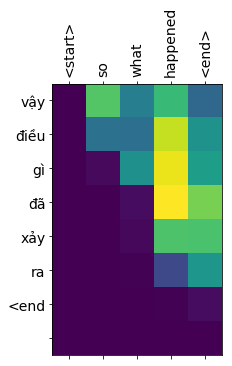


Input:  <start> i have witnessed my garden become a tool for the education a tool for the transformation of my neighborhood <end>
Groundtruth:  <start> tôi đã chứng kiến mảnh vườn của mình trở thành một công cụ giáo dục một công cụ cho sự chuyển đổi của vùng đất tôi sống <end>
Translation:  <start> tôi đã chứng kiến của tôi đã trở thành một công cụ cho giáo dục cho sự kết quả của mình <end>
Bleu Score:  39.82029647589244

Input:  <start> to change the community you have to change the composition of the soil <end>
Groundtruth:  <start> để thay đổi cộng đồng bạn phải thay đổi thành phần của đất <end>
Translation:  <start> để thay đổi cộng đồng bạn phải thay đổi sự phát triển của đất <end>
Bleu Score:  74.83293841345241

Input:  <start> we are the soil <end>
Groundtruth:  <start> chúng ta là đất <end>
Translation:  <start> chúng ta là đất <end>
Bleu Score:  100.00000000000004


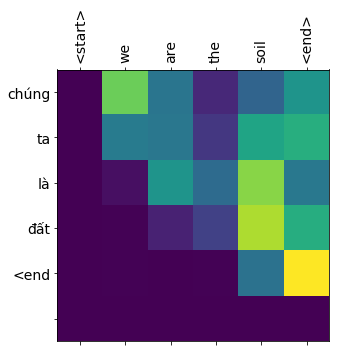


Input:  <start> youd be surprised how kids are affected by this <end>
Groundtruth:  <start> bạn sẽ ngạc nhiên khi thấy cách mà những đứa trẻ bị ảnh hưởng <end>
Translation:  <start> bạn sẽ ngạc nhiên làm thế nào trẻ em đang bị ảnh hưởng bởi những người này được trải qua bởi những người này bị ảnh hưởng bởi những người này được trải qua bởi những người này bị ảnh hưởng bởi những người này được trải qua bởi những người này bị ảnh hưởng bởi những người này được
Bleu Score:  11.267233317220857

Input:  <start> gardening is the most therapeutic and defiant act you can do especially in the inner city <end>
Groundtruth:  <start> làm vườn là công việc có tính trị liệu nhất và thách thức nhất mà bạn có thể làm đặc biệt là ở trong nội thành <end>
Translation:  <start> toà nhà làm là những kháng sinh và hiệu quả bạn có thể làm được trong thành phố <end>
Bleu Score:  14.434516190494517

Input:  <start> plus you get strawberries <end>
Groundtruth:  <start> với lại bạn còn thu được dâu nữa <end>
Tr

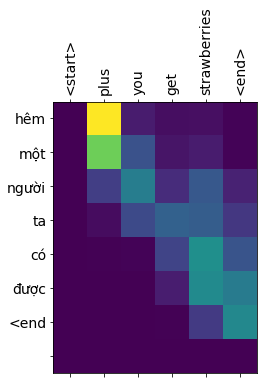


Input:  <start> i remember this time there was this mother and a daughter came it was like 10 30 at night and they were in my yard and i came out and they looked so ashamed <end>
Groundtruth:  <start> tôi nhớ có một lần có một người mẹ và con gái tới lúc đó là khoảng 10 30 tối và họ ở trong vườn của tôi rồi tôi đi ra ngoài và họ rất xấu hổ <end>
Translation:  <start> tôi nhớ rằng lúc này là mẹ này và con gái và cô ấy và nó đi 10 năm trời và chúng tôi nghĩ rằng xấu hổ <end>
Bleu Score:  20.544861901950256

Input:  <start> so im like man it made me feel bad that they were there and i told them you know you dont have to do this like this <end>
Groundtruth:  <start> tôi nghĩ trời ạ tôi cảm thấy rất tệ vì họ ở đó và tôi nói với họ rằng hai người biết đấy không cần phải làm như vậy <end>
Translation:  <start> tôi muốn người đàn ông ấy đã làm tôi cảm thấy rằng điều đó là những điều mà chúng tôi đã nói với họ bạn biết đấy bạn không biết phải như thế này <end>
Bleu Score:  15.132022567928296



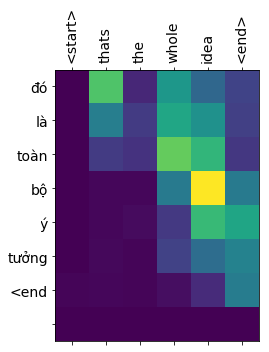


Input:  <start> i want them to take it but at the same time i want them to take back their health <end>
Groundtruth:  <start> tôi muốn họ lấy chúng nhưng cùng lúc đó tôi muốn họ có lại được sức khoẻ của mình <end>
Translation:  <start> tôi muốn chúng ta lấy nó nhưng cùng lúc đó tôi muốn chúng ta sẽ quay lại sức khoẻ <end>
Bleu Score:  41.63161587576388

Input:  <start> theres another time when i put a garden in this homeless shelter in downtown los angeles <end>
Groundtruth:  <start> có một lần khác khi tôi làm vườn tại một khu vô gia cư ở trung tâm los angeles <end>
Translation:  <start> một lúc khác khi tôi đặt một khu vườn nhỏ ở khu phố nhỏ ở khu phố ở khu phố ở trung tâm los angeles <end>
Bleu Score:  32.70534171825076

Input:  <start> these are the guys they helped me unload the truck <end>
Groundtruth:  <start> có mấy người đàn ông họ giúp tôi dỡ đồ từ xe tải <end>
Translation:  <start> đây là những người này đã giúp tôi đi vào tủ lạnh <end>
Bleu Score:  14.883068827552616

Inpu

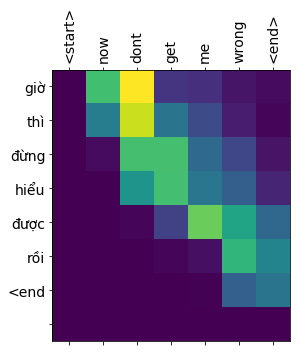


Input:  <start> im not talking about no free shit because free is not sustainable <end>
Groundtruth:  <start> tôi không nói về những thứ miễn phí bởi miễn phí thì không bền vững <end>
Translation:  <start> tôi không nói về không có một cách nào được miễn phí bởi vì không được bền vững <end>
Bleu Score:  44.903323241491265

Input:  <start> the funny thing about sustainability you have to sustain it <end>
Groundtruth:  <start> điều thú vị về sự bền vững đó là bạn phải duy trì nó <end>
Translation:  <start> điều thú vị về sự bền vững chắc chắn phải duy trì nó <end>
Bleu Score:  75.06935728875011

Input:  <start> what im talking about is putting people to work and getting kids off the street and letting them know the joy the pride and the honor in growing your own food opening farmers markets <end>
Groundtruth:  <start> tôi đang nói về việc giao công việc cho mọi người và kéo bọn trẻ ra khỏi phố và cho chúng biết niềm vui niềm tự hào và niềm vinh dự khi tự trồng thực phẩm cho mình mở chợ 

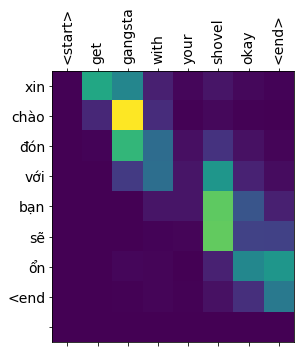


Input:  <start> and let that be your weapon of choice <end>
Groundtruth:  <start> và hãy biến nó thành vũ khí bạn chọn <end>
Translation:  <start> và để chúng ta là sự thiếu của bạn <end>
Bleu Score:  24.601372576927535

Input:  <start> so basically if you want to meet with me you know if you want to meet dont call me if you want to sit around in cushy chairs and have meetings where you talk about doing some shit where you talk about doing some shit <end>
Groundtruth:  <start> căn bản là nếu bạn muốn gặp tôi bạn biết đấy nếu bạn muốn gặp đừng gọi tôi nếu bạn muốn ngồi không trên những chiếc ghế êm ái và tham gia những cuộc họp nơi bạn nói về làm này làm nọ nơi bạn nói về làm này làm nọ vớ vẩn <end>
Translation:  <start> vì vậy nếu bạn muốn gặp một mình biết bạn muốn biết không muốn tôi muốn bạn ngồi quanh bàn chân dung và bạn có thể đi về một vài điều đó <end>
Bleu Score:  8.030609469082345

Input:  <start> if you want to meet with me come to the garden with your shovel so we can plan

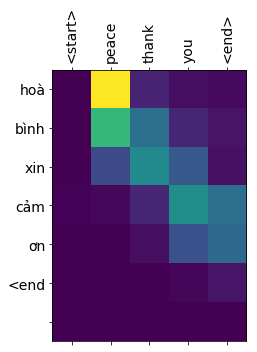


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.00000000000004


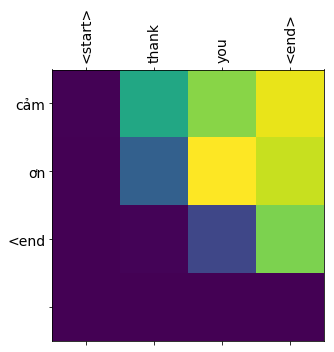


Input:  <start> this is where i live i live in kenya at the south parts of the nairobi national park <end>
Groundtruth:  <start> đây là nơi tôi sống tôi sống ở kenya phía nam công viên quốc gia nairobi <end>
Translation:  <start> đây là nơi tôi sống ở kenya ở nam giới ở trung quốc <end>
Bleu Score:  47.50593394626161

Input:  <start> those are my dads cows at the back and behind the cows thats the nairobi national park <end>
Groundtruth:  <start> phía sau tôi là đàn bò của bố tôi và phía sau đàn bò là công viên quốc gia nairobi <end>
Translation:  <start> những con tôi là bò của tôi ở giữa con bò tót đó là trường trung quốc <end>
Bleu Score:  12.375785212401757

Input:  <start> nairobi national park is not fenced in the south widely which means wild animals like zebras migrate out of the park freely <end>
Groundtruth:  <start> công viên quốc gia nairobi không được rào chắn trên diện rộng ở khu vực phía nam điều đó có nghĩa là các động vật hoang dã như ngựa vằn thoát ra khỏi công viên 

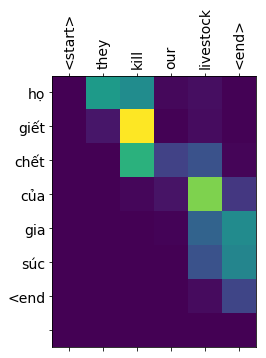


Input:  <start> this is one of the cows which was killed at night and i just woke up in the morning and i found it dead and i felt so bad because it was the only bull we had <end>
Groundtruth:  <start> đây là một trong số những con bò đã bị giết vào buổi tối và khi thức dậy vào buổi sáng tôi tìm thấy nó đã chết và tôi đã cảm thấy rất buồn bởi vì đó là con bò đực duy nhất mà chúng tôi có <end>
Translation:  <start> đây là một con bò đó bị giết trong đêm và tôi đã thức dậy vào buổi sáng và tôi thấy rằng nó đã chết và tôi cảm thấy rằng tôi xấu hổ vì nó chỉ là con bò tót mà chúng tôi <end>
Bleu Score:  33.20156189028522

Input:  <start> my community the maasai we believe that we came from heaven with all our animals and all the land for herding them and thats why we value them so much <end>
Groundtruth:  <start> cộng đồng của tôi người maasai tin rằng chúng tôi đến từ thiên đường cùng với tất cả các con vật của mình và tất cả đất đai để chăn giữ chúng đó là lý do vì sao chúng tôi rất coi 

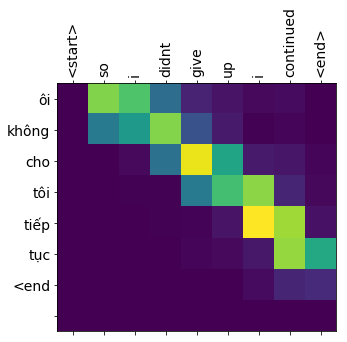


Input:  <start> and a second idea i got was to use a scarecrow <end>
Groundtruth:  <start> và ý tưởng thứ hai của tôi đó là sử dụng bù nhìn <end>
Translation:  <start> và ý tưởng thứ hai tôi có một con chíp <end>
Bleu Score:  44.96473903155595

Input:  <start> i was trying to trick the lions 91 into thinking 93 that i was standing near the cowshed <end>
Groundtruth:  <start> tôi đã cố gắng đánh lừa những con sư tử đó 91 vào cái suy nghĩ 93 là tôi đứng gần chuồng bò <end>
Translation:  <start> tôi đang cố gắng thuyết phục những con sư tử đang suy nghĩ rằng tôi đã đứng yên lặng <end>
Bleu Score:  24.216074199509688

Input:  <start> but lions are very clever <end>
Groundtruth:  <start> nhưng sư tử rất thông minh <end>
Translation:  <start> nhưng sư tử học rất thông minh <end>
Bleu Score:  76.11606003349888


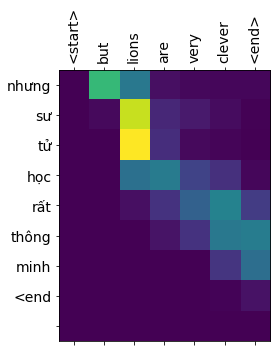


Input:  <start> they will come the first day and they see the scarecrow and they go back but the second day theyll come and they say this thing is not moving here its always here <end>
Groundtruth:  <start> chúng tới ngày đầu tiên và nhìn thấy con bù nhìn và rồi chúng quay về nhưng ngày thứ 2 chúng đến và nói rằng thứ này không hề chuyển động nó luôn luôn chỉ ở đó <end>
Translation:  <start> họ sẽ đến ngày đầu tiên và họ nhìn thấy con vật và chúng tôi quay lại nhưng ngày hôm sau họ sẽ nói chuyện này đây không phải di chuyển ở đây <end>
Bleu Score:  14.171446468443575

Input:  <start> so he jumps in and kills the animals <end>
Groundtruth:  <start> và rồi sư tử nhảy vào và giết gia súc <end>
Translation:  <start> vì thế là anh ta nhảy vào và con vật <end>
Bleu Score:  20.751552684616424

Input:  <start> so one night i was walking around the cowshed with a torch and that day the lions didnt come <end>
Groundtruth:  <start> vì thế vào một đêm tôi cầm một cây đuốc đi xung quanh chuồng bò 

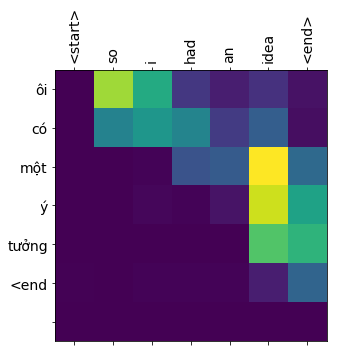


Input:  <start> since i was a small boy i used to work in my room for the whole day and i even took apart my moms new radio and that day she almost killed me but i learned a lot about electronics <end>
Groundtruth:  <start> từ khi còn nhỏ tôi đã từng làm việc ở trong phòng mình cả ngày và tôi thậm chí đã mở tung chiếc radio mới mua của mẹ vào hôm đó bà gần như giết tôi nhưng tôi đã học được nhiều điều về điện <end>
Translation:  <start> bởi vì tôi là một cậu bé nhỏ tôi đã làm việc trong phòng tôi vào ngày và tôi thậm chí tôi đã mất đi mẹ tôi một cái tên một cái mới và sau đó cô ấy đã gặp tôi đã học được nhiều về điện thoại <end>
Bleu Score:  22.359778225564558

Input:  <start> so i got an old car battery an indicator box its a small device found in a motorcycle and it helps motorists when they want to turn right or left it blinks <end>
Groundtruth:  <start> thế nên tôi đã lấy một bình ắc quy xe ô tô cũ một hộp đồng hồ đo nó là một thiết bị nhỏ được tìm thấy ở xe mô tô và nó giúp người

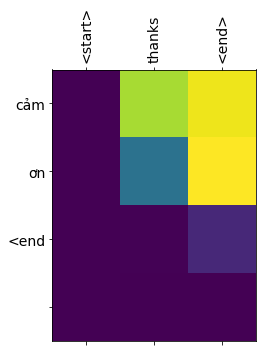


Input:  <start> so i set it up in my home two years ago and since then we have never experienced any problem with lions <end>
Groundtruth:  <start> tôi đã lắp đặt nó ở nhà mình 2 năm trước kể từ đó chúng tôi không hề gặp phải bất cứ vấn đề nào với sư tử cả <end>
Translation:  <start> tôi đã làm nó trong 2 năm về trước và sau đó chúng tôi chưa bao giờ trải qua bất kỳ bất kỳ gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì với những gì
Bleu Score:  8.605491591482158

Input:  <start> and my neighboring homes heard about this idea <end>
Groundtruth:  <start> các gia đình hàng xóm nghe kể về ý tưởng này <end>
Translation:  <start> và những con người tôi đã từng nghe về ý tưởng này <end>
Bleu Score:  41.180376356915765

Input:  <start> one of them was this grandmother <end>
Groundtruth:  <start> một trong số đó là người bà này <end>
Translation:  <start> một trong số họ là cô ấy <end>
Bleu Score

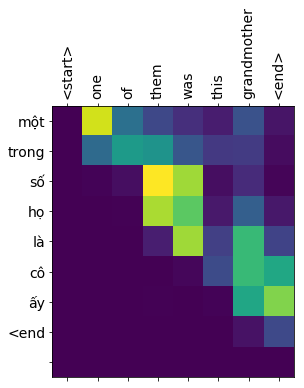


Input:  <start> she had a lot of her animals being killed by lions and she asked me if i could put the lights for her <end>
Groundtruth:  <start> bà có nhiều gia súc đã bị sư tử giết và bà đã hỏi tôi liệu tôi có thể giúp bà lắp các bóng điện <end>
Translation:  <start> cô ấy đã có rất nhiều con vật sống của cô ấy bị giết bởi những con sư tử và cô ấy hỏi tôi nếu tôi có thể đặt đèn đèn <end>
Bleu Score:  10.951432109048614

Input:  <start> and i said yes <end>
Groundtruth:  <start> tôi trả lời vâng <end>
Translation:  <start> và tôi nói vâng <end>
Bleu Score:  39.281465090051285


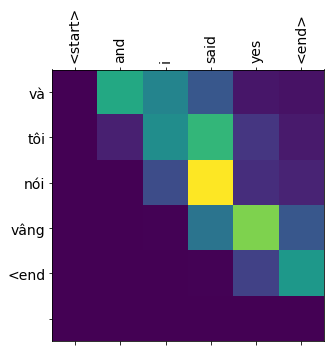


Input:  <start> so i put the lights you can see at the back those are the lion lights <end>
Groundtruth:  <start> thế là tôi lắp đặt các bóng đèn các bạn có thể nhìn thấy ở đằng sau chúng là các bóng đèn sư tử <end>
Translation:  <start> tôi đặt ánh sáng bạn có thể thấy ở đây là những con sư tử <end>
Bleu Score:  20.613207136071267

Input:  <start> since now ive set up seven homes around my community and theyre really working <end>
Groundtruth:  <start> cho đến nay tôi đã giúp lắp đặt cho 7 hộ gia đình trong cộng đồng của mình và chúng đều hoạt động hiệu quả <end>
Translation:  <start> vì vậy bây giờ tôi đã đi lên 7 nhà hàng xóm và tôi thực sự làm việc <end>
Bleu Score:  8.839506385434458

Input:  <start> and my idea is also being used now all over kenya for scaring other predators like hyenas leopards and its also being used to scare elephants away from peoples farms <end>
Groundtruth:  <start> hiện nay ý tưởng của tôi đã được sử dụng trên khắp kenya để xua đuổi các động vật ăn thịt 

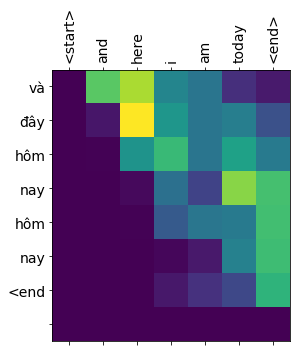


Input:  <start> i got a chance to come by plane for my first time for ted <end>
Groundtruth:  <start> tôi đã có cơ hội đi đến đây bằng máy bay lần đầu tiên để tham gia ted <end>
Translation:  <start> tôi có cơ hội để đi bằng máy bay đầu tiên của ted <end>
Bleu Score:  30.727330735735077

Input:  <start> so my big dream is to become an aircraft engineer and pilot when i grow up <end>
Groundtruth:  <start> ước mơ lớn nhất của tôi là trở thành một kỹ sư máy bay và phi công khi lớn lên <end>
Translation:  <start> ước mơ của tôi là trở thành một máy tính sinh viên và tôi đã lớn lên <end>
Bleu Score:  46.246771105673346

Input:  <start> i used to hate lions but now because my invention is saving my fathers cows and the lions we are able to stay with the lions without any conflict <end>
Groundtruth:  <start> tôi đã từng ghét sư tử nhưng bây giờ bởi vì phát minh của tôi đang cứu đàn bò của bố và sư tử chúng tôi có thể sống chung với sư tử mà không có bất cứ xung đột nào <end>
Translation:  <s

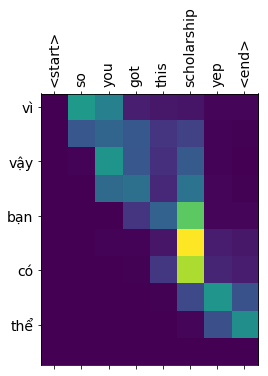


Input:  <start> youre working on other electrical inventions <end>
Groundtruth:  <start> cháu đang làm những phát minh về điện khác <end>
Translation:  <start> bạn đang làm việc sử dụng các thiết bị điện tử khác <end>
Bleu Score:  22.250253290431033

Input:  <start> whats the next one on your list <end>
Groundtruth:  <start> phát minh nào tiếp theo trong danh sách của cháu <end>
Translation:  <start> điều gì tiếp theo là gì trong danh sách của anh <end>
Bleu Score:  28.63424630911014

Input:  <start> my next invention is i want to make an electric fence electric fence <end>
Groundtruth:  <start> phát minh sắp tới của cháu cháu muốn làm một hàng rào điện hàng rào điện sao <end>
Translation:  <start> sáng tạo của tôi là tôi muốn tạo một cái cây cối xay gió <end>
Bleu Score:  11.417084020749108

Input:  <start> but i know electric fences are already invented but i want to make mine <end>
Groundtruth:  <start> cháu biết là hàng rào điện đã được phát minh rồi nhưng cháu muốn làm cái của ri

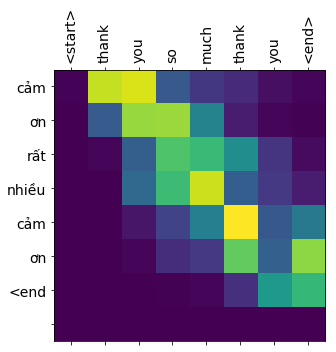


Input:  <start> everything i do and everything i do professionally my life has been shaped by seven years of work as a young man in africa <end>
Groundtruth:  <start> những gì tôi làm và những gì tôi làm chuyên về cuộc đời tôi đã được đinh hình trong bảy năm làm việc tại châu phi khi còn trẻ <end>
Translation:  <start> mọi thứ tôi làm và mọi thứ tôi làm việc làm việc cuộc sống của tôi đã được tạo ra bởi 7 năm để làm một người đàn ông <end>
Bleu Score:  13.009868453084907

Input:  <start> from 1971 to 1977 i look young but im not i worked in zambia kenya ivory coast algeria somalia in projects of technical cooperation with african countries <end>
Groundtruth:  <start> từ năm 1971 đến 1977 trông tôi trẻ thế chứ không phải vậy đâu tôi đã làm việc tại zambia kenya ivory coast algeria somalia trong những dự án hợp tác về kỹ thuật với những quốc gia châu phi <end>
Translation:  <start> từ năm 1977 2004 tôi muốn tôi đã làm việc ở brazil có vườn rừng rậm tây ban nha salazar ở tây ban nha sala

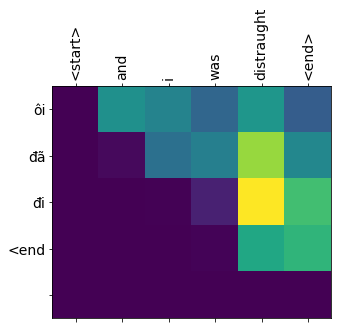


Input:  <start> i thought age 21 that we italians were good people and we were doing good work in africa <end>
Groundtruth:  <start> mới 21 tuổi đời tôi nghĩ người ý là người tốt và chúng tôi đang làm việc tốt tại châu phi <end>
Translation:  <start> tôi nghĩ đến 21 tuổi chúng tôi là người dân chúng tôi là những người và chúng tôi đang làm tốt hơn trong châu phi <end>
Bleu Score:  31.719068523657043

Input:  <start> instead everything we touched we killed <end>
Groundtruth:  <start> nhưng thay vì thế chúng tôi giết chết mọi thứ mà chúng tôi đụng vào <end>
Translation:  <start> thay vì mọi thứ chúng ta đã khiến chúng ta đã giết chết <end>
Bleu Score:  16.215956018564686

Input:  <start> our first project the one that has inspired my first book ripples from the zambezi was a project where we italians decided to teach zambian people how to grow food <end>
Groundtruth:  <start> dự án đầu tiên cái đã truyền cảm hứng cho cuốn sách đầu tiên của tôi những cơn sóng nhẹ từ zambezi là một dự án 

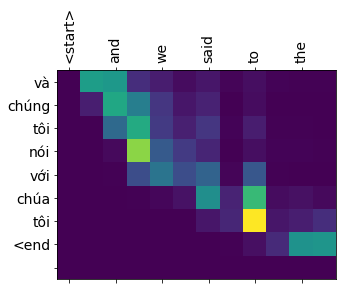


Input:  <start> and the zambians said yes thats why we have no agriculture here <end>
Groundtruth:  <start> và người dân đáp rằng vâng đó là lí do tại sao chúng tôi chẳng trồng thứ gì ở đây cả <end>
Translation:  <start> và nói chuyện này là lý do tại sao chúng ta không có nông nghiệp ở đây <end>
Bleu Score:  23.319176489092225

Input:  <start> quot why didnt you tell us you never asked <end>
Groundtruth:  <start> quot thế tại sao mọi người không cho chúng tôi biết trước anh có bao giờ hỏi đâu <end>
Translation:  <start> quot tại sao bạn không nói với chúng ta không bao giờ hỏi được <end>
Bleu Score:  20.39784800681338

Input:  <start> i thought it was only us italians blundering around africa but then i saw what the americans were doing what the english were doing what the french were doing and after seeing what they were doing i became quite proud of our project in zambia <end>
Groundtruth:  <start> tôi đã nghĩ chỉ có mỗi người ý là khờ khạo trên đất châu phi nhưng sau đó khi tôi nh

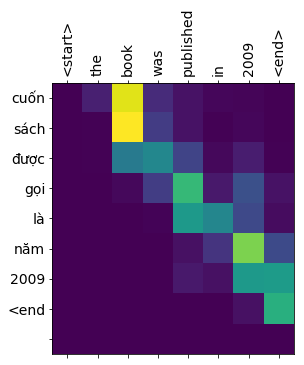


Input:  <start> we western donor countries have given the african continent two trillion american dollars in the last 50 years <end>
Groundtruth:  <start> chúng ta những quốc gia viện trợ tây phương đã mang đến lục địa châu phi 2 tỉ tỉ mỹ kim trong vòng 50 năm qua <end>
Translation:  <start> chúng tôi đã ủng hộ các quốc gia có được phát triển châu phi 2 tỉ đô la mỹ 50 năm <end>
Bleu Score:  20.944270374877302

Input:  <start> im not going to tell you the damage that that money has done <end>
Groundtruth:  <start> tôi sẽ không nói với bạn những thiệt hại mà số tiền đó đã gây ra <end>
Translation:  <start> tôi sẽ không nói với các bạn biết rằng sự tổn thương rằng tiền bạc đã làm được <end>
Bleu Score:  36.263054614196875

Input:  <start> just go and read her book <end>
Groundtruth:  <start> hãy tìm đọc cuốn sách của bà ấy <end>
Translation:  <start> chỉ ra và đọc sách <end>
Bleu Score:  19.193856766522426


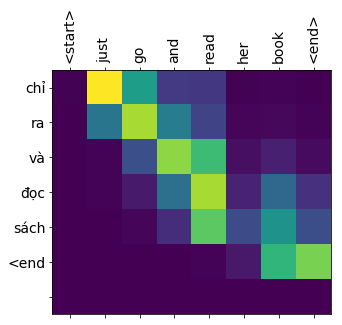


Input:  <start> read it from an african woman the damage that we have done <end>
Groundtruth:  <start> đọc nó từ một người phụ nữ châu phi những thiệt hại mà chúng ta đã gây ra <end>
Translation:  <start> đọc nó từ một người phụ nữ châu phi thường xuyên chúng ta đã làm <end>
Bleu Score:  58.18833921755769

Input:  <start> we western people are imperialist colonialist missionaries and there are only two ways we deal with people we either patronize them or we are paternalistic <end>
Groundtruth:  <start> những người tây phương như chúng ta là những người theo chủ nghĩa đế quốc thực dân truyền giáo và chúng ta chỉ có hai cách để đối xử với người khác hoặc bảo trợ hoặc bảo hộ <end>
Translation:  <start> chúng tôi có những người dân không được đối mặt với các chương trình dân chủ và có một vài cách chúng ta đối phó với người ta hay chúng ta <end>
Bleu Score:  8.295706495853386

Input:  <start> the two words come from the latin root pater which means father <end>
Groundtruth:  <start> hai t

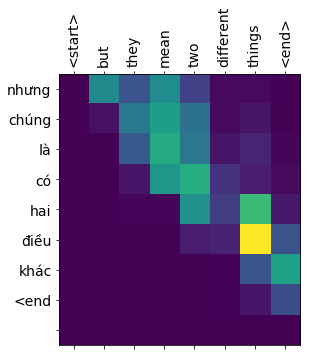


Input:  <start> paternalistic i treat anybody from a different culture as if they were my children i love you so much <end>
Groundtruth:  <start> bảo hộ là tôi đối xử với bất cứ người nào đến từ nền văn hoá khác như thể họ là con tôi tôi yêu chúng quá <end>
Translation:  <start> tôi có ý nghĩa gì đó một xã hội khác nhau như thế nào nếu chúng tôi là những đứa trẻ em yêu quý vị <end>
Bleu Score:  8.699980184918553

Input:  <start> patronizing i treat everybody from another culture as if they were my servants <end>
Groundtruth:  <start> bảo trợ tôi đối xử với tất cả mọi người từ nền văn hoá khác như đầy tớ của mình <end>
Translation:  <start> một câu trả lời tôi có thể mọi người từ mọi người văn hoá khác như là nếu họ là người <end>
Bleu Score:  19.665864691817674

Input:  <start> thats why the white people in africa are called bwana boss <end>
Groundtruth:  <start> đó là lí do tại sao người da trắng tại châu phi được gọi là bwana ông chủ <end>
Translation:  <start> đó là lý do tại sao n

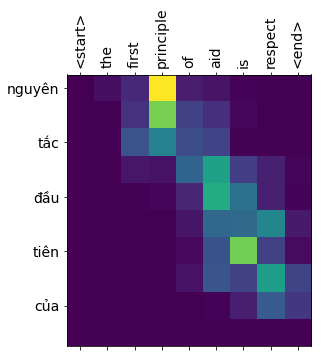


Input:  <start> this morning the gentleman who opened this conference lay a stick on the floor and said can we can you imagine a city that is not neocolonial <end>
Groundtruth:  <start> sáng nay người tổ chức buổi họp này đặt một cây gậy ra sàn nhà và nói liệu chúng ta có thể hình dung về một thành phố mà không phải là chủ nghĩa thực dân mới không <end>
Translation:  <start> buổi sáng lập tức này hội nghị này là một cái gậy trên sàn và nói có thể chúng tôi có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có thể bạn có
Bleu Score:  3.8060718506189493

Input:  <start> i decided when i was 27 years old to only respond to people and i invented a system called enterprise facilitation where you never initiate anything you never motivate anybody but you become a servant of the local passion the servant of local people who have a dream to become a better person <end>
Groundtruth:  <start> khi 27 tuổi tôi đã quy

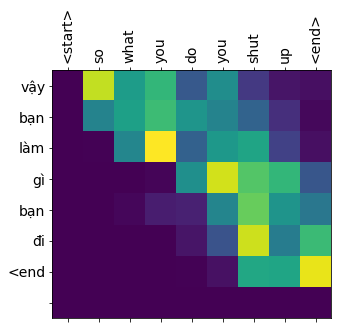


Input:  <start> you never arrive in a community with any ideas and you sit with the local people <end>
Groundtruth:  <start> đừng bao giờ mang đến một cộng đồng với những ý tưởng bạn ngồi với người bản địa <end>
Translation:  <start> bạn chưa bao giờ đến một cộng đồng với bất cứ ý tưởng và bạn ngồi với những người dân địa phương <end>
Bleu Score:  28.574404296987996

Input:  <start> we dont work from offices <end>
Groundtruth:  <start> chúng tôi không làm việc từ những văn phòng <end>
Translation:  <start> chúng ta không làm việc từ văn phòng <end>
Bleu Score:  58.088877148404045


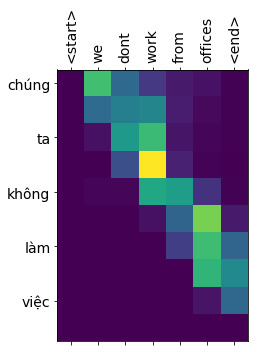


Input:  <start> we meet at the cafe we meet at the pub <end>
Groundtruth:  <start> chúng tôi gặp gỡ tại quán cà phê quán rượu <end>
Translation:  <start> chúng tôi gặp một quán cà phê chúng tôi gặp nhau ở quán cà phê <end>
Bleu Score:  34.79731564184223

Input:  <start> we have zero infrastructure <end>
Groundtruth:  <start> chúng tôi không có bất cứ cơ sở hạ tầng nào <end>
Translation:  <start> chúng ta có những cơ sở hạ tầng <end>
Bleu Score:  36.086384747950035


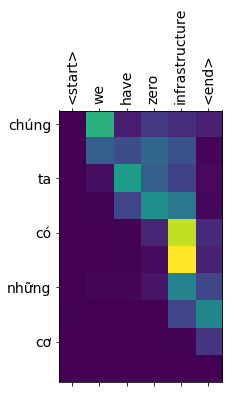


Input:  <start> and what we do we become friends and we find out what that person wants to do <end>
Groundtruth:  <start> và cái chúng tôi làm là trở thành bạn của nhau và tìm ra cái mà người đó muốn làm <end>
Translation:  <start> và chúng tôi làm gì chúng tôi trở thành một người bạn và tìm thấy điều mà con người muốn làm gì <end>
Bleu Score:  19.83099979449509

Input:  <start> the most important thing is passion <end>
Groundtruth:  <start> cái quan trọng nhất là khát vọng <end>
Translation:  <start> điều quan trọng nhất là đam mê <end>
Bleu Score:  35.74046404361828


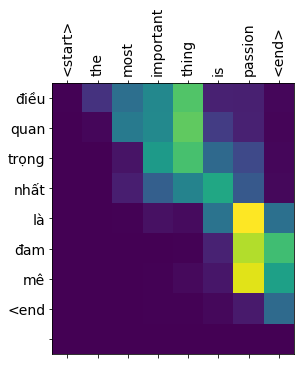


Input:  <start> you can give somebody an idea <end>
Groundtruth:  <start> bạn có thể cho ai đó một ý tưởng <end>
Translation:  <start> bạn có thể cho ai đó một ý tưởng <end>
Bleu Score:  100.00000000000004

Input:  <start> if that person doesnt want to do it what are you going to do <end>
Groundtruth:  <start> nếu người đó không muốn làm vậy thì bạn phải làm sao <end>
Translation:  <start> nếu người không muốn làm điều đó là gì bạn sẽ làm gì <end>
Bleu Score:  33.12498979466408

Input:  <start> the passion that the person has for her own growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của người phụ nữ có cho sự phát triển của bản thân là thứ quan trọng nhất <end>
Translation:  <start> đam mê của người đã được sự phát triển của tôi là sự quan trọng nhất <end>
Bleu Score:  34.1270421358261

Input:  <start> the passion that that man has for his own personal growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của nam giới có cho sự phá

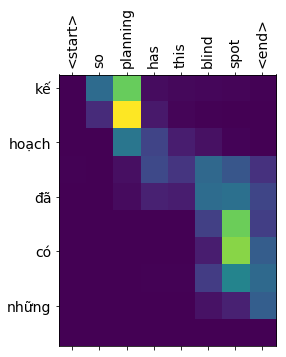


Input:  <start> the smartest people in your community you dont even know because they dont come to your public meetings <end>
Groundtruth:  <start> những người thông thái nhất trong cộng đồng bạn chẳng bao giờ biết được vì họ chẳng đời nào đến dự những buổi họp công cộng <end>
Translation:  <start> người thông tin tốt nhất trong cộng đồng bạn không còn vì họ không phải đi đến những cuộc họp hành <end>
Bleu Score:  21.24570424936033

Input:  <start> what we do we work one on one and to work one on one you have to create a social infrastructure that doesnt exist <end>
Groundtruth:  <start> cái chúng tôi làm là làm việc một đối một và để làm điều đó bạn phải tạo ra một cấu trúc xã hội hiện không tồn tại <end>
Translation:  <start> chúng tôi làm gì chúng tôi làm gì đó một cái gì đó và làm việc một cái bạn phải tạo ra một cơ sở hạ tầng không phải tồn tại <end>
Bleu Score:  29.85931495407864

Input:  <start> you have to create a new profession <end>
Groundtruth:  <start> bạn phải tạo ra một

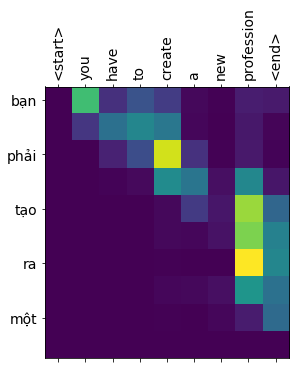


Input:  <start> the profession is the family doctor of enterprise the family doctor of business who sits with you in your house at your kitchen table at the cafe and helps you find the resources to transform your passion into a way to make a living <end>
Groundtruth:  <start> một chuyên ngành mới như một bác sỹ gia đình cho doanh nghiệp bác sỹ gia đình cho công việc làm ăn người ngồi với bạn trong nhà bạn tại bàn cơm trong bếp tại quán cà phê và giúp bạn tìm ra những nguồn tài nguyên để biến khát vọng của bạn thành một phương cách kiếm sống <end>
Translation:  <start> công việc là gia đình tôi là bác sĩ của anh chị với các bạn trong nhà bếp ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm ở phòng tắm
Bleu Score:  4.769571504363708

Input:  <start> i started this as a tryout in esperance in western australia <end>
Groundtruth:  <start> tôi đã bắt đầu như một sự thử nghiệm tại espe

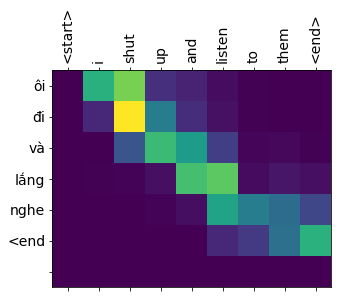


Input:  <start> so so the government says do it again <end>
Groundtruth:  <start> vậy nên vậy nên chính phủ nói với tôi cứ làm tiếp nhé <end>
Translation:  <start> vì thế nên chính phủ đã nói nó lại <end>
Bleu Score:  17.53528352255253

Input:  <start> weve done it in 300 communities around the world <end>
Groundtruth:  <start> chúng tôi đã làm thế tại 300 cộng đồng trên khắp thế giới <end>
Translation:  <start> chúng tôi đã làm nó vào 300 cộng đồng trên khắp thế giới <end>
Bleu Score:  79.12619863720215

Input:  <start> we have helped to start 40 000 businesses <end>
Groundtruth:  <start> chúng tôi đã giúp khởi động 40 000 công việc làm ăn <end>
Translation:  <start> chúng tôi đã giúp đỡ từ những doanh nghiệp <end>
Bleu Score:  40.283800593319796

Input:  <start> there is a new generation of entrepreneurs who are dying of solitude <end>
Groundtruth:  <start> có một thế hệ doanh nhân mới những người đang kiệt quệ vì sự cô lập <end>
Translation:  <start> có một thế hệ mới là những ngườ

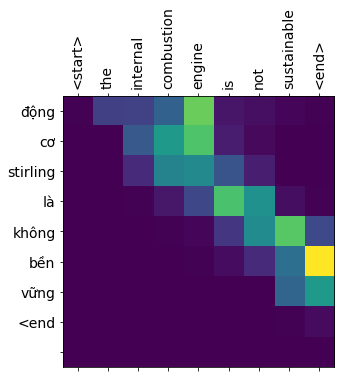


Input:  <start> freon way of maintaining things is not sustainable <end>
Groundtruth:  <start> đường lối freon để lưu trữ các thứ là không bền vững <end>
Translation:  <start> cách nào để duy trì sự không có sự bền vững <end>
Bleu Score:  28.547397706062934

Input:  <start> what we have to look at is at how we feed cure educate transport communicate for seven billion people in a sustainable way <end>
Groundtruth:  <start> cái mà chúng ta phải nhìn đến đó là chúng ta làm thế nào để nuôi dưỡng chữa trị giáo dục di chuyển và liên lạc cho 7 tỉ người theo hướng bền vững <end>
Translation:  <start> chúng ta phải nhìn vào đó là cách chúng ta chữa bệnh aids để tiếp cận với hàng tỉ người dân số một cách bền vững <end>
Bleu Score:  20.7152216731238

Input:  <start> the technologies do not exist to do that <end>
Groundtruth:  <start> không có công nghệ nào làm được điều đó <end>
Translation:  <start> công nghệ không phải tồn tại với việc đó <end>
Bleu Score:  27.22589423069701

Input:  <start> w

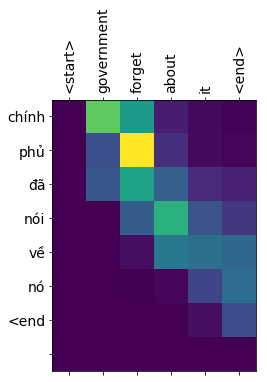


Input:  <start> it will be entrepreneurs and theyre doing it now <end>
Groundtruth:  <start> đó sẽ là các danh nhân và họ đang thực hiện điều đó ngay hiện nay <end>
Translation:  <start> nó sẽ là những nhà kinh doanh và họ đang làm điều này <end>
Bleu Score:  16.38215651356958

Input:  <start> theres a lovely story that i read in a futurist magazine many many years ago <end>
Groundtruth:  <start> có một câu chuyện rất vui mà tôi đọc được trên một tờ tạp chí vị lai nhiều năm về trước <end>
Translation:  <start> một câu chuyện tuyệt vời mà tôi đọc được một tạp chí wired đã rất nhiều năm trước <end>
Bleu Score:  28.768422508410207

Input:  <start> there was a group of experts who were invited to discuss the future of the city of new york in 1860 <end>
Groundtruth:  <start> có một nhóm chuyên gia được mời đến để thảo luận về tương lai của thành phố new york năm 1860 <end>
Translation:  <start> có một nhóm các chuyên gia mà tôi đã mời đến thảo luận tương lai của thành phố new york <end>
Bl

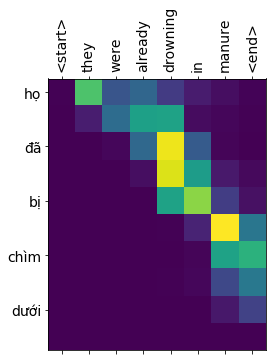


Input:  <start> so 1860 they are seeing this dirty technology that is going to choke the life out of new york <end>
Groundtruth:  <start> vậy nên vào năm 1860 họ nhìn thấy cái công nghệ nhem nhuốc này cái mà làm cho cuộc sống ở thành phố new york ngộp thở <end>
Translation:  <start> vậy nên năm 2007 họ đang thấy những loại thuốc này là để ngăn chặn sự sống của mình <end>
Bleu Score:  15.461316533727992

Input:  <start> so what happens in 40 years time in the year 1900 in the united states of america there were 1 001 car manufacturing companies 1 001 <end>
Groundtruth:  <start> vậy điều gì đã xảy ra trong vòng 40 năm tới thời điểm 1900 tại mỹ có khoảng 1 001 công ty sản xuất xe hơi 1 001 <end>
Translation:  <start> vậy điều gì xảy ra trong 40 năm 1900 trong năm 1900 ở mỹ ở mỹ có một tiếng anh có một bệnh viện công ty một đô la <end>
Bleu Score:  23.905570811115602

Input:  <start> the idea of finding a different technology had absolutely taken over and there were tiny tiny little facto

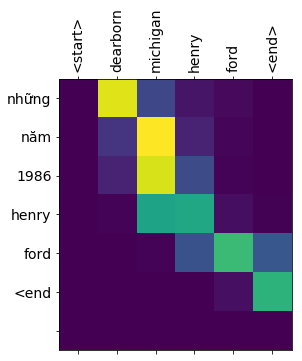


Input:  <start> however there is a secret to work with entrepreneurs <end>
Groundtruth:  <start> tuy nhiên có một bí mật để làm việc với các doanh nhân <end>
Translation:  <start> tuy nhiên có một bí mật để làm việc với các doanh nghiệp <end>
Bleu Score:  84.92326635760686

Input:  <start> first you have to offer them confidentiality <end>
Groundtruth:  <start> trước tiên bạn phải mang đến cho họ sự bảo mật <end>
Translation:  <start> đầu tiên bạn phải cung cấp cho họ <end>
Bleu Score:  21.25304016609316


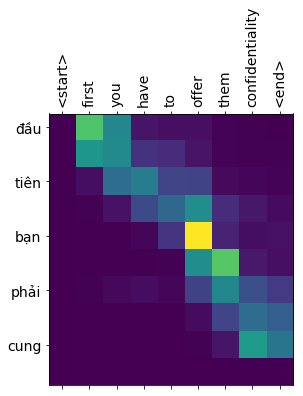


Input:  <start> otherwise they dont come and talk to you <end>
Groundtruth:  <start> không thì họ sẽ chẳng tìm đến mà nói chuyện với bạn <end>
Translation:  <start> nếu không có gì đến và nói với bạn <end>
Bleu Score:  29.17182576494273

Input:  <start> then you have to offer them absolute dedicated passionate service to them <end>
Groundtruth:  <start> sau đó bạn phải mang đến cho họ một dịch vụ tuyệt đối riêng biệt và say mê <end>
Translation:  <start> sau đó bạn phải cung cấp cho họ tuyệt vời của mình để làm việc họ <end>
Bleu Score:  32.47218901610984

Input:  <start> and then you have to tell them the truth about entrepreneurship <end>
Groundtruth:  <start> và sau đó bạn phải nói với họ sự thật về kinh doanh <end>
Translation:  <start> và bạn phải nói với họ là sự thật kinh doanh <end>
Bleu Score:  53.833149247982014

Input:  <start> the smallest company the biggest company has to be capable of doing three things beautifully the product that you want to sell has to be fantastic y

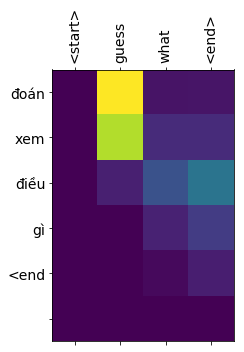


Input:  <start> we have never met a single human being in the world who can make it sell it and look after the money <end>
Groundtruth:  <start> chúng ta chưa bao giờ gặp một cá nhân nào trên thế giới người mà vừa có thể làm ra bán nó và quản lí tiền bạc cùng lúc <end>
Translation:  <start> chúng ta chưa bao giờ gặp một người duy nhất trên thế giới mà người có thể làm cho nó và xem sau đó <end>
Bleu Score:  38.56487786422427

Input:  <start> it doesnt exist <end>
Groundtruth:  <start> điều đó không tồn tại <end>
Translation:  <start> nó không tồn tại <end>
Bleu Score:  59.54165059120785


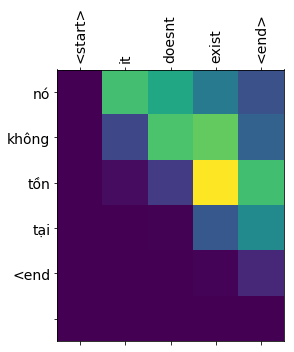


Input:  <start> this person has never been born <end>
Groundtruth:  <start> nhân vật này chưa bao giờ được sinh ra <end>
Translation:  <start> người này chưa bao giờ được sinh ra <end>
Bleu Score:  72.85959997974687


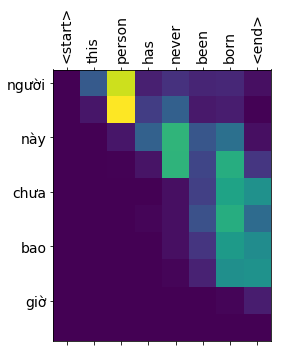


Input:  <start> weve done the research and we have looked at the 100 iconic companies of the world carnegie westinghouse edison ford all the new companies google yahoo <end>
Groundtruth:  <start> chúng tôi đã làm một nghiên cứu và xem xét 100 công ty tiêu biểu trên thế giới carnegie westinghouse edison ford tất cả công ty mới google yahoo <end>
Translation:  <start> chúng tôi đã làm việc nghiên cứu và chúng tôi nhìn vào 100 nhân tạo những thành viên các công ty lớn các ngôi trường đại học đại dương ted com <end>
Bleu Score:  23.613201777761322

Input:  <start> theres only one thing that all the successful companies in the world have in common only one none were started by one person <end>
Groundtruth:  <start> chỉ có một điều mà tất cả mọi công ty thành công trên thế giới đều có chỉ một mà thôi đó là không một công ty nào bắt đầu chỉ với một người <end>
Translation:  <start> chỉ có một điều mà tất cả các công ty công nghệ trên thế giới có một nơi không chỉ là một người không <end>
Ble

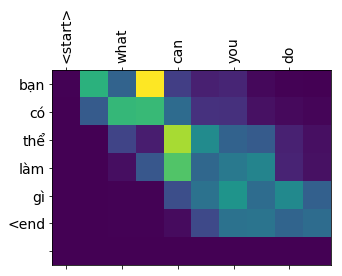


Input:  <start> okay can you sell it can you look after the money <end>
Groundtruth:  <start> okay bạn có thể bán nó không bạn có thể quản lí tiền bạc không <end>
Translation:  <start> ok bạn có thể bán nó có thể bạn có thể nhìn vào đó <end>
Bleu Score:  32.97891327043529

Input:  <start> quot oh no i cannot do this would you like me to find you somebody <end>
Groundtruth:  <start> quot oh không tôi không thể làm được điều này bạn có muốn tôi tìm ai khác cho bạn không <end>
Translation:  <start> quot ồ tôi không thể làm điều này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như
Bleu Score:  7.911223895726585

Input:  <start> we activate communities <end>
Groundtruth:  <start> chúng tôi kích hoạt những cộng đồng <end>
Translation:  <start> chúng ta có thể liên hệ cộng đồng <end>
Bleu Score:  44.534504264163466


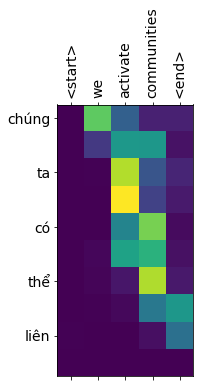


Input:  <start> we have groups of volunteers supporting the enterprise facilitator to help you to find resources and people and we have discovered that the miracle of the intelligence of local people is such that you can change the culture and the economy of this community just by capturing the passion the energy and imagination of your own people <end>
Groundtruth:  <start> chúng tôi có những nhóm tình nguyện viên trợ giúp cho enterprise facilitator họ giúp tìm kiếm những nguồn tài nguyên và con người và chúng tôi khám phá ra rằng cái phép lạ từ trí thông minh của người bản địa như cái gì đó giống như là bạn có thể thách thức nền văn hoá và kinh tế của cộng đồng này chỉ bằng cách nắm được cái khát vọng nguồn năng lượng và trí tưởng tượng như thể của người dân của bạn <end>
Translation:  <start> chúng ta có những nhóm các giáo viên đồng nghiệp dư dả tiền cho việc hỗ trợ giúp đỡ cho phép bạn tìm thấy những nguồn tài trợ cấp độ và mọi người và chúng tôi đã khám phá hoại những sự thông m

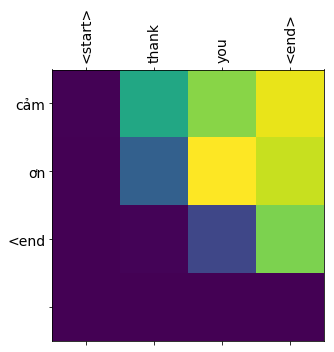


Input:  <start> before march 2011 i was a photographic retoucher based in new york city <end>
Groundtruth:  <start> cho đến tháng ba 2011 tôi làm thợ chỉnh sửa ảnh tại thành phố new york <end>
Translation:  <start> trước khi cuộc đua năm 2011 tôi đã là một bộ phim hoạt động dựa trên new york <end>
Bleu Score:  21.647200687300835

Input:  <start> were pale gray creatures <end>
Groundtruth:  <start> chúng tôi là những sinh vật xanh xao <end>
Translation:  <start> chúng ta là một số các loài vật chất khổng lồ <end>
Bleu Score:  22.048872820716333

Input:  <start> we hide in dark windowless rooms and generally avoid sunlight <end>
Groundtruth:  <start> ẩn trong bóng tối căn phòng không cửa sổ và nói chung là tránh ánh nắng mặt trời <end>
Translation:  <start> chúng tôi đã ở bên ngoài đường phố và thông tin và ánh sáng mặt trời <end>
Bleu Score:  20.879620448678583

Input:  <start> we make skinny models skinnier perfect skin more perfect and the impossible possible and we get criticized in

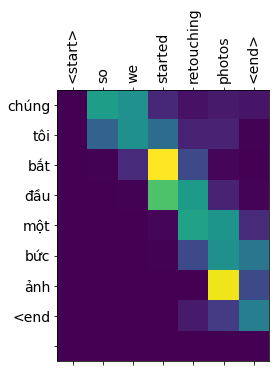


Input:  <start> this was the very first <end>
Groundtruth:  <start> đây là tấm đầu tiên <end>
Translation:  <start> đây là lần đầu tiên <end>
Bleu Score:  70.16879391277372


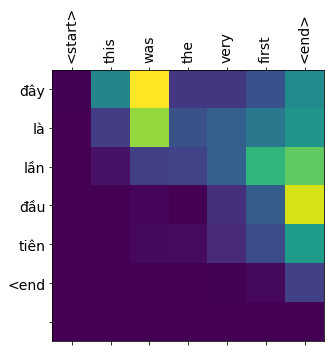


Input:  <start> not terribly damaged but where the water had caused that discoloration on the girls face had to be repaired with such accuracy and delicacy <end>
Groundtruth:  <start> không bị hư hỏng trầm trọng nhưng chỗ bị thấm nước khiến đổi màu khuôn mặt cô gái phải được sửa chữa với độ chính xác và tinh vi cao <end>
Translation:  <start> không hề bị tổn thương nhưng nó có nước này đã gây ra nó trong đó trong những người phụ nữ đã phải được chữa được với chính xác và xanh <end>
Bleu Score:  13.610902668776577

Input:  <start> otherwise that little girl isnt going to look like that little girl anymore and surely thats as tragic as having the photo damaged <end>
Groundtruth:  <start> nếu không bé gái trong hình sẽ không còn trông giống em nữa và chắc chắn điều đó cũng tồi tệ như việc tấm ảnh bị hư hại vậy <end>
Translation:  <start> nếu không biết ơn cô ấy trông như thế này nghe như thế này nghe như thế này nghe như thế này nghe như thế này nghe như thế này nghe như thế này nghe như

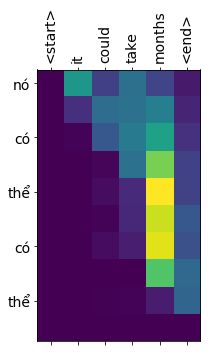


Input:  <start> the kimono in this shot pretty much had to be hand drawn or pieced together picking out the remaining parts of color and detail that the water hadnt damaged <end>
Groundtruth:  <start> chiếc kimono trong bức ảnh này gần như phải được vẽ lại bằng tay hoặc chắp ghép từ các phần màu sắc và chi tiết còn lại chưa bị nước làm hư hại <end>
Translation:  <start> nhật bản ở đây chụp ảnh này đã phải đóng góp hoặc đóng góp tất cả các màu sắc và chi tiết <end>
Bleu Score:  15.707828309205809

Input:  <start> it was very time consuming <end>
Groundtruth:  <start> nó rất tốn thời gian <end>
Translation:  <start> đó là thời gian <end>
Bleu Score:  47.53852732567741


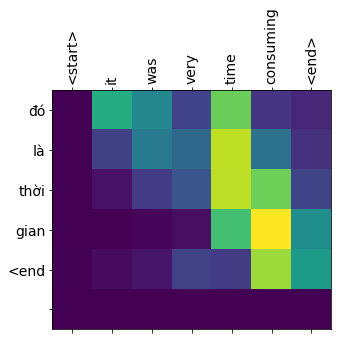


Input:  <start> now all these photos had been damaged by water submerged in salt water covered in bacteria in sewage sometimes even in oil all of which over time is going to continue to damage them so hand cleaning them was a huge part of the project <end>
Groundtruth:  <start> bấy giờ tất cả những hình ảnh này đã bị nước làm hư hại bị nhấn chìm trong nước muối bị bao phủ bởi vi khuẩn trong nước thải đôi khi cả trong dầu suốt một quãng thời gian nên chúng sẽ tiếp tục thêm hư hại thế nên lau sạch chúng là một phần rất lớn của dự án <end>
Translation:  <start> tất cả những bức ảnh này được hoàn toàn bị đốt trên nước muối <end>
Bleu Score:  1.9546713896444292

Input:  <start> we couldnt retouch the photo unless it was cleaned dry and reclaimed <end>
Groundtruth:  <start> chúng tôi không thể chỉnh sửa nếu ảnh không được làm sạch phơi khô và cải tạo <end>
Translation:  <start> chúng tôi không thể được chụp ảnh chụp trừ khi nó được dọn sạch và tái chế <end>
Bleu Score:  33.535699101570344



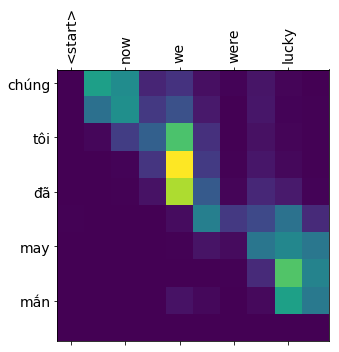


Input:  <start> we had an amazing local woman who guided us <end>
Groundtruth:  <start> có một người phụ nữ địa phương tuyệt vời đã hướng dẫn chúng tôi <end>
Translation:  <start> chúng tôi có một người phụ nữ vô cùng một người phụ nữ có một người phụ nữ có một người phụ nữ có một người phụ nữ có một người phụ nữ <end>
Bleu Score:  15.603008975439616

Input:  <start> its very easy to do more damage to those damaged photos <end>
Groundtruth:  <start> rất dễ gây thêm hư hại cho những hình ảnh đã hư hại này <end>
Translation:  <start> dễ dàng để làm tổn thương để làm những bức ảnh <end>
Bleu Score:  13.281232295956377

Input:  <start> as my team leader wynne once said its like doing a tattoo on someone <end>
Groundtruth:  <start> trưởng nhóm wynne của tôi từng nói nó cũng giống như xăm cho ai đó <end>
Translation:  <start> khi tôi là người lãnh đạo của tôi một người nói một cái nút một người <end>
Bleu Score:  12.653094028246672

Input:  <start> you dont get a chance to mess it up <end>


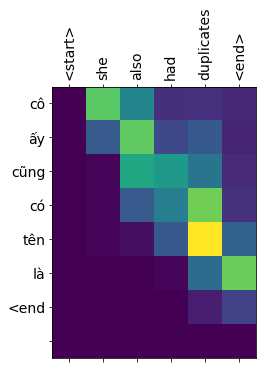


Input:  <start> areas like her husband and her face which otherwise would have been completely impossible to fix we could just put them together in one good photo and remake the whole photo <end>
Groundtruth:  <start> nếu không những chỗ như chồng và khuôn mặt cô sẽ không bao giờ có thể được khắc phục chỉ có thể đặt họ gần nhau trong một bức ảnh lành khác và làm lại toàn bộ bức hình <end>
Translation:  <start> các vùng như những người chồng cô ấy và mặt của mình và nó theo cách mà nó sẽ hoàn toàn không thể để sửa chữa chúng lại với nhau <end>
Bleu Score:  6.6686653973377945

Input:  <start> when she collected the photos from us she shared a bit of her story with us <end>
Groundtruth:  <start> khi nhận lại các bức ảnh từ chúng tôi cô ấy đã chia sẻ một chút câu chuyện của mình <end>
Translation:  <start> khi cô ấy thu thập những bức ảnh từ chúng tôi đã chia sẻ một câu chuyện với chúng tôi <end>
Bleu Score:  39.752449434225106

Input:  <start> her photos were found by her husbands collea

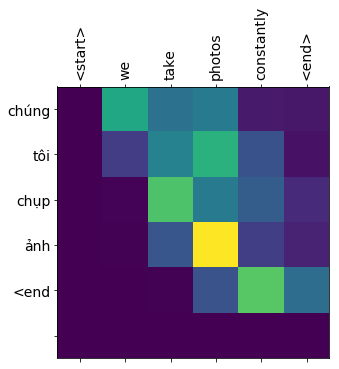


Input:  <start> a photo is a reminder of someone or something a place a relationship a loved one <end>
Groundtruth:  <start> mỗi bức ảnh gợi nhắc về ai đó hoặc một cái gì đó một nơi một mối quan hệ một người thân yêu <end>
Translation:  <start> một bức ảnh là một sự nhắc nhở một người hay một cái gì đó một nơi mà một mối quan hệ một người khác <end>
Bleu Score:  39.774589541974024

Input:  <start> theyre our memory keepers and our histories the last thing we would grab and the first thing youd go back to look for <end>
Groundtruth:  <start> chúng là những vật lưu giữ kỉ niệm và câu chuyện của chúng ta là điều cuối cùng chúng ta còn bám víu lấy và cũng là thứ đầu tiên ta quay lại kiếm tìm <end>
Translation:  <start> chúng tôi nhớ của chúng tôi và lịch sử của chúng tôi đã lấy lại và bạn điều bạn sẽ quay lại <end>
Bleu Score:  10.16457693993414

Input:  <start> thats all this project was about about restoring those little bits of humanity giving someone that connection back <end>
Groundt

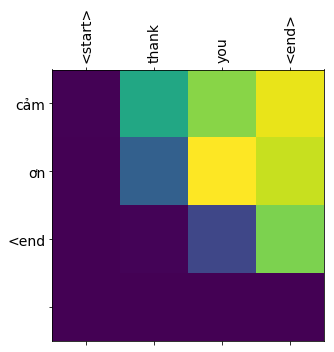


Input:  <start> im 150 feet down an illegal mine shaft in ghana <end>
Groundtruth:  <start> tôi ở độ sâu gần 50m dưới 1 hầm mỏ bất hợp pháp tại ghana <end>
Translation:  <start> tôi 150 triệu feet xuống một cái búa của tôi ở ghana <end>
Bleu Score:  24.363633252477864

Input:  <start> the air is thick with heat and dust and its hard to breathe <end>
Groundtruth:  <start> không khí đặc quánh bụi và hơi nóng và rất khó thở <end>
Translation:  <start> không khí nhỏ nhiệt độ và nhiệt độ và nó khó để thở <end>
Bleu Score:  34.11488281065382

Input:  <start> i can feel the brush of sweaty bodies passing me in the darkness but i cant see much else <end>
Groundtruth:  <start> tôi có thể cảm nhận sự va chạm từ những thân thể bóng nhẫy mồ hôi lướt qua trong bóng tối nhưng chẳng thể thấy gì hơn <end>
Translation:  <start> tôi có thể cảm thấy chiếc máy tính của mình để đi tôi vào bóng tối nhưng tôi không thể thấy nhiều <end>
Bleu Score:  26.046484801908107

Input:  <start> i hear voices talking b

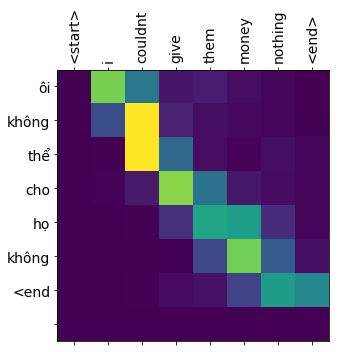


Input:  <start> i wasnt a citizen of that country <end>
Groundtruth:  <start> tôi không phải công dân nước đó <end>
Translation:  <start> tôi không phải là một tổ chức của đất nước <end>
Bleu Score:  39.375553105513404

Input:  <start> i could get them in a worse situation than they were already in <end>
Groundtruth:  <start> tôi có thể đưa họ vào tình cảnh tệ hơn hiện tại của họ <end>
Translation:  <start> tôi có thể được chúng ở trong tình trạng tồi tệ hơn họ đã được <end>
Bleu Score:  32.28213880040184

Input:  <start> id have to rely on free the slaves to work within the system for their liberation and i trusted that they would <end>
Groundtruth:  <start> tôi phải dựa vào tổ chức giải phóng nô lệ để hoạt động trong hệ thống để giải phóng họ và tôi tin họ có thể <end>
Translation:  <start> tôi phải dựa vào một chiến dịch được làm việc làm việc trong hệ thống để giải phóng và tôi tin tưởng rằng họ sẽ <end>
Bleu Score:  40.493354086688285

Input:  <start> as for me id have to wait un

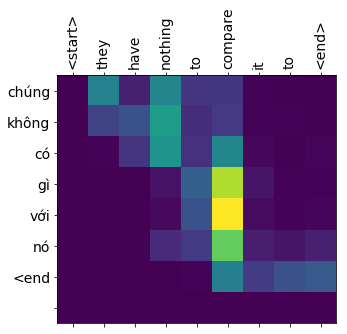


Input:  <start> when these villagers claimed their freedom the slaveholders burned down all of their houses <end>
Groundtruth:  <start> khi người dân làng này đòi tự do những chủ nô đốt sạch nhà của họ <end>
Translation:  <start> khi những người dân số người tự do của họ đã bị đốt cháy tất cả các ngôi nhà <end>
Bleu Score:  18.85850947396187

Input:  <start> i mean these people had nothing and they were so petrified they wanted to give up but the woman in the center rallied for them to persevere and abolitionists on the ground helped them get a quarry lease of their own so that now they do the same back breaking work but they do it for themselves and they get paid for it and they do it in freedom <end>
Groundtruth:  <start> những người này không có gì họ chết điếng họ muốn đầu hàng nhưng người phụ nữ ở giữa trấn tĩnh và kêu gọi mọi người kiên trì và những người theo chủ nghĩa bãi nô tại hiện trường giúp họ lấy được hợp đồng cho thuê mỏ đá của chính mình để giờ đây họ vẫn làm công việc

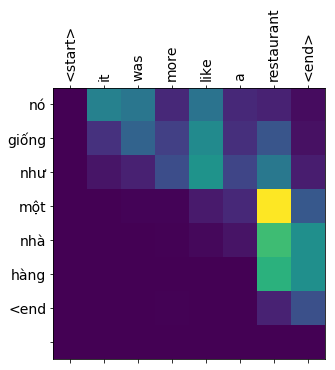


Input:  <start> cabin restaurants as theyre known in the trade are venues for forced prostitution <end>
Groundtruth:  <start> những nhà hàng phân buồng như được biết đến trong ngành là những địa điểm của nạn mại dâm cưỡng ép <end>
Translation:  <start> những nhà hàng xóm như chúng được biết được trong những người bị thương mại đang bị buộc tội phạm <end>
Bleu Score:  25.609516769327904

Input:  <start> each has small private rooms where the slaves women along with young girls and boys some as young as seven years old are forced to entertain the clients encouraging them to buy more food and alcohol <end>
Groundtruth:  <start> mỗi nơi có phòng riêng nhỏ nơi các nô lệ phụ nữ cùng trẻ em trai và gái một số mới 7 tuổi bị buộc giải khuây cho khách hàng dụ họ mua thêm rượu và đồ ăn <end>
Translation:  <start> mỗi người nhỏ những người mà người thợ nề phụ nữ trẻ em gái nhỏ bé gái tuổi thọ trung đông và bị buộc phải cứu chữa lành và uống <end>
Bleu Score:  10.586933894540218

Input:  <start> e

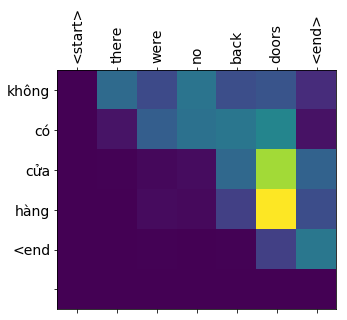


Input:  <start> there were no windows large enough to climb through <end>
Groundtruth:  <start> chẳng có cửa sổ đủ lớn mà chui lọt <end>
Translation:  <start> không có cửa sổ đủ lớn lên tới <end>
Bleu Score:  40.73224091836954


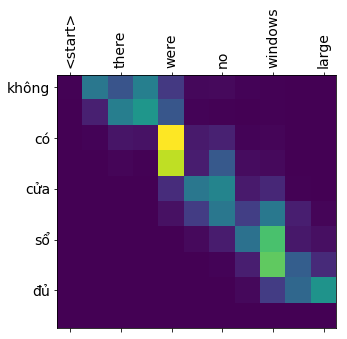


Input:  <start> these people have no escape at all and as we take in such a difficult subject its important to note that slavery including sex trafficking occurs in our own backyard as well <end>
Groundtruth:  <start> những người này không có lối thoát nào khi ta đề cập về chủ đề khó khăn như thế cần nhớ rằng nô lệ bao gồm nô lệ của nạn mua bán tình dục cũng xảy ra tại nơi chúng ta đang sống <end>
Translation:  <start> những người này không hề có sự bỏ đi và tất cả chúng ta lấy một tin tưởng rất quan trọng với những con đường này được những người tị nạn ở nhà thờ nhà thờ <end>
Bleu Score:  15.505065195344827

Input:  <start> tens of hundreds of people are enslaved in agriculture in restaurants in domestic servitude and the list can go on <end>
Groundtruth:  <start> hàng chục ngàn người bị bắt làm nô lệ trong nông nghiệp trong nhà hàng đầy tớ khổ sai trong nhà và danh sách còn dài <end>
Translation:  <start> hàng trăm người đã được thực hiện ở nông nghiệp ở các nhà trong các nhà trong 

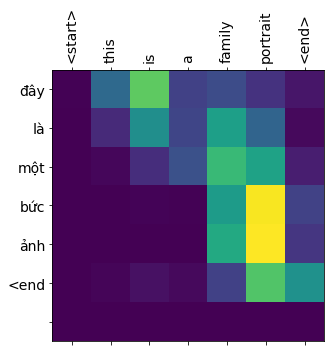


Input:  <start> the dyed black hands are the father while the blue and red hands are his sons <end>
Groundtruth:  <start> đôi tay nhuộm đen là người cha những bàn tay xanh và đỏ là con trai ông ấy <end>
Translation:  <start> cái chai rượu đen là khi bố khi màu xanh và đỏ và da đỏ và con số và con cá sấu <end>
Bleu Score:  12.65417535065352

Input:  <start> they mix dye in these big barrels and they submerge the silk into the liquid up to their elbows but the dye is toxic <end>
Groundtruth:  <start> họ trộn thuốc nhuộm trong những thùng lớn và nhúng lụa vào dung dịch đó ngập đến khuỷ tay dù thuốc nhuộm rất độc <end>
Translation:  <start> chúng kích thích hợp chất này những cây nhỏ và chúng va chạm vào trong tủ lạnh và nó chứa chất độc hại <end>
Bleu Score:  9.055537054073794

Input:  <start> my interpreter told me their stories <end>
Groundtruth:  <start> người phiên dịch của tôi kể chuyện của họ <end>
Translation:  <start> phiên bản của tôi nói với câu chuyện của tôi <end>
Bleu Score:

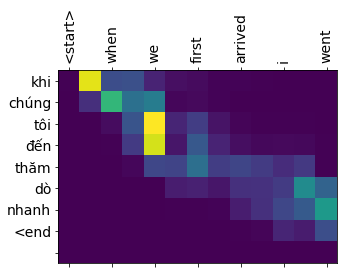


Input:  <start> i saw what seemed to be a family fishing on a boat two older brothers some younger kids makes sense right <end>
Groundtruth:  <start> tôi thấy cảnh giống như 1 gia đình đang đánh cá trên thuyền 2 anh trai vài đứa nhỏ hơn có vẻ hợp lí nhỉ <end>
Translation:  <start> tôi thấy những gì có vẻ như là một gia đình đã từng có một con cá sấu một đứa trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái trẻ em bé gái
Bleu Score:  7.414256483333439

Input:  <start> wrong they were all enslaved <end>
Groundtruth:  <start> sai họ đều bị nô lệ <end>
Translation:  <start> sai lầm chúng được chế tạo <end>
Bleu Score:  30.66148710292676


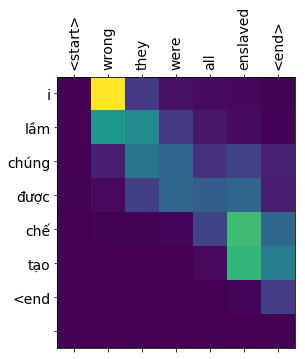


Input:  <start> children are taken from their families and trafficked and vanished and theyre forced to work endless hours on these boats on the lake even though they do not know how to swim <end>
Groundtruth:  <start> trẻ em bị đưa khỏi gia đình buôn bán và mất tích và bị bắt làm việc không ngừng nghỉ trên những con thuyền này ở hồ này dù chúng không biết bơi <end>
Translation:  <start> trẻ em được đưa ra gia đình họ bị nhiễm và bị buộc và chúng bị buộc tội phạm vào những chiếc thuyền này ở đó không có thể biết được làm gì <end>
Bleu Score:  18.475400087736983

Input:  <start> this young child is eight years old <end>
Groundtruth:  <start> đứa trẻ này 8 tuổi <end>
Translation:  <start> đứa trẻ nhỏ tám tuổi <end>
Bleu Score:  58.77283725105324


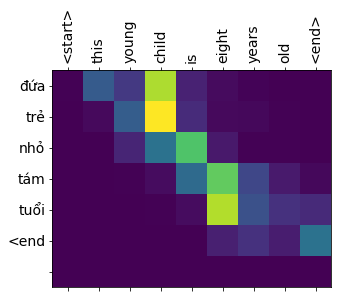


Input:  <start> he was trembling when our boat approached frightened it would run over his tiny canoe <end>
Groundtruth:  <start> em run rẩy khi thuyền của chúng tôi đến gần cứ sợ thuyền đè qua cái canoe bé xíu của em <end>
Translation:  <start> ông ấy đã bị hôn chân của chúng tôi đến nỗi sợ hãi nó đi bộ những con trâu <end>
Bleu Score:  16.47474414881191

Input:  <start> he was petrified he would be knocked in the water <end>
Groundtruth:  <start> cậu bé khiếp đảm vì sợ rơi xuống nước <end>
Translation:  <start> ông ấy sợ hãi ông ấy bị kẹt trong nước <end>
Bleu Score:  22.894156860669913

Input:  <start> the skeletal tree limbs submerged in lake volta often catch the fishing nets and weary frightened children are thrown into the water to untether the lines <end>
Groundtruth:  <start> những cành cây gãy tụ vào hồ volta thường vướng vào lưới đánh cá và những đứa trẻ vừa mệt lử vừa sợ hãi bị đẩy xuống nước để gỡ lưỡi câu <end>
Translation:  <start> cây cọ cao su được thả lên ở hồng kông

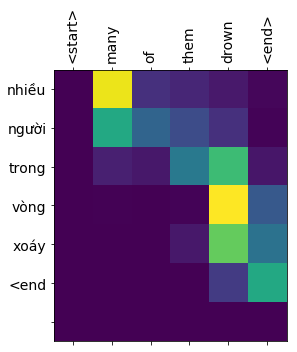


Input:  <start> for as long as he can recall hes been forced to work on the lake <end>
Groundtruth:  <start> những gì cậu bé nhớ được là em bị bắt làm việc ở hồ <end>
Translation:  <start> khi còn có thể nhớ lại anh ta bị buộc phải làm việc ở trường <end>
Bleu Score:  16.202795457177032

Input:  <start> terrified of his master he will not run away and since hes been treated with cruelty all his life he passes that down to the younger slaves that he manages <end>
Groundtruth:  <start> quá sợ người chủ em không dám chạy trốn và vì bị đối xử tàn tệ từ nhỏ em tiếp diễn điều đó xuống những nô lệ nhỏ hơn mà em quản lý <end>
Translation:  <start> sợ hãi của anh ấy sẽ không chạy trốn và từ khi ông ấy đã được chữa trị với những con người anh ta đã bị bắt tay vào những người <end>
Bleu Score:  9.101128958870529

Input:  <start> i met these boys at five in the morning when they were hauling in the last of their nets but they had been working since 1 a m <end>
Groundtruth:  <start> tôi gặp những 

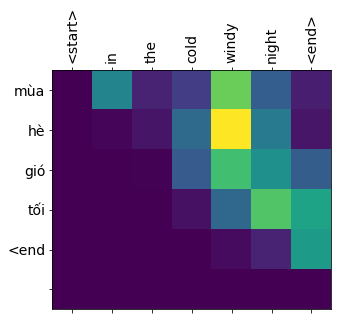


Input:  <start> and its important to note that these nets weigh more than a thousand pounds when theyre full of fish <end>
Groundtruth:  <start> cần lưu ý rằng những chiếc lưới này nặng gần 500kgs khi chúng đầy cá <end>
Translation:  <start> và điều đó là quan trọng với những loại này được kích cỡ hơn một nghìn bảng trắng khi chúng được những con cá voi <end>
Bleu Score:  9.23806317622409

Input:  <start> i want to introduce you to kofi <end>
Groundtruth:  <start> tôi muốn giới thiệu kofi với bạn <end>
Translation:  <start> tôi muốn giới thiệu với các bạn phải kofi annan <end>
Bleu Score:  48.892302243490086

Input:  <start> kofi was rescued from a fishing village <end>
Groundtruth:  <start> kofi được cứu từ 1 làng chài <end>
Translation:  <start> kofi bị cứu từ một nhà hàng triệu người <end>
Bleu Score:  26.518122980477767

Input:  <start> i met him at a shelter where free the slaves rehabilitates victims of slavery <end>
Groundtruth:  <start> tôi gặp cậu bé ở khu cứu trợ mà tổ chức 

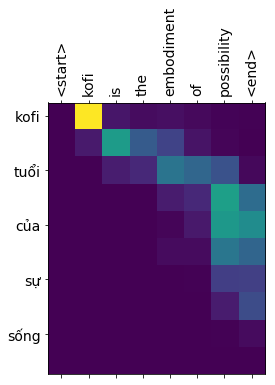


Input:  <start> who will he become because someone took a stand and made a difference in his life <end>
Groundtruth:  <start> em sẽ trở thành người thế nào nếu có ai đó đứng lên và thay đổi cuộc đời em <end>
Translation:  <start> ai cũng đã trở thành một người khác đã đặt một người đứng dậy và làm một sự khác biệt trong cuộc đời <end>
Bleu Score:  11.017841899461907

Input:  <start> driving down a road in ghana with partners of free the slaves a fellow abolitionist on a moped suddenly sped up to our cruiser and tapped on the window <end>
Groundtruth:  <start> lái xe trên đường ở ghana cũng những đồng nghiệp trong tổ chức giải phóng nô lệ 1 anh bạn thuộc những người theo chủ nghĩa bãi nô đi xe gắn máy bất ngờ tăng tốc lên ngang xe chúng tôi và gõ vào cửa kính <end>
Translation:  <start> lái xe hơi ở ghana với một người trong một người bạn là một người bạn <end>
Bleu Score:  6.489432264929722

Input:  <start> he told us to follow him down a dirt road into the jungle <end>
Groundtruth:  

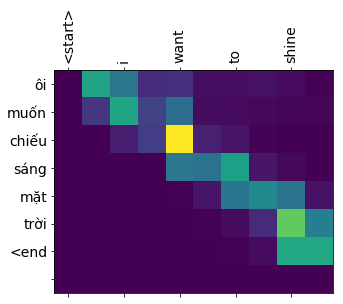


Input:  <start> when i was working in the field i brought lots of candles with me and with the help of my interpreter i imparted to the people i was photographing that i wanted to illuminate their stories and their plight so when it was safe for them and safe for me i made these images <end>
Groundtruth:  <start> khi làm việc trong lãnh vực này tôi mang theo rất nhiều nến với sự giúp đỡ của người phiên dịch tôi truyền đạt với những người mà mình chụp hình rằng tôi muốn soi sáng câu chuyện và hoàn cảnh của họ rồi khi họ và tôi được an toàn tôi chụp những tấm hình này <end>
Translation:  <start> khi tôi đang làm việc ở trường tôi đã rất nhiều chiếc máy tính với tôi và với những người giúp đỡ của tôi tôi đã chăm sóc tôi những bức ảnh tôi tôi muốn chiếu sáng những điều này <end>
Bleu Score:  12.62838033948632

Input:  <start> they knew their image would be seen by you out in the world <end>
Groundtruth:  <start> họ biết hình của họ sẽ được xem bởi những người ở ngoài kia như bạn <end>
Tra

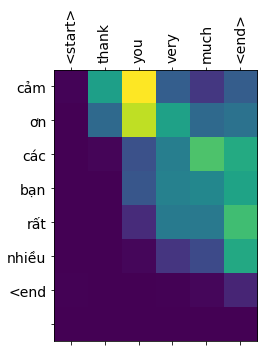

In [56]:
import sacrebleu

translation_result = []

for i in range(len(pairs_2)):
    # Prepare the English sentence
    en_sentence = pairs_2[i][0].strip("<start>").strip("<end>").strip()
    
    # Get the translation and other results
    vi_result, en_sentence, attention_plot = evaluate(
        en_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ
    )
    
    # Add the start token to the translation result
    vi_result = '<start> ' + vi_result.strip()
    vi_groundtruth = pairs_2[i][1]
    
    # Calculate BLEU score using sacrebleu
    bleu = sacrebleu.sentence_bleu(vi_result, [vi_groundtruth])
    bleu_score = bleu.score  # SacreBLEU returns the score directly
    
    # Print the results
    print('\nInput: ', en_sentence)
    print('Groundtruth: ', vi_groundtruth)
    print('Translation: ', vi_result)
    print('Bleu Score: ', bleu_score)
    
    # Plot attention if the translation length is small
    if len(vi_result.split(' ')) <= 10:
        attention_plot = attention_plot[:len(vi_result.split(' ')), :len(en_sentence.split(' '))]
        plot_attention(attention_plot, en_sentence.split(' '), vi_result.strip('<start> ').split(' '))
    
    # Store the results
    translation_result.append([en_sentence, vi_groundtruth, vi_result, bleu_score, attention_plot])


**Tính bleu score trung bình trên tập Test:**

In [57]:
bleu_score_list = []
for i in range(len(translation_result)):
  bleu_score_list.append(translation_result[i][3])

mean_bleu_score = sum(bleu_score_list)/len(bleu_score_list)
print("Average Bleu Score: ", mean_bleu_score)

Average Bleu Score:  25.778009168762615
